![UC](../imagens/relatorioCapa.png)

## Introdução


O objetivo deste trabalho é a análise de dados de sinais de **acelerómetros** de smartphones, nos domínios do tempo e da frequência, cuja a finalidade é a **identificação das atividades realizadas**.

Há 12 atividades diferentes:
* Dinâmicos
    1. Andando (Walking)
    2. Subindo Escadas (Walking Upstairs)
    3. Descendo Escadas (Walking Downstairs)
* Estáticos
    4. Sentado (Siting)
    5. De Pé (Standing)
    6. Deitado (Laying)
* Transição
    7. De Pé → Sentado (Stand To Sit)
    8. Sentado → De Pé (Sit To Stand)
    9. Sentado → Deirado (Sit To Lie)
    10. Deitado → Sentado (Lie To Sit)
    11. De Pé → Deitado (Stand To Lie)
    12. Deitado → De Pé (Lie To Stand)
    
Neste projeto foram utilizadas essencialmente as seguintes ferramentas matemáticas: **Fast Fourier Transform (FFT)**, a **Transformada de Fourier Discreta (DFT)** e a **Transformada de Fourier em Janelas (STFT)**.

## Implementação & Discussão

In [1]:
% limpar tudo
clc;
clear;
close all;

### 1. Obter os sinais dos acelerómetros nos 3 eixos (X, Y e Z) relativos à sua turma PL e desenvolver o código necessário para os importar.

In [4]:
% ########## PARAMETROS: ##########
% > CAMINHO PARA O DATASET
dataSet = "../dataSet";

% > ARRAY COM OS FICHEIROS DENTRO DO DATASET A IGNORAR (não incluir "labels.txt" nem os ficheiros de dados a analisar "acc_*.txt"):
listaFicheirosIgnorar = ["." ".." "activity_labels.txt" "README.txt"];
% #################################


% ######### VARS GLOBAIS: #########
% formato do nome das vars
formatoVarData = "exp%.2d_user%.2d";
formatoVarDataPlot = "exp%.2d\\_user%.2d";
formatoVarDataActividades = "exp%.2d_user%.2d_actividades";
formatoVarDataCoefsDFT = "exp%.2d_user%.2d_coefsDFT";
formatoVarDataPassos = "exp%.2d_user%.2d_passos";
formatoVarDataSMV = "exp%.2d_user%.2d_SMV";
formatoVarDataAngulos = "exp%.2d_user%.2d_angulos";

% sensores acelerometro (eixos X, Y e Z)
sensorID = ["ACC X", "ACC Y", "ACC Z"];
countSensores = length(sensorID);

% labels pra plot (atividades e posturas)
activityID =      ["WALKING", "WALKING_UPSTAIRS", "WALKING_DOWNSTAIRS", "SITTING", "STANDING", "LAYING", "STAND_TO_SIT", "SIT_TO_STAND", "SIT_TO_LIE", "LIE_TO_SIT", "STAND_TO_LIE", "LIE_TO_STAND"];
activityShortID = ["W",       "W-U",              "W-D",                "SIT",     "STAND",    "LAY",    "STAND-SIT",    "SIT-STAND",    "SIT-LIE",    "LIE-SIT",    "STAND-LIE",    "LIE-STAND"];

% gravidade, que consta no readme do dataset, em m/seg2
gravidade = 9.80665;

% frequência de amostragem dos sinais, que consta no readme do dataset, em Hz
fs = 50;

% intervalo entre amostragens, em seg.
Ts = 1/fs;

% tipo da janela
% rectwin(L): returns a rectangular window of length L, https://www.mathworks.com/help/signal/ref/rectwin.html
% hamming(L): returns an L-point symmetric Hamming window, https://www.mathworks.com/help/signal/ref/hamming.html
% gausswin(L): returns an L-point Gaussian window, https://www.mathworks.com/help/signal/ref/gausswin.html
tipoJanelaID = ["rectwin", "hamming", "gausswin"];
tipoJanelaPlotID = ["RECTANGULAR", "HAMMING", "GUASSIANA"];
countTiposJanela = length(tipoJanelaID);
% ###############################


% >>> importar dados
listaFicheiros = dir(dataSet);

% numero de ficheiros em analise
countFichData = length(listaFicheiros) - length(listaFicheirosIgnorar) - 1;    % retirar: ".", "..", "labels.txt", "activity_labels.txt", "README.txt"

% lista com os IDs de experiment e user dos ficheiros em analise
experimentID = zeros(1, countFichData);
userID = zeros(1, countFichData);

fprintf("\nFicheiros relevantes encontrados (%d+%d):\n", countFichData, 1);
iterData = 1;
for iterFich = listaFicheiros'
    if ~any(listaFicheirosIgnorar(:) == iterFich.name)
        % get caminho pra import data
        caminho = sprintf("%s/%s", iterFich.folder, iterFich.name);
        data = importdata(caminho, " ");
        fprintf("\t> %s\n", iterFich.name);

        if iterFich.name == "labels.txt"
            % labels = [experiment number ID | user number ID | activity number ID | label start point | label end point]
            labels = data;
        else
            % guardar numa var os dados do fich
            userID(iterData) = str2double(iterFich.name(15:16));
            experimentID(iterData) = str2double(iterFich.name(8:9));
            nomeVar = sprintf(formatoVarData, experimentID(iterData), userID(iterData));
            assignin("base", nomeVar, data);
        end
        iterData = iterData + 1;
    end
end

fprintf("\nVariáveis criadas:  var[ACC X | ACC Y | ACC Z]\n");
for iterData = 1 : countFichData
    nomeVar = sprintf(formatoVarData, experimentID(iterData), userID(iterData));
    fprintf("\t> %s\n", nomeVar);
end


% >>> associar labels/actividades
fprintf("\nVariáveis criadas:  var[activity number ID | label start point | label end point]\n");
for iterData = 1 : countFichData
    % encontrar as labels associadas a exp
    labelsFind = find(labels(:, 1) == experimentID(iterData))';

    % Cópia das actividades encontradas
    dataActividades = labels(labelsFind, 3:5);
    
    % guardar numa var
    nomeVar = sprintf(formatoVarDataActividades, experimentID(iterData), userID(iterData));
    assignin("base", nomeVar, dataActividades);
    fprintf("\t> %s\n", nomeVar);
end

fprintf("\nFrequência de amostragem é %d Hz.\n", fs);
fprintf("Período de amostragem é %f segundos.\n", Ts);


clear caminho data iterFich i iterData iterSensor labelsFind dataActividades listaFicheiros nomeVar labels dataSet listaFicheirosIgnorar;


Ficheiros relevantes encontrados (8+1):
	> acc_exp42_user21.txt
	> acc_exp43_user21.txt
	> acc_exp44_user22.txt
	> acc_exp45_user22.txt
	> acc_exp46_user23.txt
	> acc_exp47_user23.txt
	> acc_exp48_user24.txt
	> acc_exp49_user24.txt
	> labels.txt

Variáveis criadas:  var[ACC X | ACC Y | ACC Z]
	> exp42_user21
	> exp43_user21
	> exp44_user22
	> exp45_user22
	> exp46_user23
	> exp47_user23
	> exp48_user24
	> exp49_user24

Variáveis criadas:  var[activity number ID | label start point | label end point]
	> exp42_user21_actividades
	> exp43_user21_actividades
	> exp44_user22_actividades
	> exp45_user22_actividades
	> exp46_user23_actividades
	> exp47_user23_actividades
	> exp48_user24_actividades
	> exp49_user24_actividades

Frequência de amostragem é 50 Hz.
Período de amostragem é 0.020000 segundos.



São importados para a memória todos os dados prevenientes de ficheiros relevantes que se encontram na *path* `/dataset`, com o nome `acc_expX_userY.txt`. Apenas a informação necessária contida no ficheiro `labels.txt` é importada para a memória (`expX_userY_actividades`) e associada às variáveis que contêm os dados dos acelerómetros (`expX_userY`).

### 2. Representar graficamente os sinais importados para cada eixo (X, Y e Z), identificando adequadamente a atividade a que cada segmento do sinal corresponde. Considerar o exemplo representado na figura 2.


Legenda:
	 1.	W         	WALKING
	 2.	W-U       	WALKING_UPSTAIRS
	 3.	W-D       	WALKING_DOWNSTAIRS
	 4.	SIT       	SITTING
	 5.	STAND     	STANDING
	 6.	LAY       	LAYING
	 7.	STAND-SIT 	STAND_TO_SIT
	 8.	SIT-STAND 	SIT_TO_STAND
	 9.	SIT-LIE   	SIT_TO_LIE
	10.	LIE-SIT   	LIE_TO_SIT
	11.	STAND-LIE 	STAND_TO_LIE
	12.	LIE-STAND 	LIE_TO_STAND



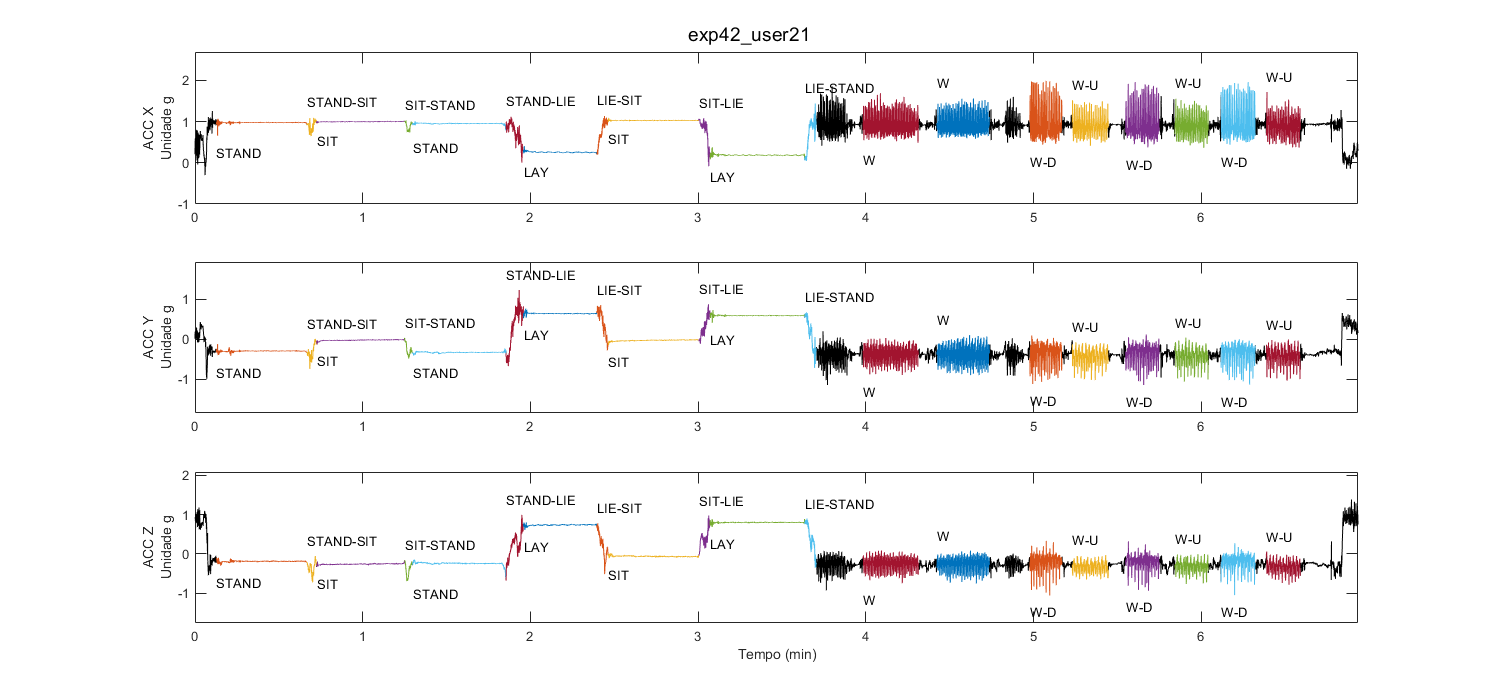

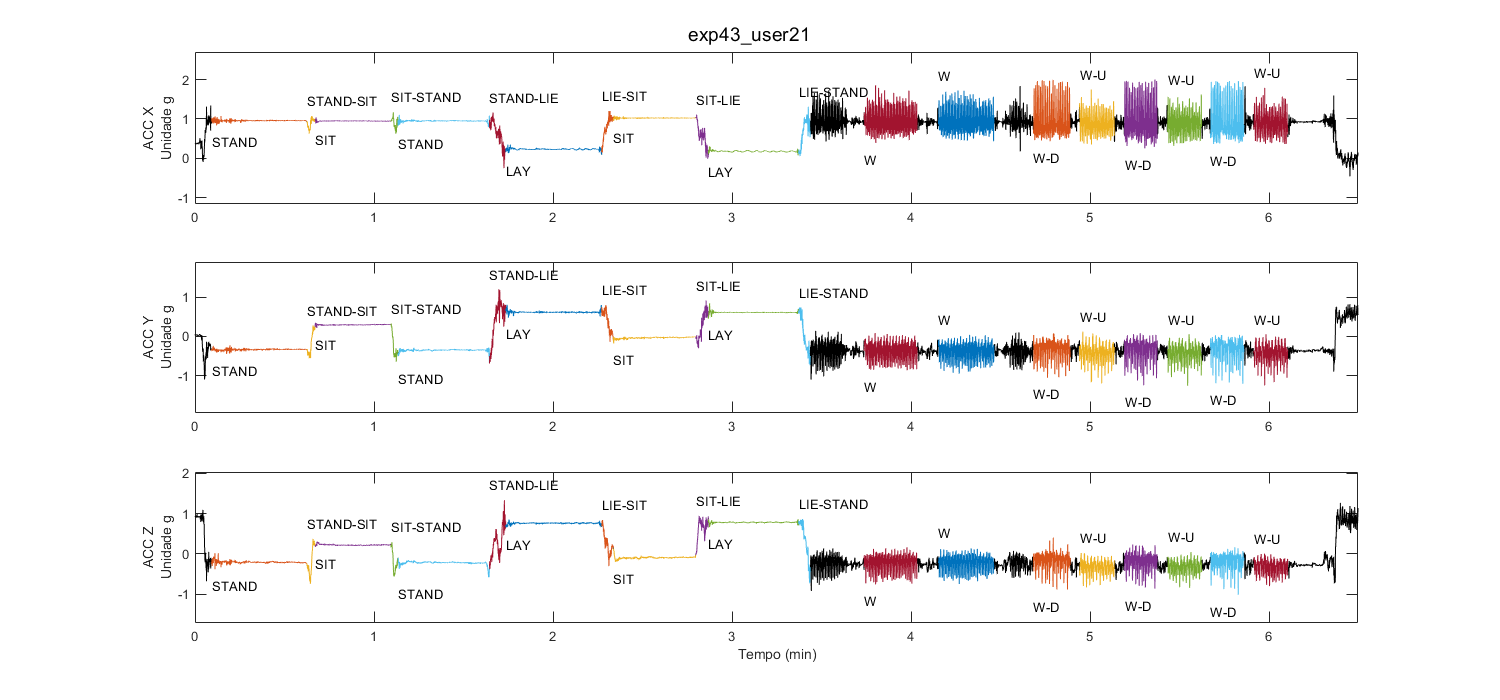

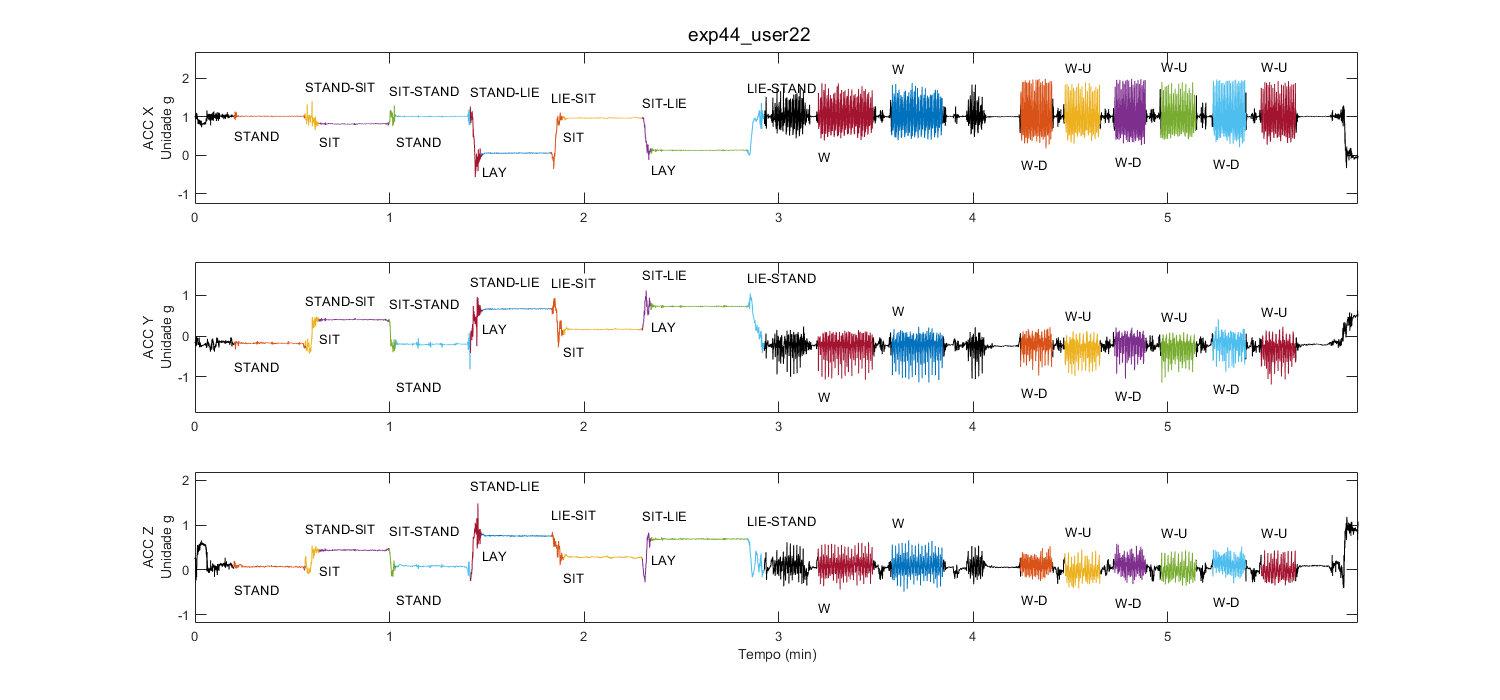

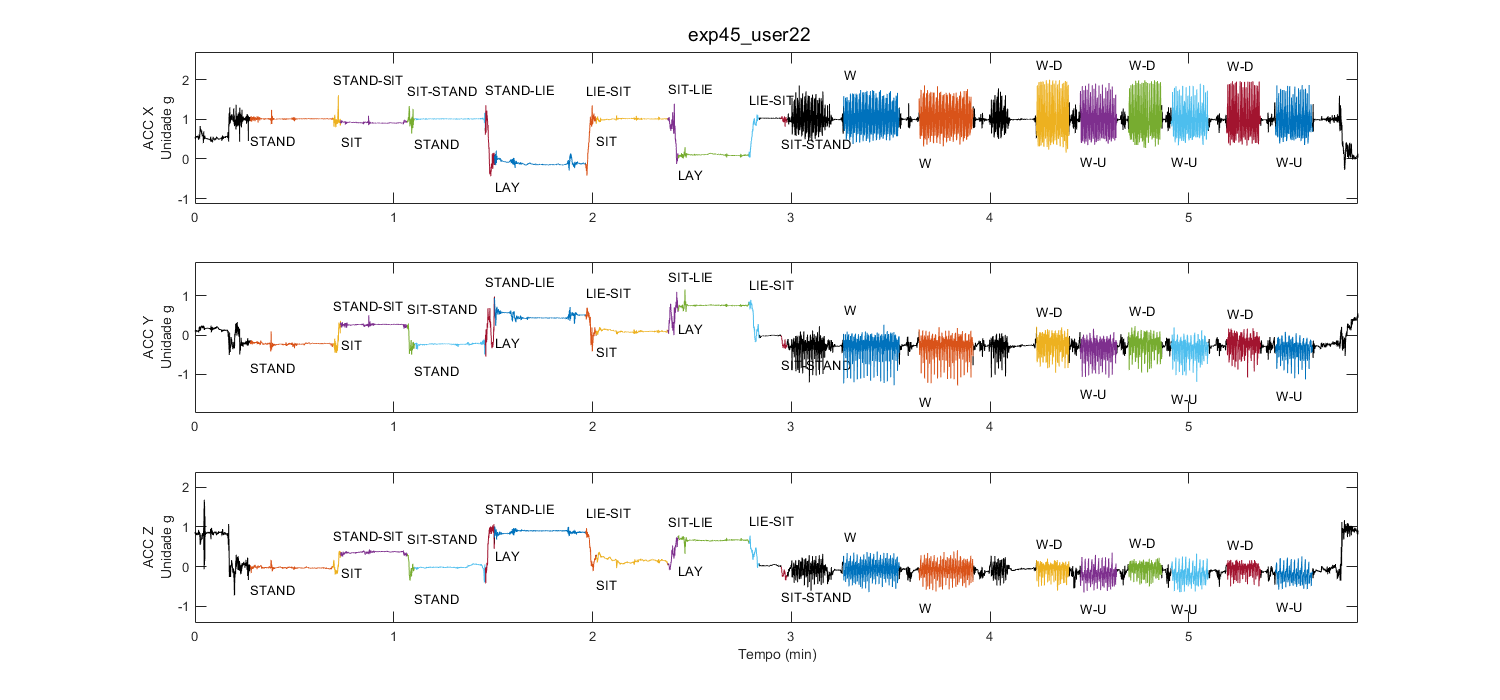

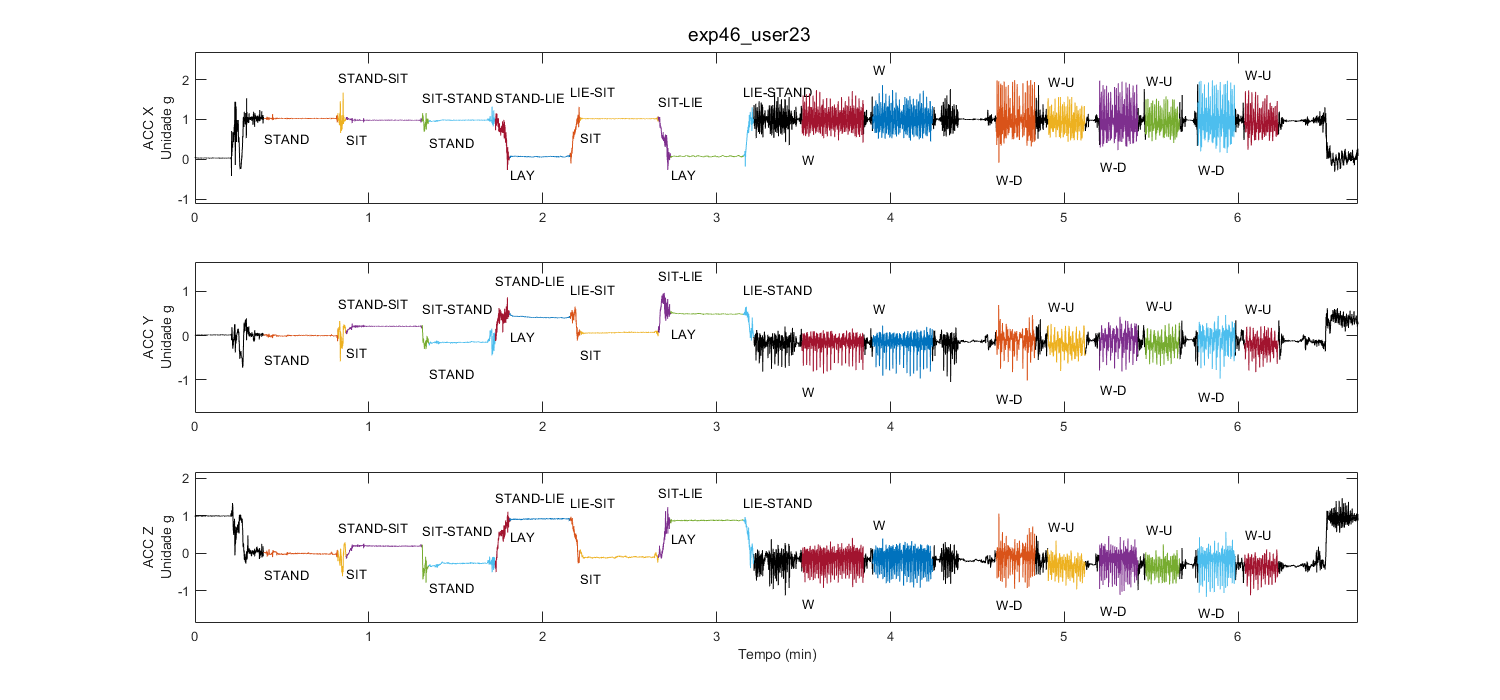

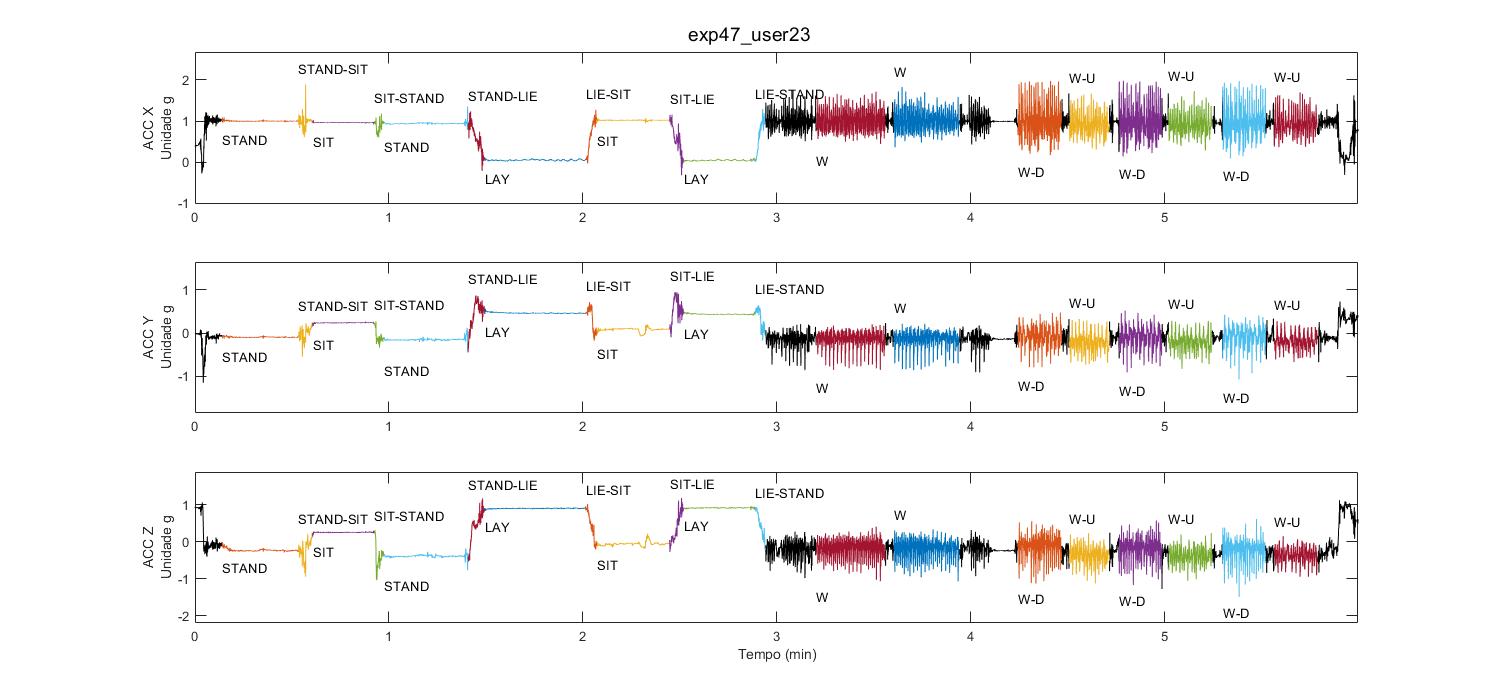

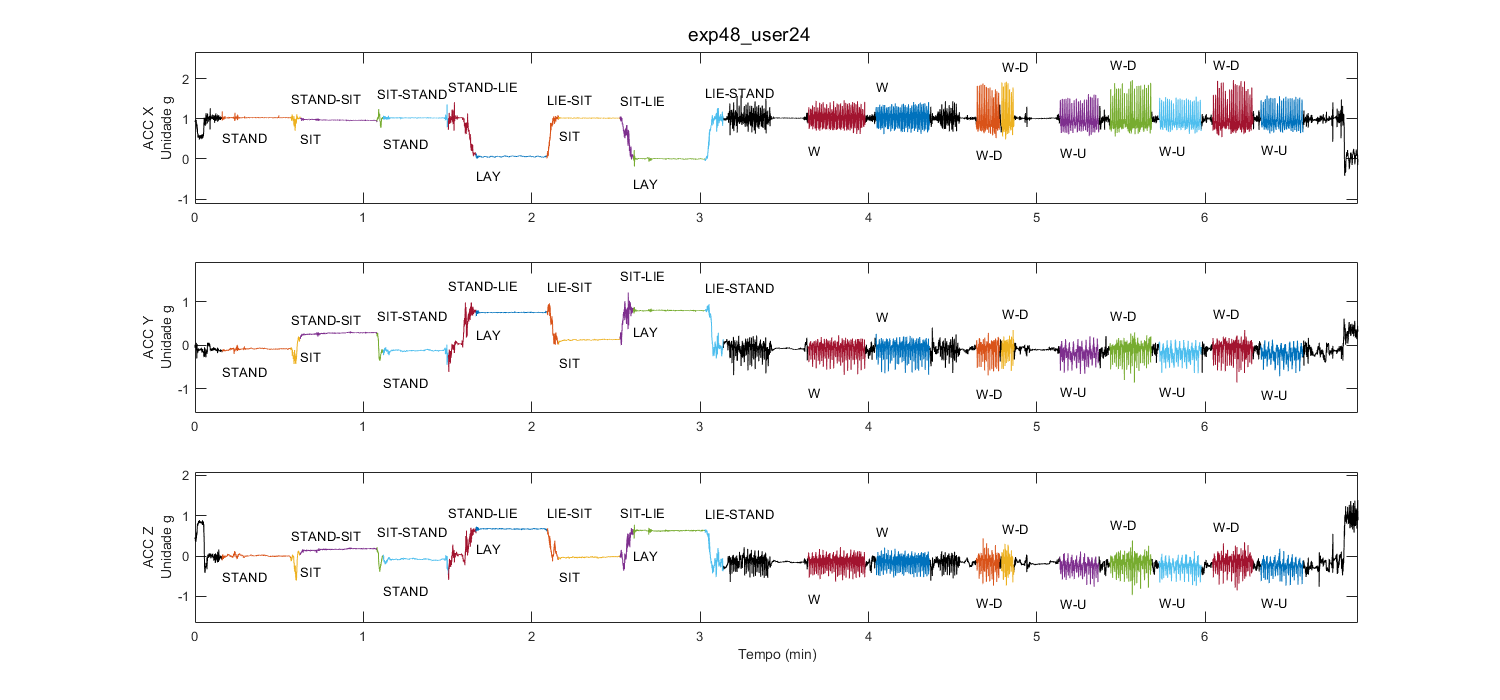

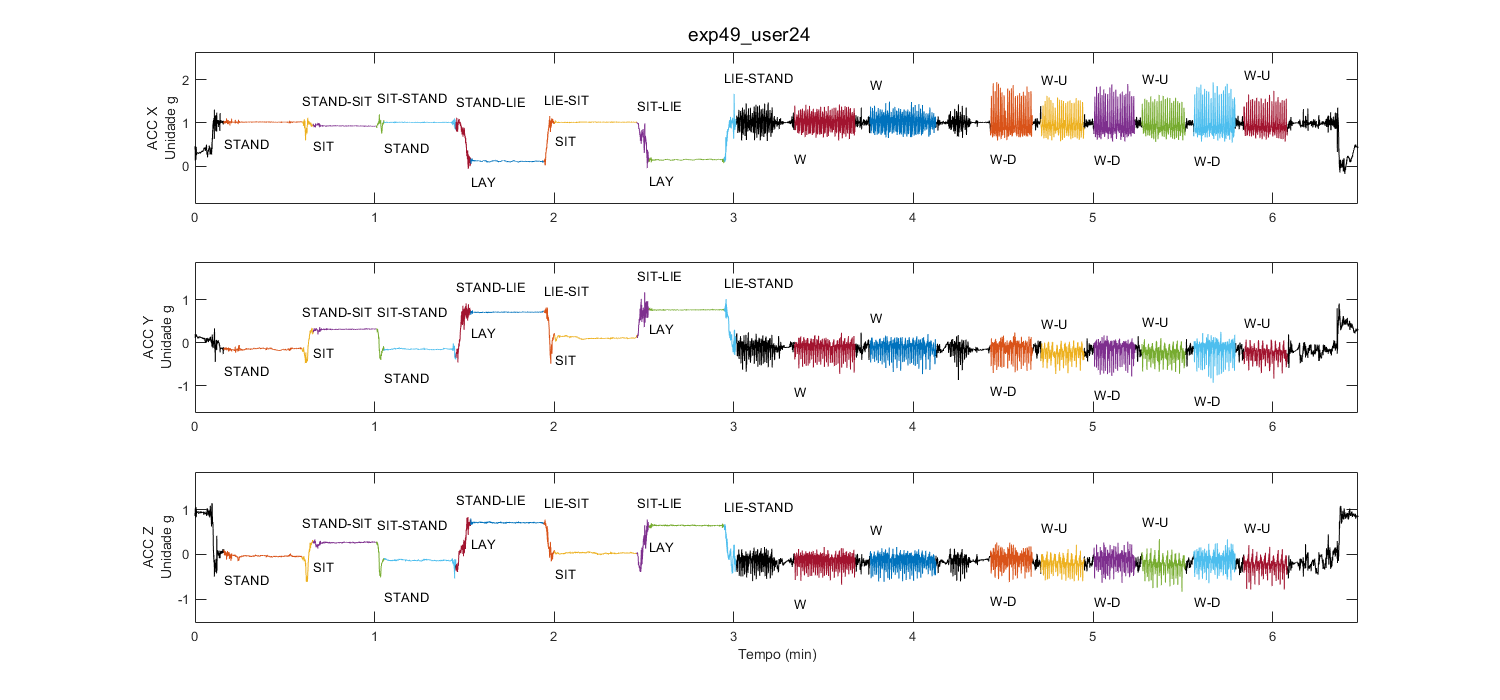

In [5]:
%plot -s 1500,700

% por cada ficheiro de dados
for iterData = 1 : countFichData
    data = eval(sprintf(formatoVarData, experimentID(iterData), userID(iterData)));
    dataActividades = eval(sprintf(formatoVarDataActividades, experimentID(iterData), userID(iterData)));
    
    % numero de valores amostrados
    N = length(data);
    
    % valores positivos
    n = 0 : N-1;

    % t = n * Ts | pra obter em minutos dividir por 60
    tempo = (n.*Ts)./(60);
    
    figure();

    % por cada sensor
    for iterSensor = 1 : countSensores
        
        valorMinAbsoluto = min(data(:, iterSensor)) - 0.7;
        valorMaxAbsoluto = max(data(:, iterSensor)) + 0.7;
        
        % subplot(m, n, p): m-by-n grid, position p
        subplot(countSensores, 1, iterSensor);

        % plot(x, y, black)
        plot(tempo, data(:, iterSensor), "k");
        hold on;
        
        ylabel({sensorID(iterSensor) ; "Unidade g"});
        
        % por cada actividade
        for iterActividade = 1 : length(dataActividades)
            
            % periodo da actividade
            periodoActividade = dataActividades(iterActividade, 2) : dataActividades(iterActividade, 3);
            
            % plot(x, y)
            plot(tempo(periodoActividade), data(periodoActividade, iterSensor));

            valorMinLocal = min(data(periodoActividade, iterSensor));
            valorMaxLocal = max(data(periodoActividade, iterSensor));

            % trocar posicoes legenda (cima e baixo)
            if mod(iterActividade, 2) == 0
                posicaoLegenda = valorMaxLocal + 0.4;
            else
                posicaoLegenda = valorMinLocal - 0.4;
            end

            % text(x, y, txt)
            text(tempo(dataActividades(iterActividade, 2)), posicaoLegenda, activityShortID(dataActividades(iterActividade, 1)));
            
            % Retain current plot when adding new plots
            hold on;
        end

        % axis([x-min x-max y-min y-max])
        axis([tempo(1) tempo(end) valorMinAbsoluto valorMaxAbsoluto]);
    end
    xlabel("Tempo (min)");
    sgtitle(sprintf(formatoVarDataPlot, experimentID(iterData), userID(iterData)));
end

fprintf("\nLegenda:\n");
for iterActividade = 1 : length(activityShortID)
    fprintf("\t%2d.\t%-10s\t%s\n", iterActividade, activityShortID(iterActividade), activityID(iterActividade));
end

clear n N tempo iterData iterSensor iterActividade posicaoLegenda data dataActividades periodoActividade valorMaxLocal valorMinLocal valorMaxAbsoluto valorMinAbsoluto;

Para obter os gráficos, utilizou-se a informação contida nas variáveis `expX_userY_actividades`, para determinar a posição das legendas e dos pequenos excertos do sinal, correspondente às atividades, para desenhar os gráficos coloridos.

### 3. Pretende-se calcular a DFT do segmento do sinal associado a cada atividade, para os vários utilizadores, e identificar as características principais de cada atividade.

### 3.1. Calcular a DFT de cada segmento do sinal para as várias atividades e para os vários utilizadores. Organizar os resultados por atividade.

In [6]:
fprintf("\nVariáveis criadas:  var(SENSOR, INDICE ATIVIDADE)\n");
% por cada ficheiro de dados
for iterData = 1 : countFichData
    data = eval(sprintf(formatoVarData, experimentID(iterData), userID(iterData)));
    dataActividades = eval(sprintf(formatoVarDataActividades, experimentID(iterData), userID(iterData)));

    countDataActividades = length(dataActividades);
    
    % coefsDFT(sensor, actividade)
    coefsDFT = cell(countSensores, countDataActividades);

    % por cada sensor
    for iterSensor = 1 : countSensores
        % por cada actividade
        for iterActividade = 1 : countDataActividades
            periodoActividade = dataActividades(iterActividade, 2) : dataActividades(iterActividade, 3);
            
            % Referencia: https://www.mathworks.com/help/signal/ug/discrete-fourier-transform.html
            % detrend: remove polynomial trend
            % fft: Fast Fourier transform
            % fftshift: Shift zero-frequency component to center of spectrum
            coefsDFT(iterSensor, iterActividade) = {fftshift(fft(detrend(data(periodoActividade, iterSensor))))};
        end 
    end

    % guardar numa var
    nomeVar = sprintf(formatoVarDataCoefsDFT, experimentID(iterData), userID(iterData));
    assignin("base", nomeVar, coefsDFT);
    fprintf("\t> %s\n", nomeVar);
end

clear nomeVar coefsDFT periodoActividade iterActividade iterSensor iterData countDataActividades data dataActividades;


Variáveis criadas:  var(SENSOR, INDICE ATIVIDADE)
	> exp42_user21_coefsDFT
	> exp43_user21_coefsDFT
	> exp44_user22_coefsDFT
	> exp45_user22_coefsDFT
	> exp46_user23_coefsDFT
	> exp47_user23_coefsDFT
	> exp48_user24_coefsDFT
	> exp49_user24_coefsDFT



São criadas as variáveis `expX_userY_coefsDFT` com o valor da DFT (um vetor) por sensor e por índice de atividade.

### 3.2. Identificar as características mais relevantes, nomeadamente espectrais, para cada atividade, analisando e apresentando os resultados obtidos por atividade.

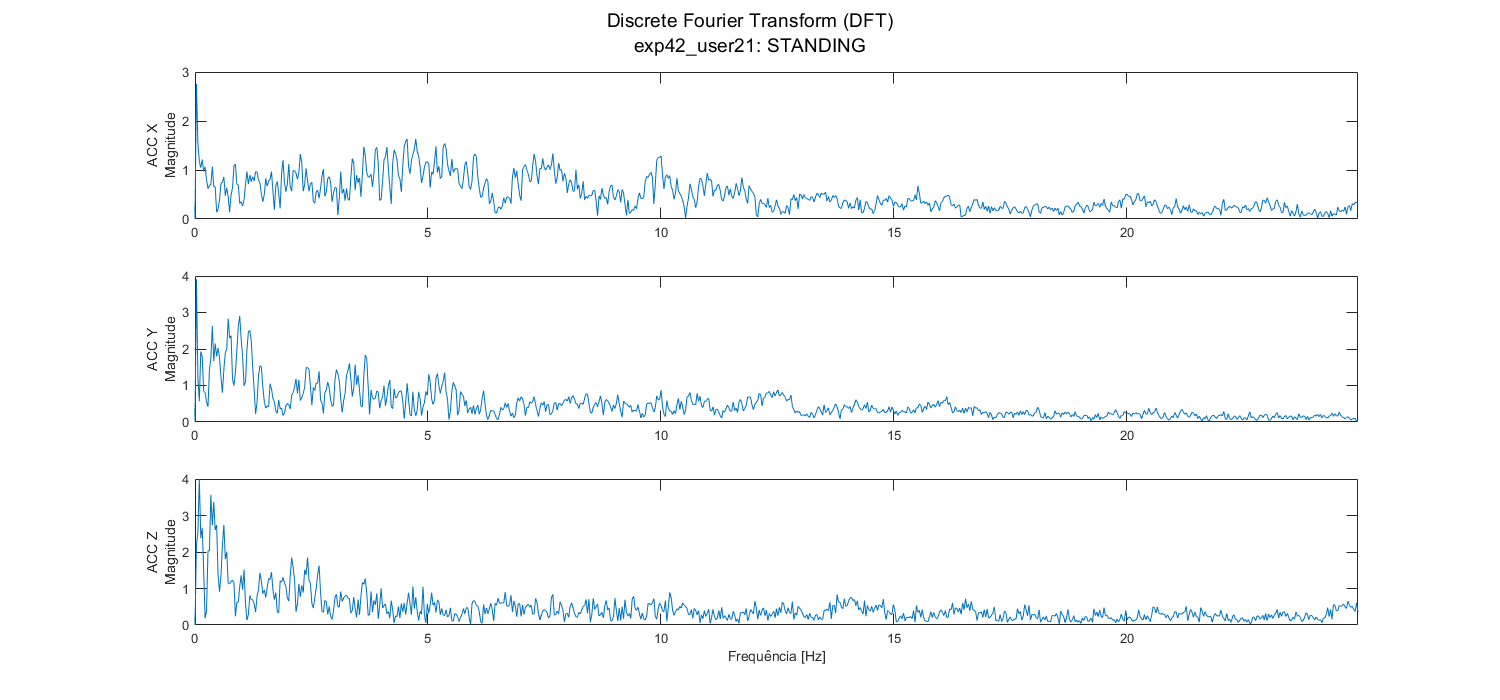

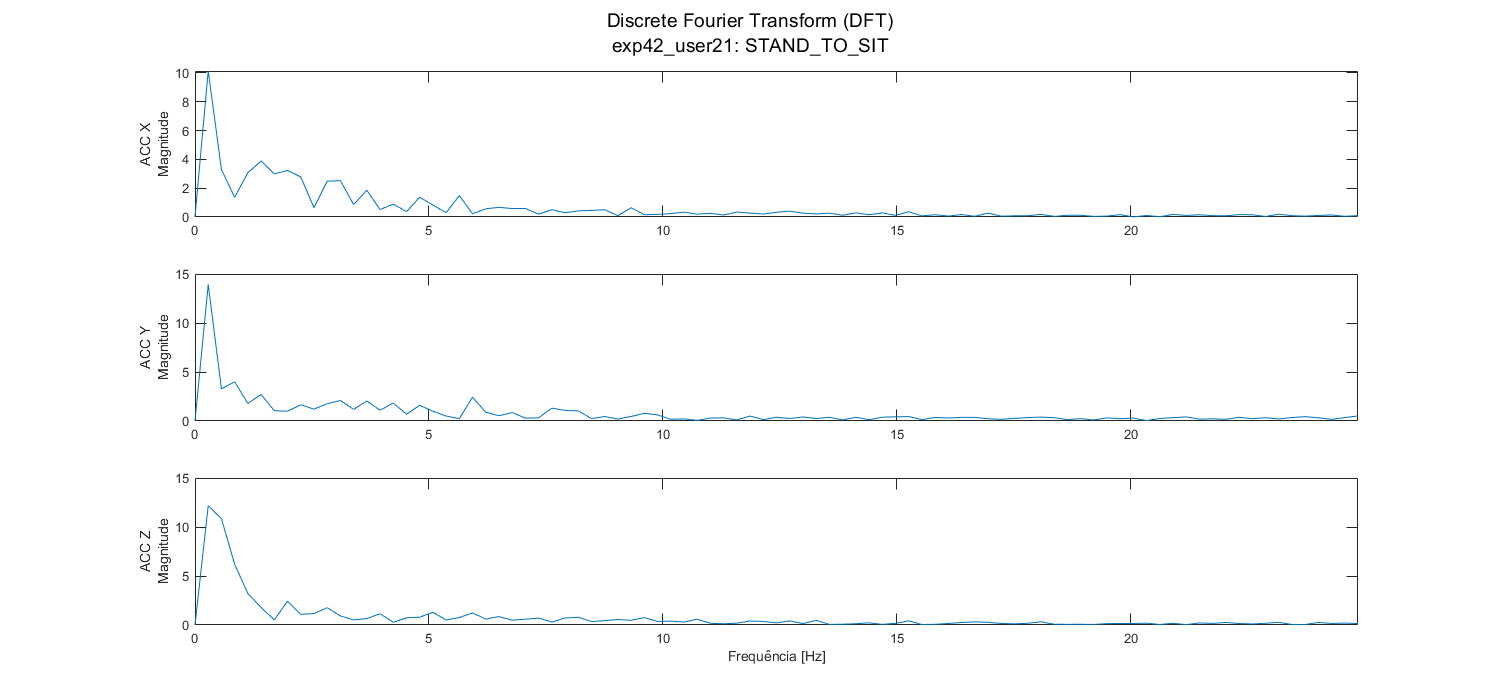

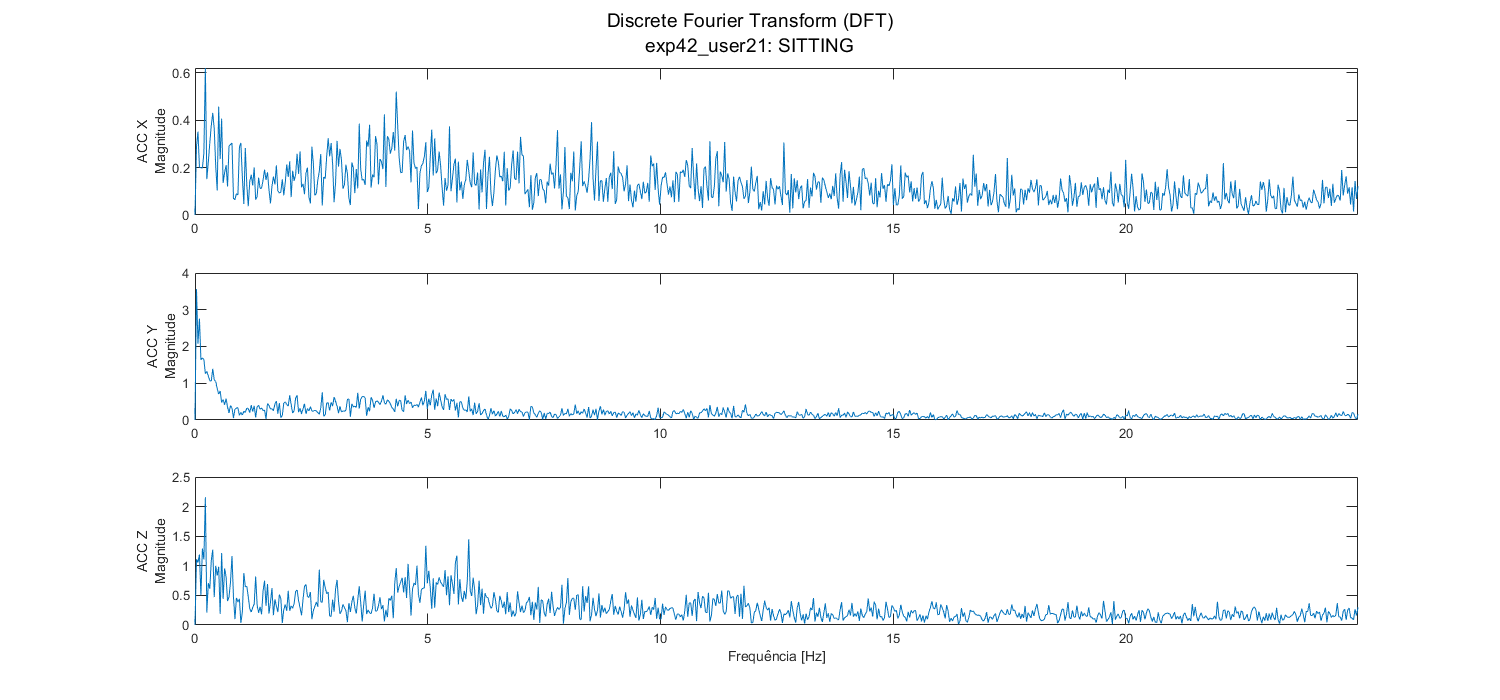

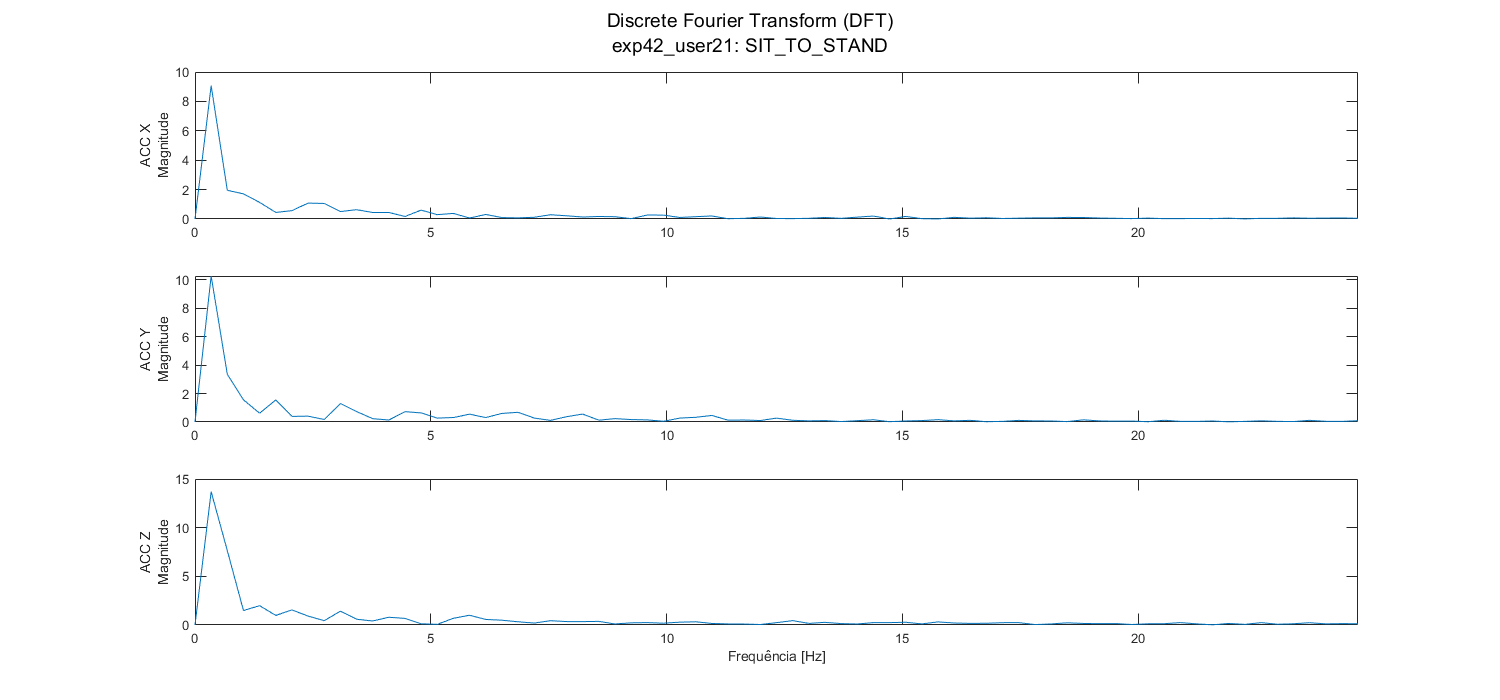

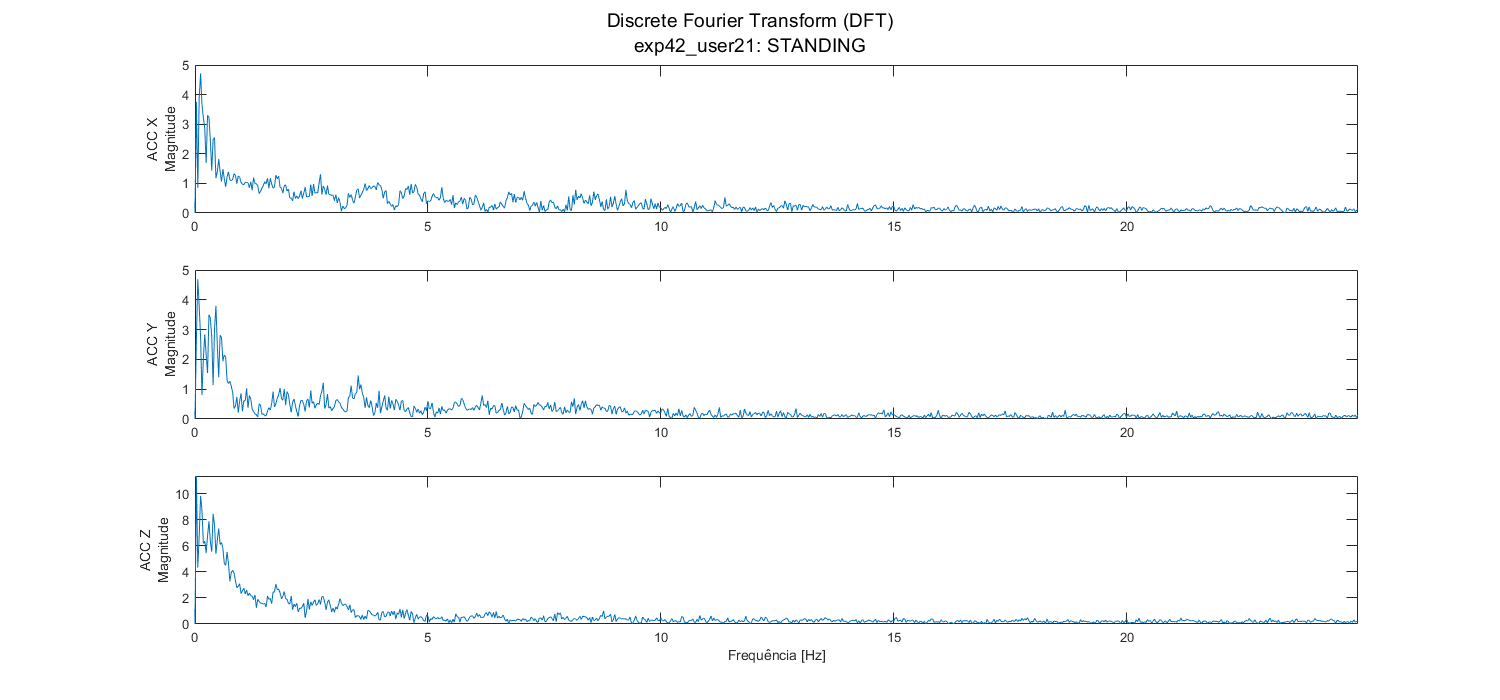

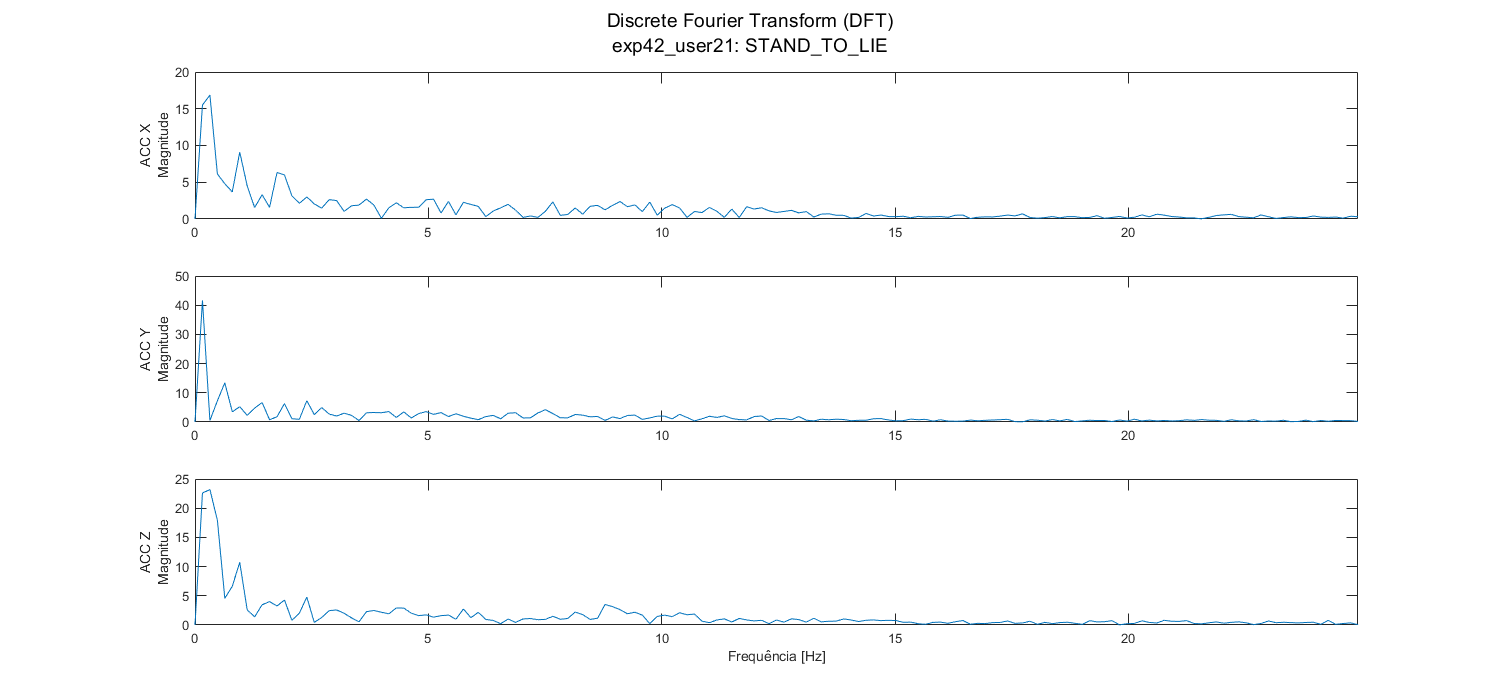

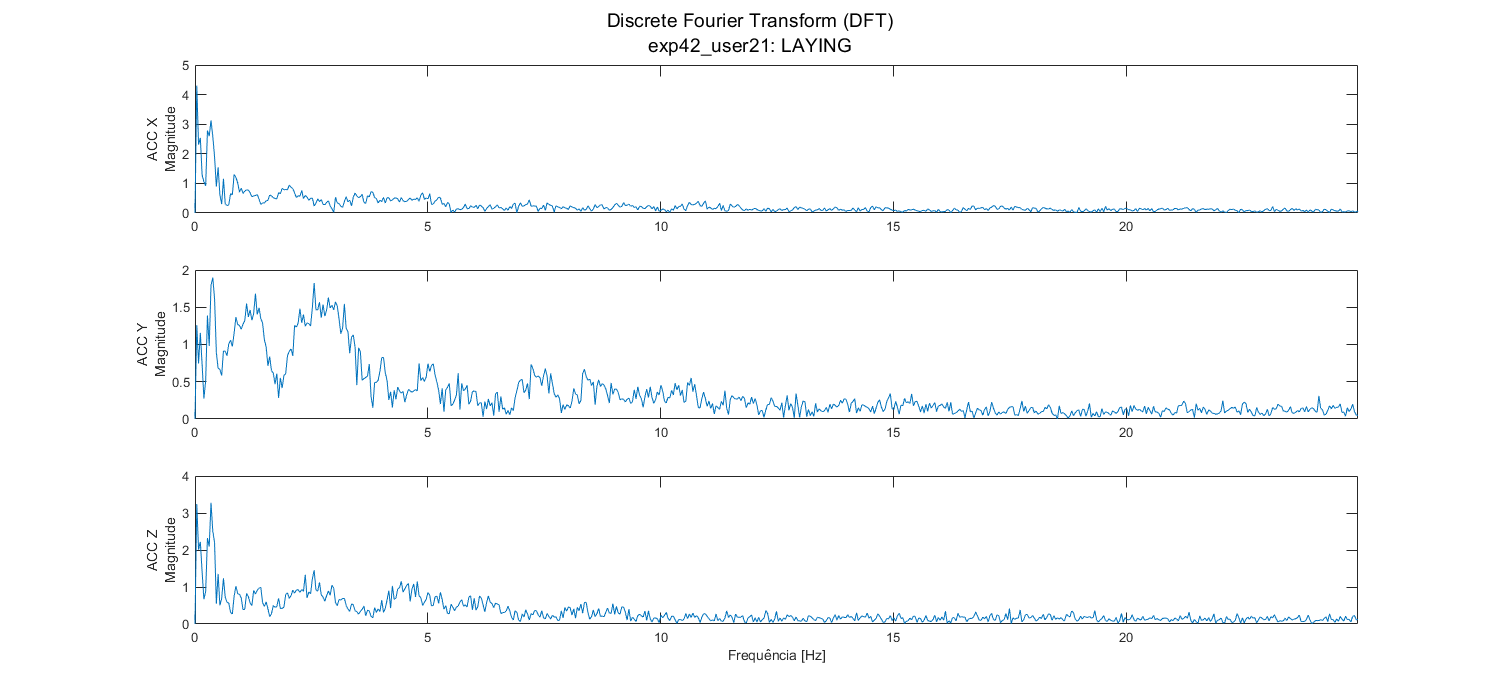

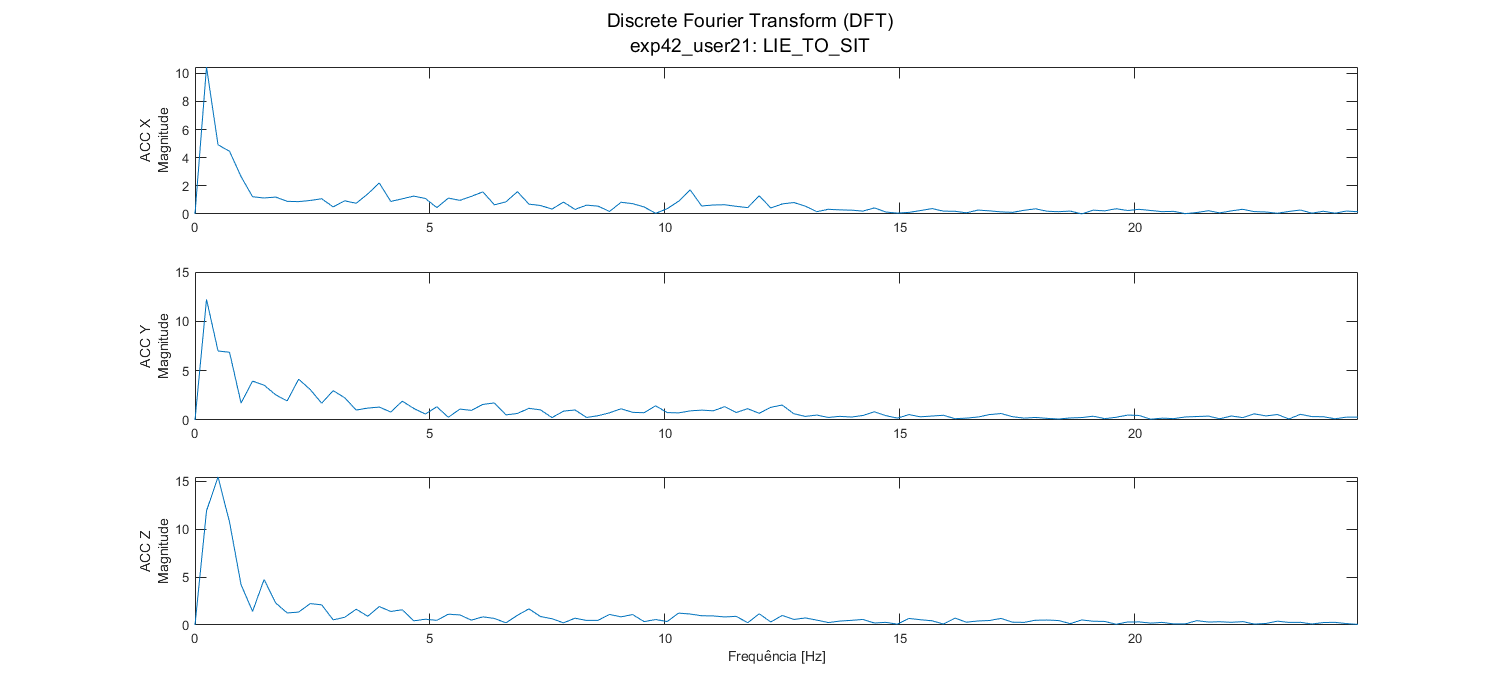

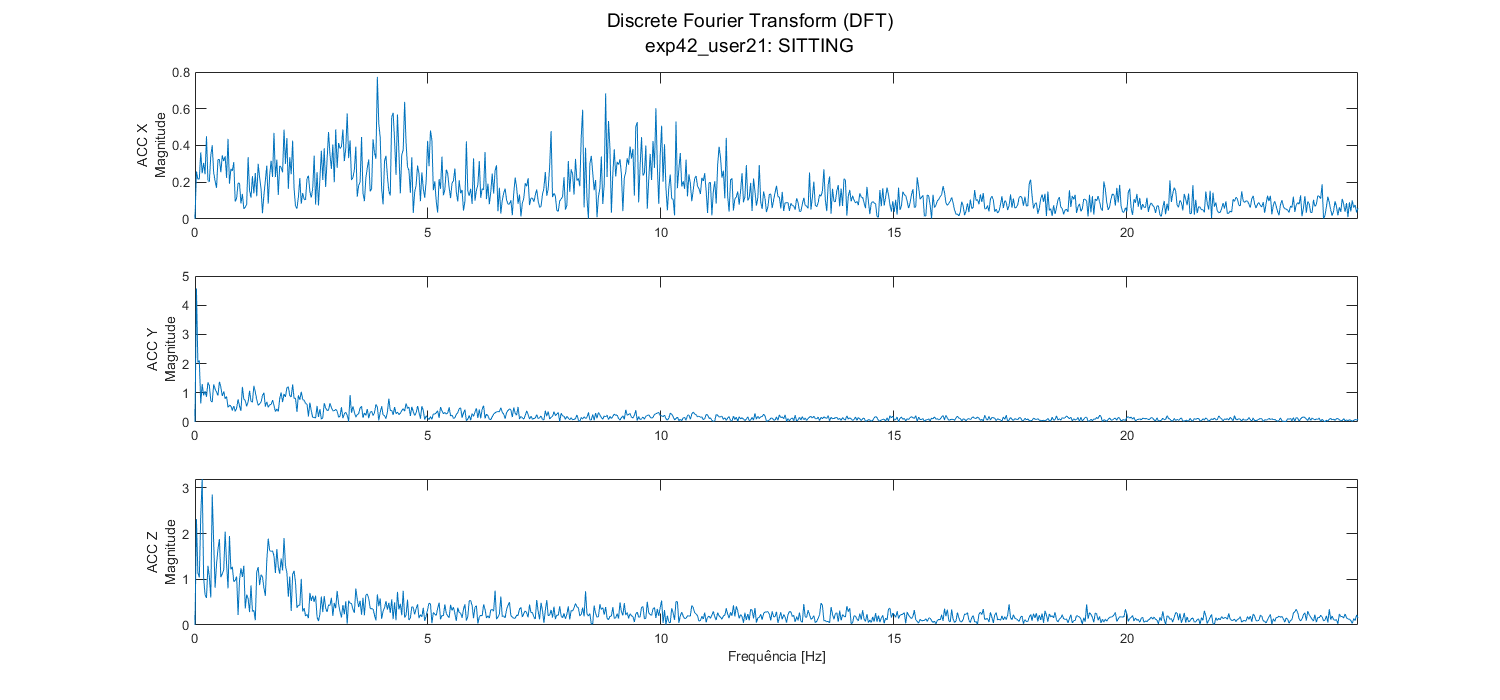

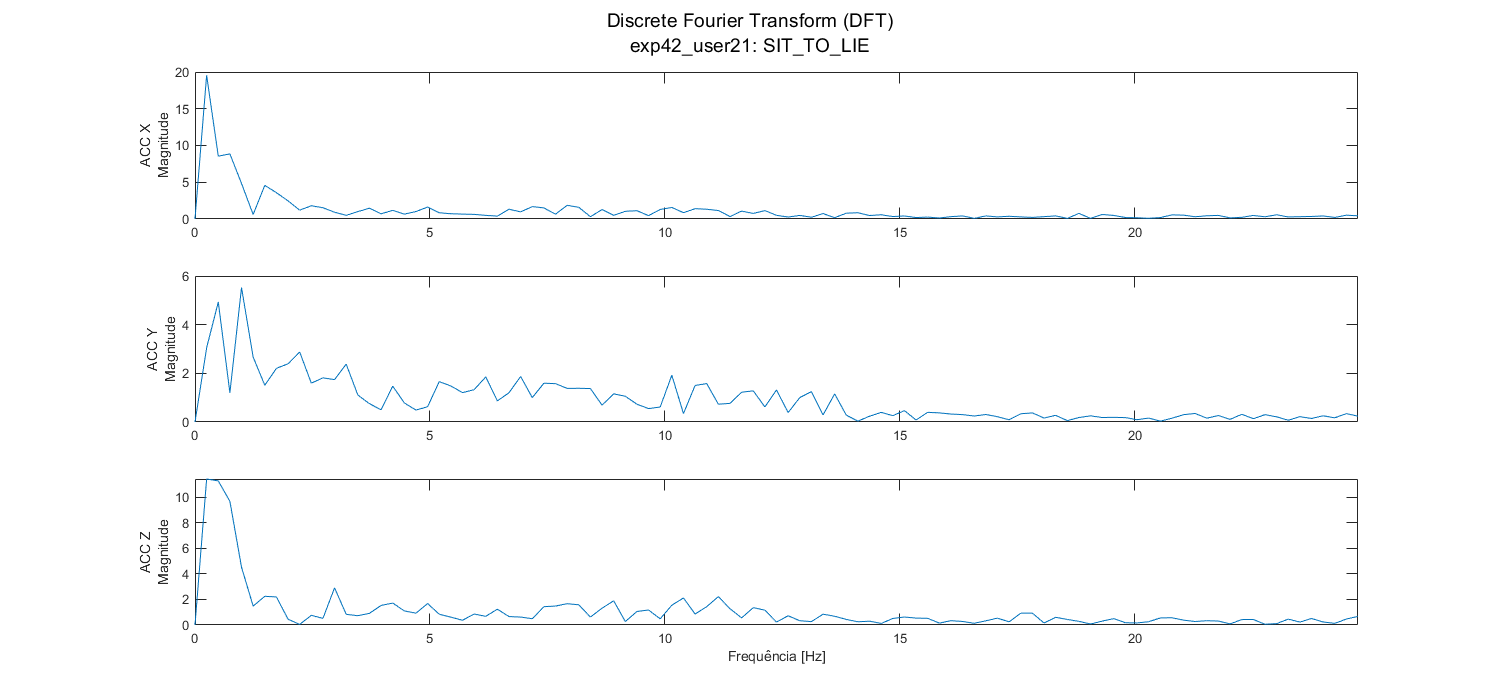

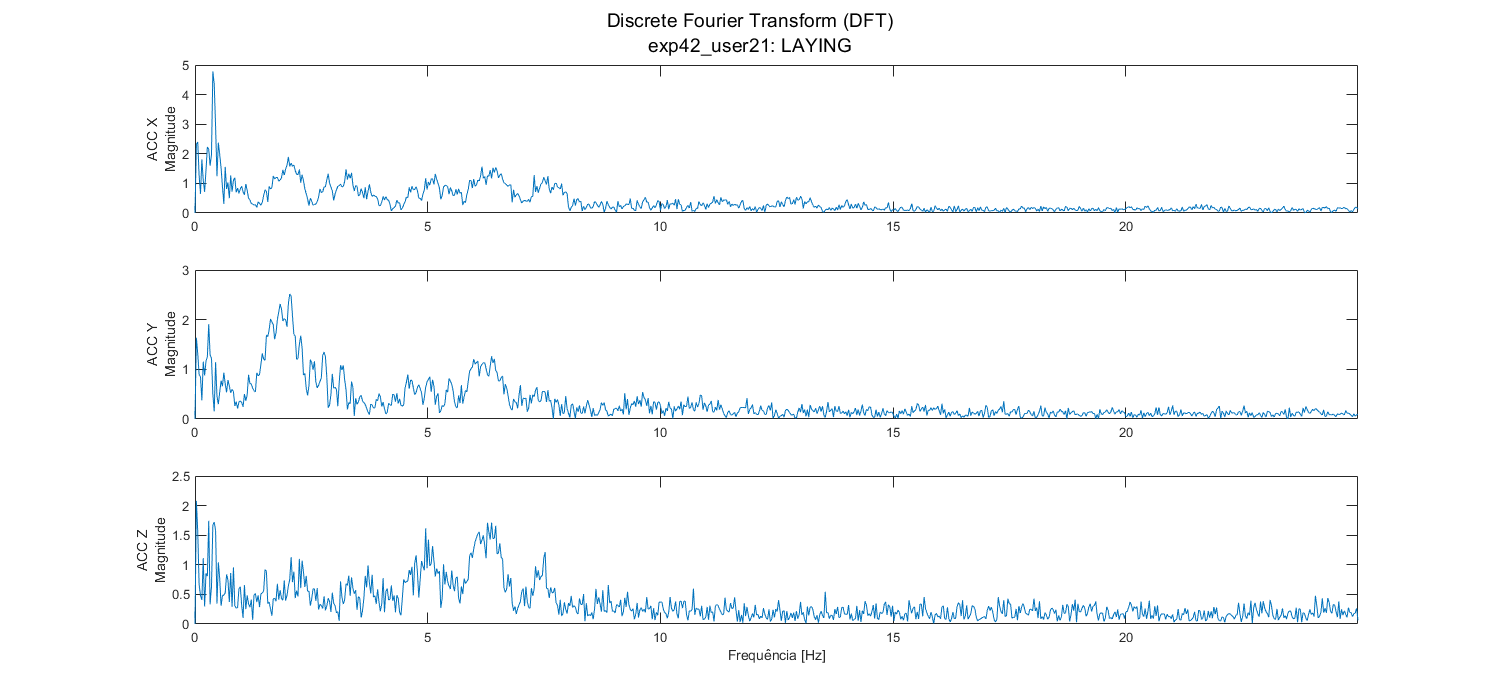

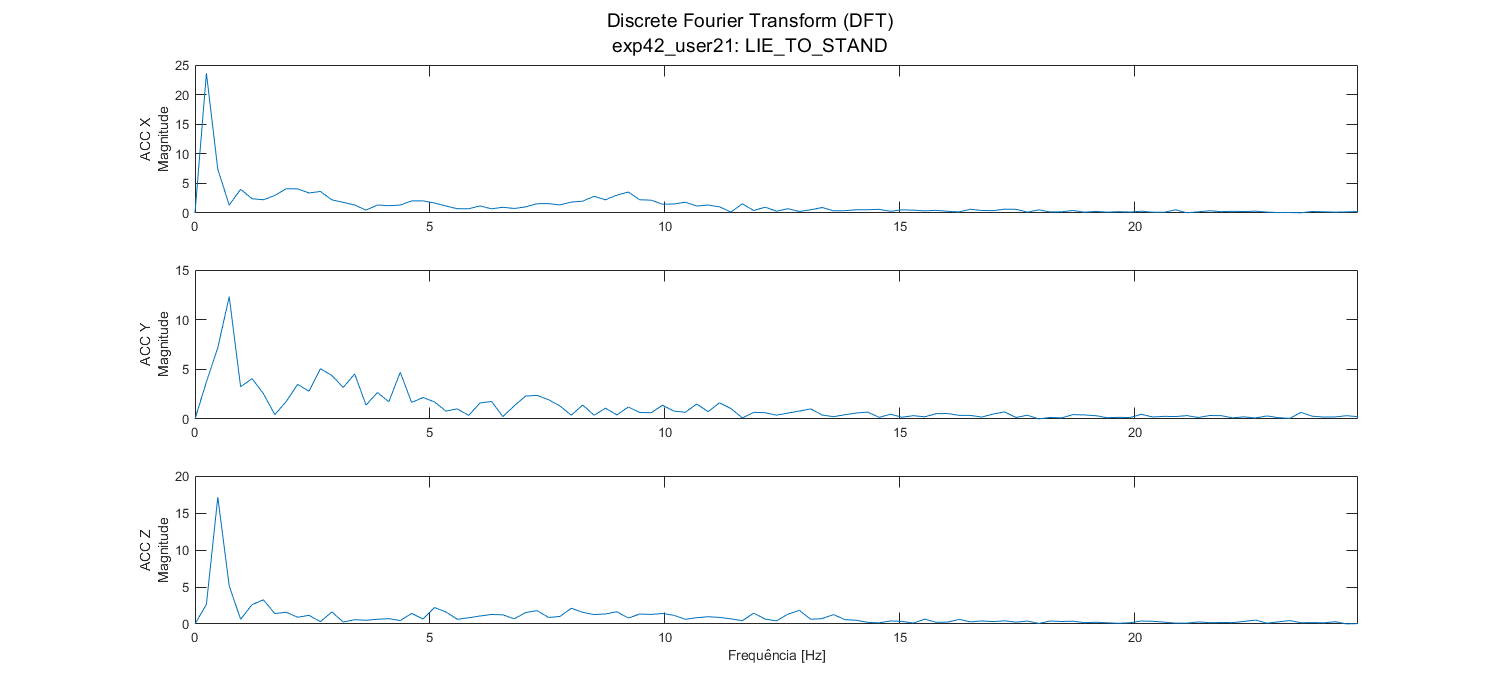

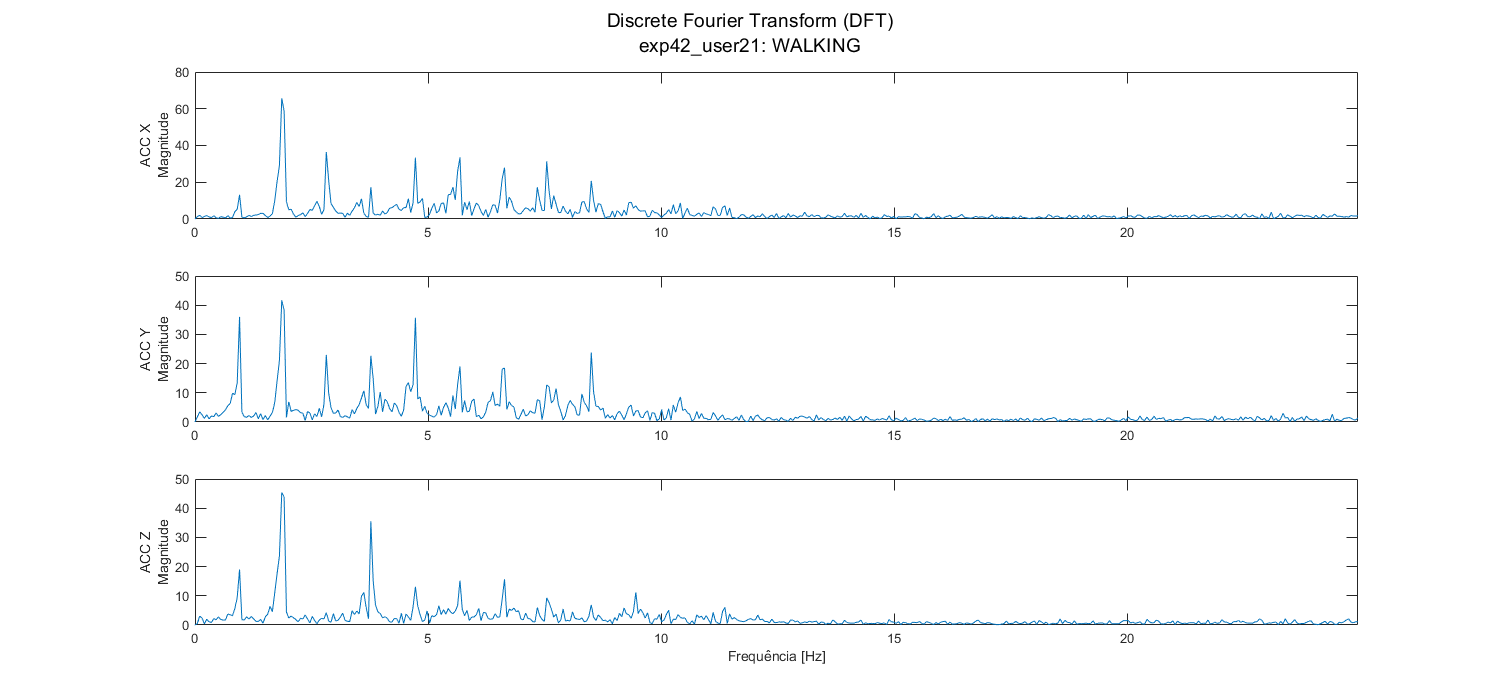

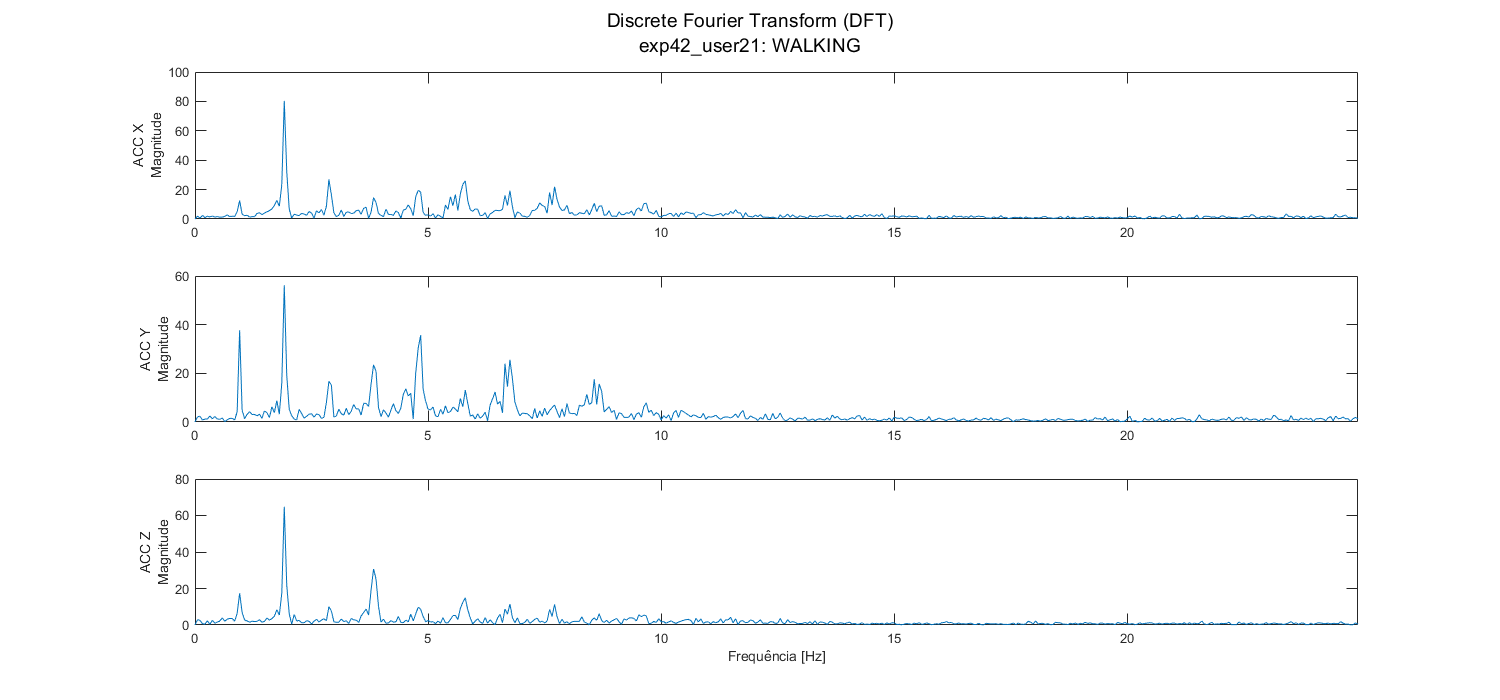

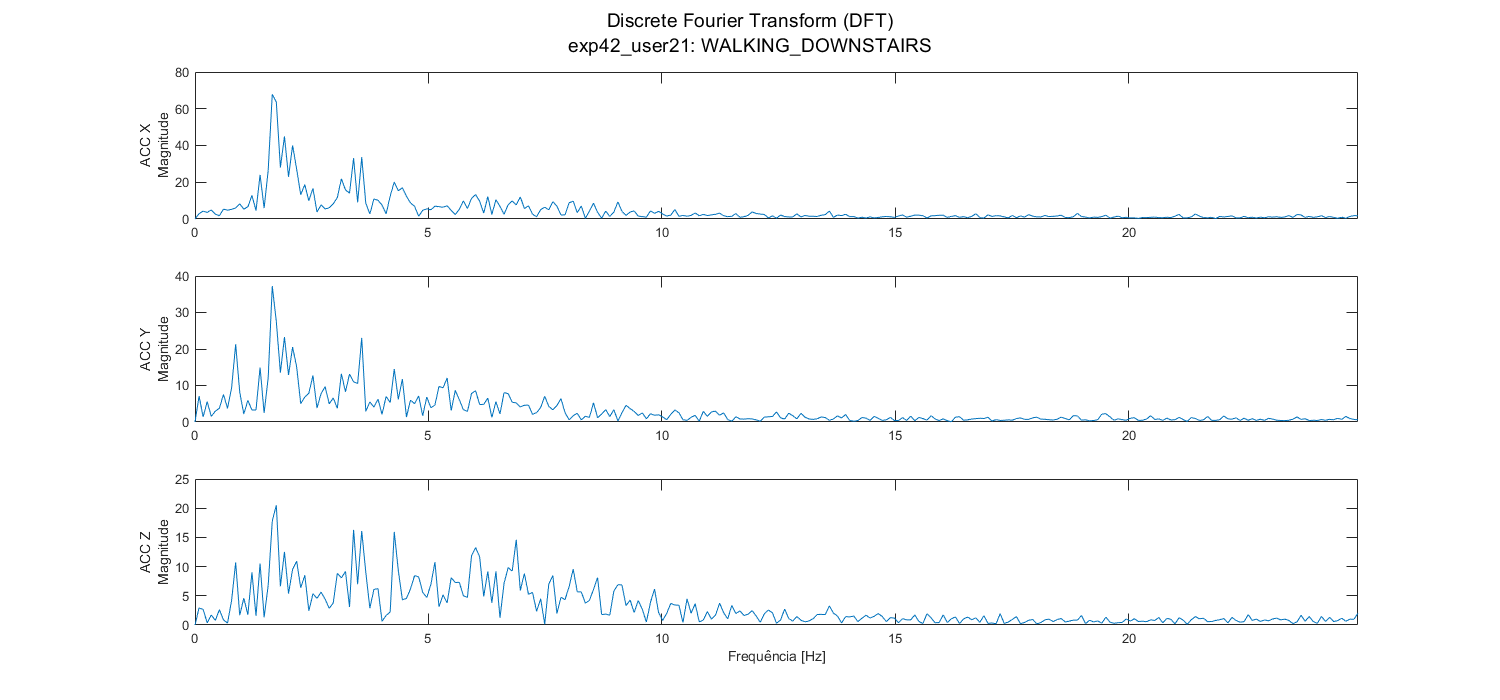

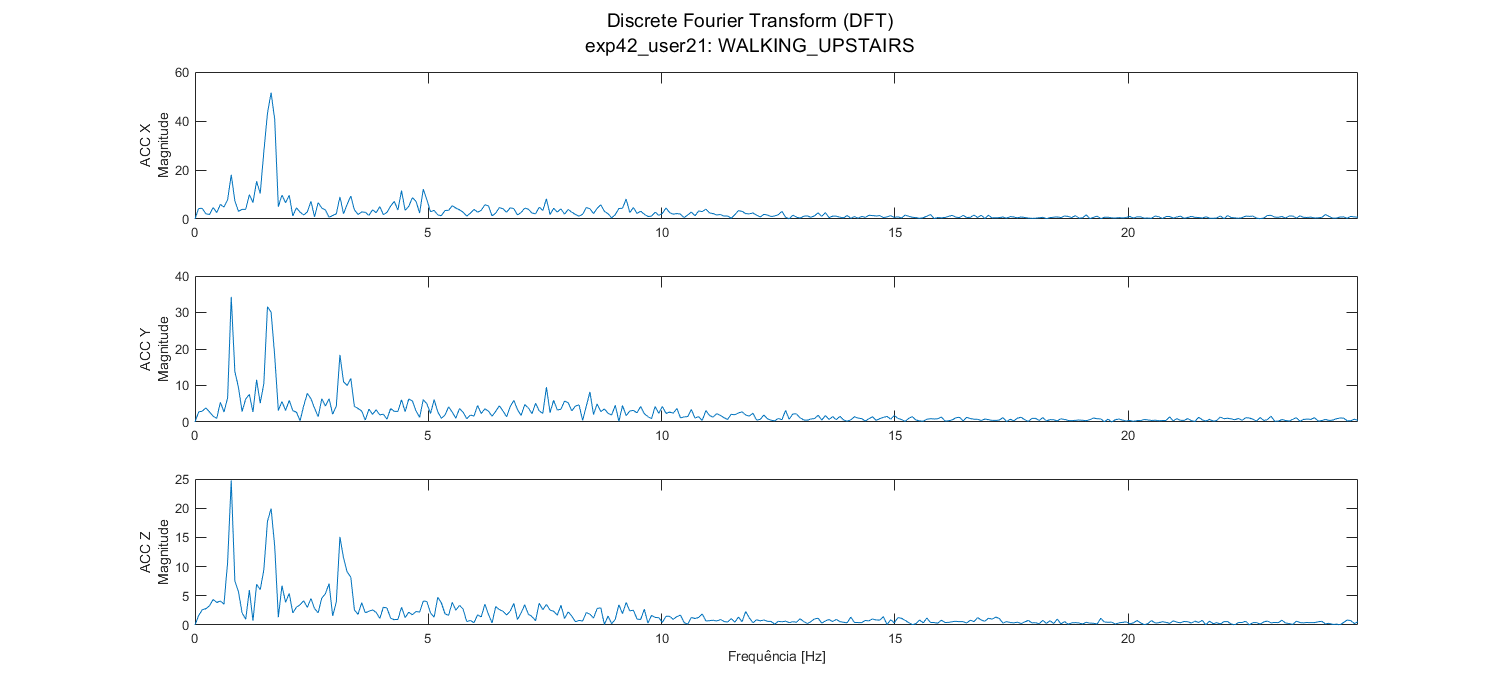

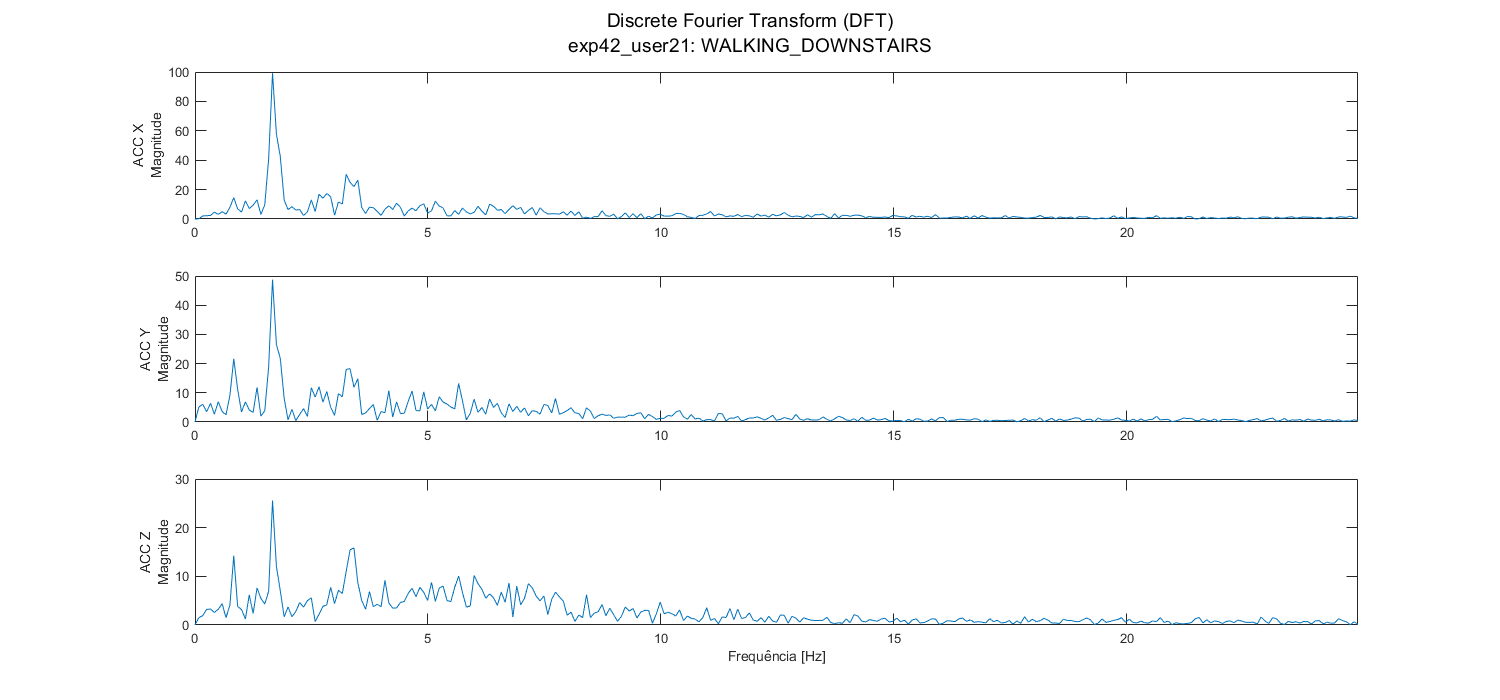

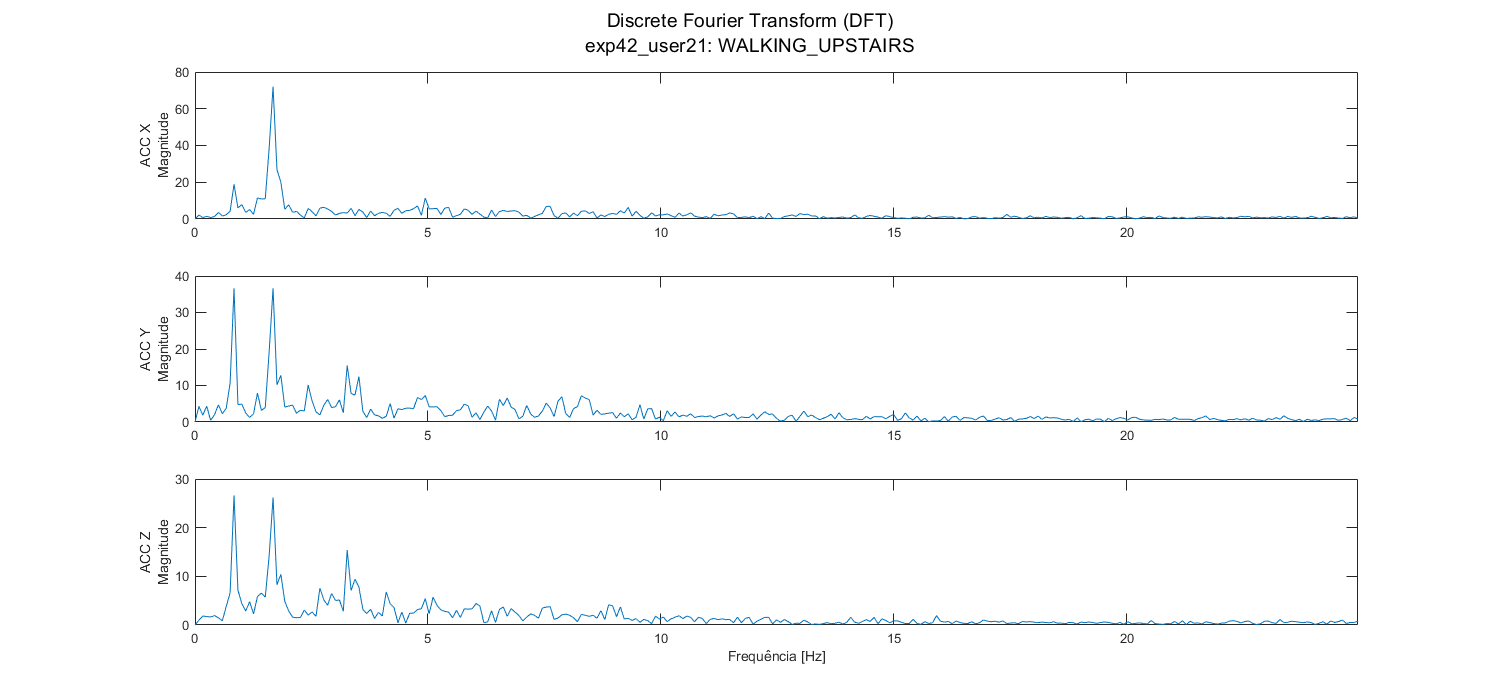

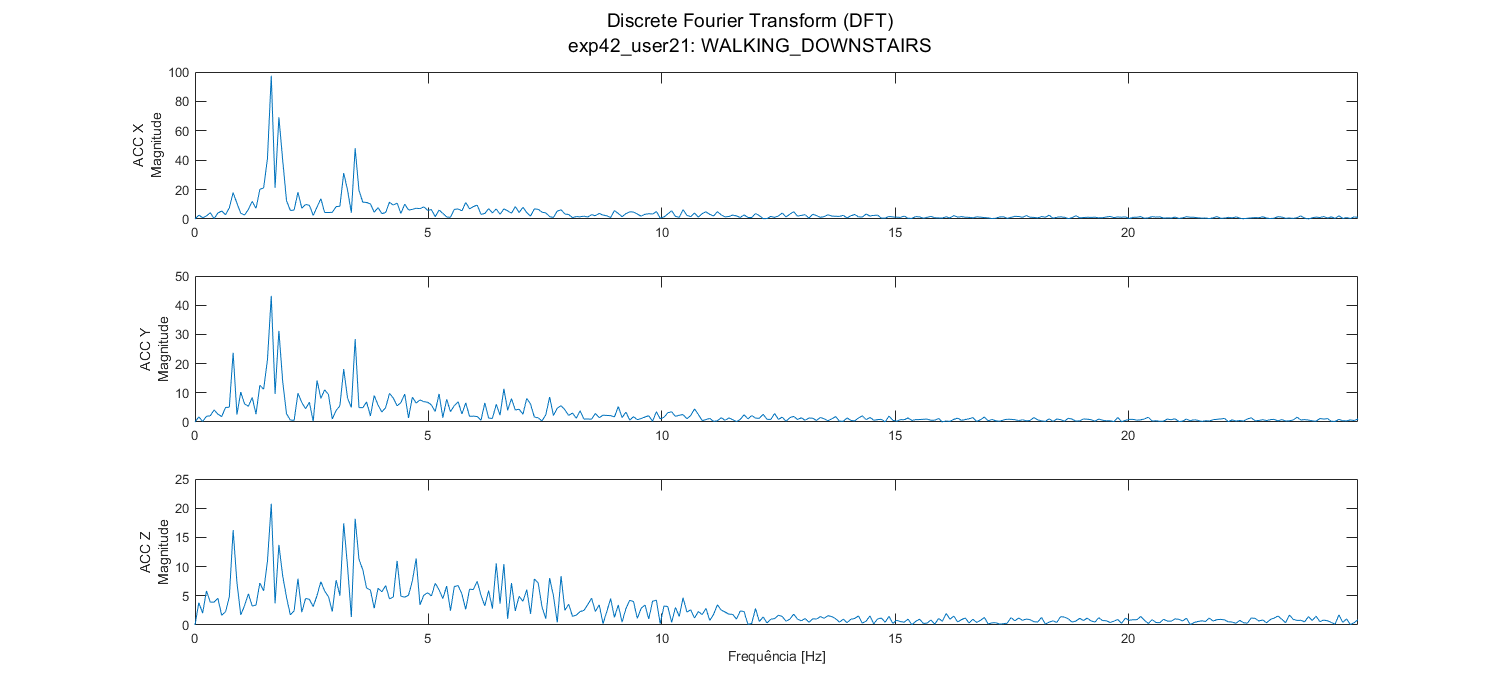

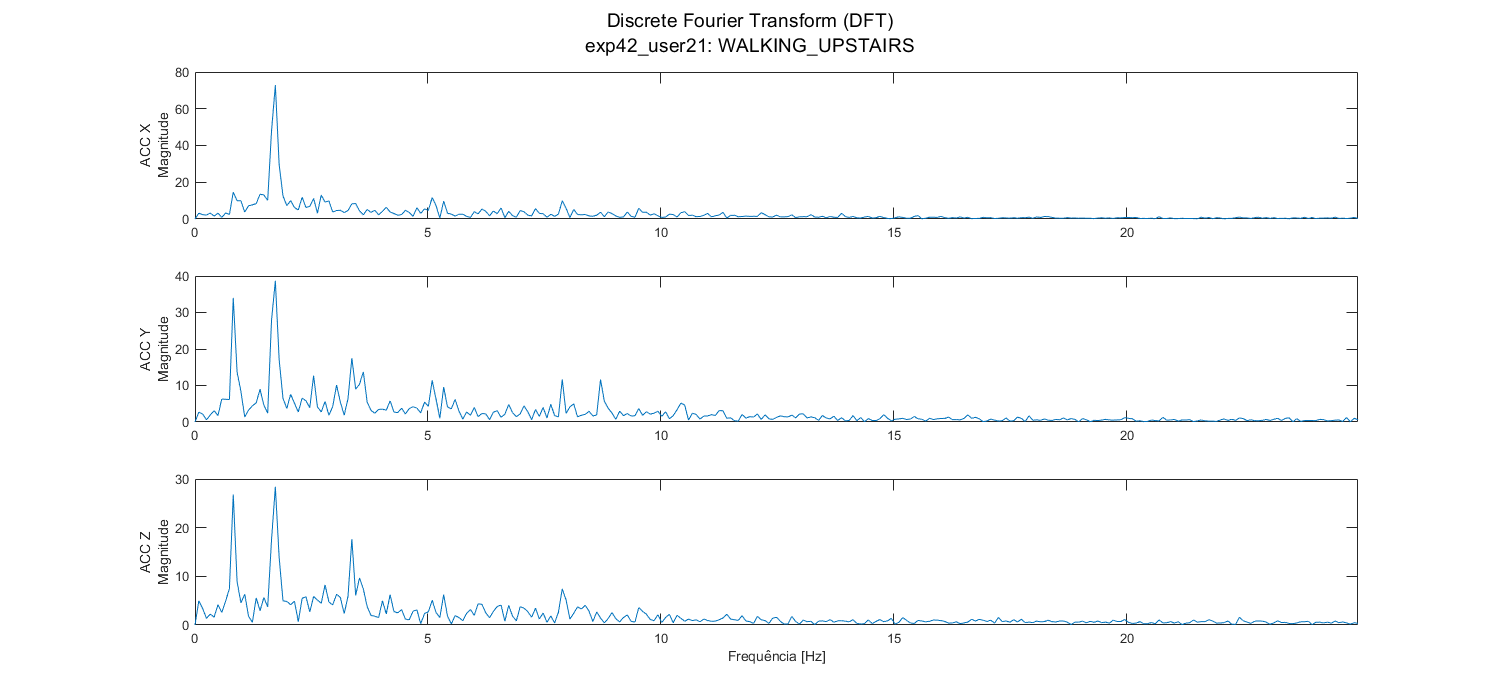

In [8]:
% ########## PARAMETROS: ##########
% > ARRAY COM OS INDICES DOS FICHEIROS DE DADOS A ANALISAR, ex.: [1 3 4 ... n]:
listaData = [1];

% > ARRAY COM OS INDICES DAS ATIVIDADES A ANALISAR, ex.: [4 10 13 ... n]:
listaDataActividades = [];
% #################################


%plot -s 1500,700

% Nota: Se os arrays estiverem vazios, a analise é feita a todo o dataset
if isempty(listaData)
    listaData = 1 : countFichData;
end

% por cada ficheiro de dados
for iterData = listaData
    if iterData <= countFichData && iterData > 0
        data = eval(sprintf(formatoVarData, experimentID(iterData), userID(iterData)));
        dataActividades = eval(sprintf(formatoVarDataActividades, experimentID(iterData), userID(iterData)));
    
        countDataActividades = length(dataActividades);
    
        % Nota: Se os arrays estiverem vazios, a analise é feita a todo o dataset
        if isempty(listaDataActividades)
            listaDataActividades = 1 : countDataActividades;
        end
        
        % por cada actividade
        for iterActividade = listaDataActividades
            if iterActividade <= countDataActividades && iterActividade > 0
                figure();
                sgtitle({"Discrete Fourier Transform (DFT)" ; sprintf(formatoVarData, experimentID(iterData), userID(iterData)) + ": " + activityID(dataActividades(iterActividade, 1))}, 'Interpreter', 'none');

                % Periodo Fundamental
                N = length(data(dataActividades(iterActividade, 2) : dataActividades(iterActividade, 3)));

                % Frequencia Fundamental
                f0 = fs/N;
                
                if mod(N, 2) == 0
                    n = -N/2 : N/2 - 1;
                else
                    n = -fix(N/2) : fix(N/2);
                end
                
                % Dominio da frequencia
                dominioFrequencia = n * f0;

                % por cada sensor
                for iterSensor = 1 : countSensores
                    % subplot(m, n, p): m-by-n grid, position p
                    subplot(countSensores, 1, iterSensor);
                    
                    coefsDFT = eval(sprintf(formatoVarDataCoefsDFT, experimentID(iterData), userID(iterData)));
                    
                    % Referencia: https://www.mathworks.com/help/signal/ug/discrete-fourier-transform.html
                    % plot(x, y)
                    % abs: absolute value and complex magnitude
                    plot(dominioFrequencia, abs(cell2mat(coefsDFT(iterSensor, iterActividade))));

                    % xlim([x-min x-max])
                    xlim([0 max(dominioFrequencia)]);

                    ylabel({sensorID(iterSensor) ; "Magnitude"});
                end
                xlabel("Frequência [Hz]");
            else
                % evitar ArrayIndexOutOfBoundsException
                fprintf("Aviso: O ficheiro %s não tem a atividade com indice %d (max: %d)\n", sprintf(formatoVarData, experimentID(iterData), userID(iterData)), iterActividade, countDataActividades);
            end
        end
    else
        % evitar ArrayIndexOutOfBoundsException
        fprintf("Aviso: Não existe nenhum ficheiro com indice %d (max: %d)\n", iterData, countFichData);
    end
end

clear data dataActividades listaData listaDataActividades iterData iterActividade iterSensor countDataActividades coefsDFT dominioFrequencia f0 n N;

Ao contrário das atividades de transição, as atividades estáticas não são fáceis de determinar as frequências mais relevantes, uma vez que nao há nenhuma que se destaca mais que as restantes. Nas atividades dinâmicas percebe-se uma sazonalidade.

### 3.3. Para cada atividade dinâmica, identificar estatisticamente o número de passos por minuto para cada utilizador. Criar uma tabela com os resultados obtidos e calcular o valor médio e o desvio padrão por atividade.

In [9]:
% usar sensor ACC X
sensor = 1;

% por cada ficheiro de dados
for iterData = 1 : countFichData
    data = eval(sprintf(formatoVarData, experimentID(iterData), userID(iterData)));
    dataActividades = eval(sprintf(formatoVarDataActividades, experimentID(iterData), userID(iterData)));
    
    % encontrar indices no dataActividades que sejam 1, 2 e 3 ("W", "W-U", "W-D")
    dataActividadesFind = find(dataActividades(:, 1) == 1 | dataActividades(:, 1) == 2 | dataActividades(:, 1) == 3);

    % passos = [indice atividade | passos]
    passos = zeros(length(dataActividadesFind), 2);

    fprintf("\n%s:\n", sprintf(formatoVarData, experimentID(iterData), userID(iterData)));
    fprintf("\t%-10s\t%-20s\t%-6s\n", "INDICE", "ATIVIDADE", "PASSOS");

    iterTabela = 1;

    % por cada actividade
    for iterActividade = dataActividadesFind'
        
        % Periodo Fundamental
        N = length(data(dataActividades(iterActividade, 2) : dataActividades(iterActividade, 3)));

        % Frequencia Fundamental
        f0 = fs/N;
                
        if mod(N, 2) == 0
            n = -N/2 : N/2 - 1;
        else
            n = -fix(N/2) : fix(N/2);
        end
                
        % Dominio da frequencia
        dominioFrequencia = n * f0;
        
        coefsDFT = eval(sprintf(formatoVarDataCoefsDFT, experimentID(iterData), userID(iterData)));

        % Valor maximo da magnitude
        valorMaxMagnitude = max(abs(cell2mat(coefsDFT(sensor, iterActividade))));

        % numa sinusoidal, 1 passo <-> 1 ciclo completo (frequencia) (em 1 seg.), logo o numero de passos num minuto = 60 * freq
        
        % encontrar uma frequencia mais relevante
        frequenciaRelevante = dominioFrequencia(abs(cell2mat(coefsDFT(sensor, iterActividade))) == valorMaxMagnitude);
        % eliminar valor negativo
        frequenciaRelevante =  frequenciaRelevante(frequenciaRelevante > 0);

        % guardar numa var
        passos(iterTabela, 1) = iterActividade;
        passos(iterTabela, 2) = 60 * frequenciaRelevante; % para minutos, multiplicar por 60

        fprintf("\t%-10d\t%-20s\t%.1f\n", iterActividade, activityID(dataActividades(iterActividade, 1)), passos(iterTabela, 2));

        iterTabela = iterTabela + 1;
    end 

    % guardar numa var
    nomeVar = sprintf(formatoVarDataPassos, experimentID(iterData), userID(iterData));
    assignin("base", nomeVar, passos);
    
    % Media
    media = mean(passos(:, 2));
    fprintf("\n\tMédia: %f\n", media);

    % Desvio Padrao
    desvioPadrao = std(passos(:, 2));
    fprintf("\tDesvio Padrão: %f\n\n", desvioPadrao);
end

fprintf("\nVariáveis criadas:  var[INDICE ACTIVIDADE | PASSOS]\n");
for iterData = 1 : countFichData
    nomeVar = sprintf(formatoVarDataPassos, experimentID(iterData), userID(iterData));
    fprintf("\t> %s\n", nomeVar);
end

clear media desvioPadrao coefsDFT data dataActividades dataActividadesFind dominioFrequencia f0 frequenciaRelevante iterActividade iterData iterTabela n N nomeVar sensor passos valorMaxMagnitude;


exp42_user21:
	INDICE    	ATIVIDADE           	PASSOS
	13        	WALKING             	111.7
	14        	WALKING             	114.9
	15        	WALKING_DOWNSTAIRS  	99.3
	16        	WALKING_UPSTAIRS    	97.8
	17        	WALKING_DOWNSTAIRS  	99.8
	18        	WALKING_UPSTAIRS    	100.5
	19        	WALKING_DOWNSTAIRS  	98.0
	20        	WALKING_UPSTAIRS    	103.4

	Média: 103.189559
	Desvio Padrão: 6.523035


exp43_user21:
	INDICE    	ATIVIDADE           	PASSOS
	13        	WALKING             	118.4
	14        	WALKING             	116.0
	15        	WALKING_DOWNSTAIRS  	97.1
	16        	WALKING_UPSTAIRS    	107.9
	17        	WALKING_DOWNSTAIRS  	115.0
	18        	WALKING_UPSTAIRS    	110.1
	19        	WALKING_DOWNSTAIRS  	101.2
	20        	WALKING_UPSTAIRS    	110.7

	Média: 109.551525
	Desvio Padrão: 7.345626


exp44_user22:
	INDICE    	ATIVIDADE           	PASSOS
	13        	WALKING             	116.6
	14        	WALKING             	118.8
	15        	WALKING_DOWNSTAIRS  	128.0
	16    

![UC](../imagens/orientacao.png)

Focando no eixo ACC X, considera-se que 1 passo corresponde a 1 período fundamental da componente mais relevante em magnitude do sinal, uma vez que se pode considerar a atividade *walking* como um moviemnto periódico. O número de passos é igual ao intervalo de tempo a multiplicar pela frequência fundamental.

### 3.4. Identificar as características, por exemplo espectrais, que permitam distinguir as atividades estáticas, de transição e dinâmicas. Apresentar os resultados graficamente. Avaliar os resultados obtidos em termos de sensibilidade e especificidade.


Variáveis criadas:  var[SMV]
	> exp42_user21_SMV
	> exp43_user21_SMV
	> exp44_user22_SMV
	> exp45_user22_SMV
	> exp46_user23_SMV
	> exp47_user23_SMV
	> exp48_user24_SMV
	> exp49_user24_SMV



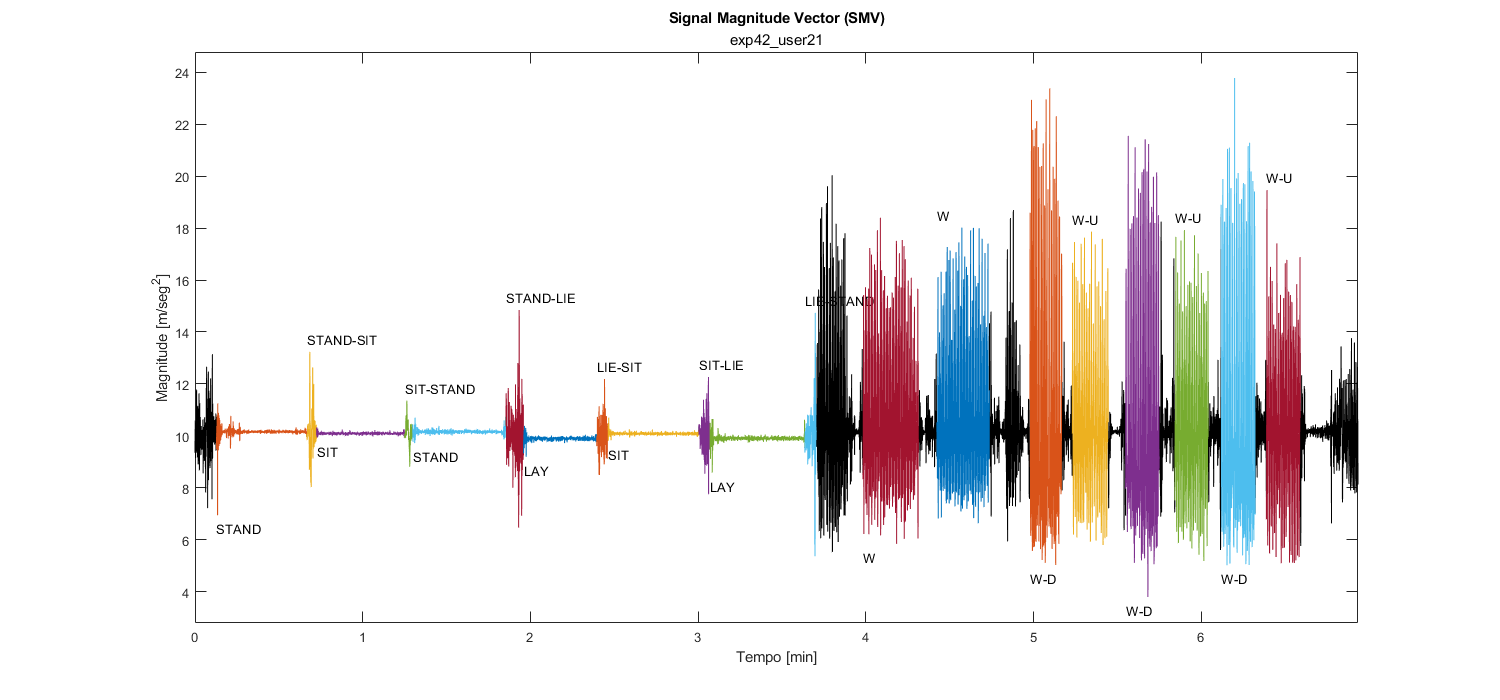

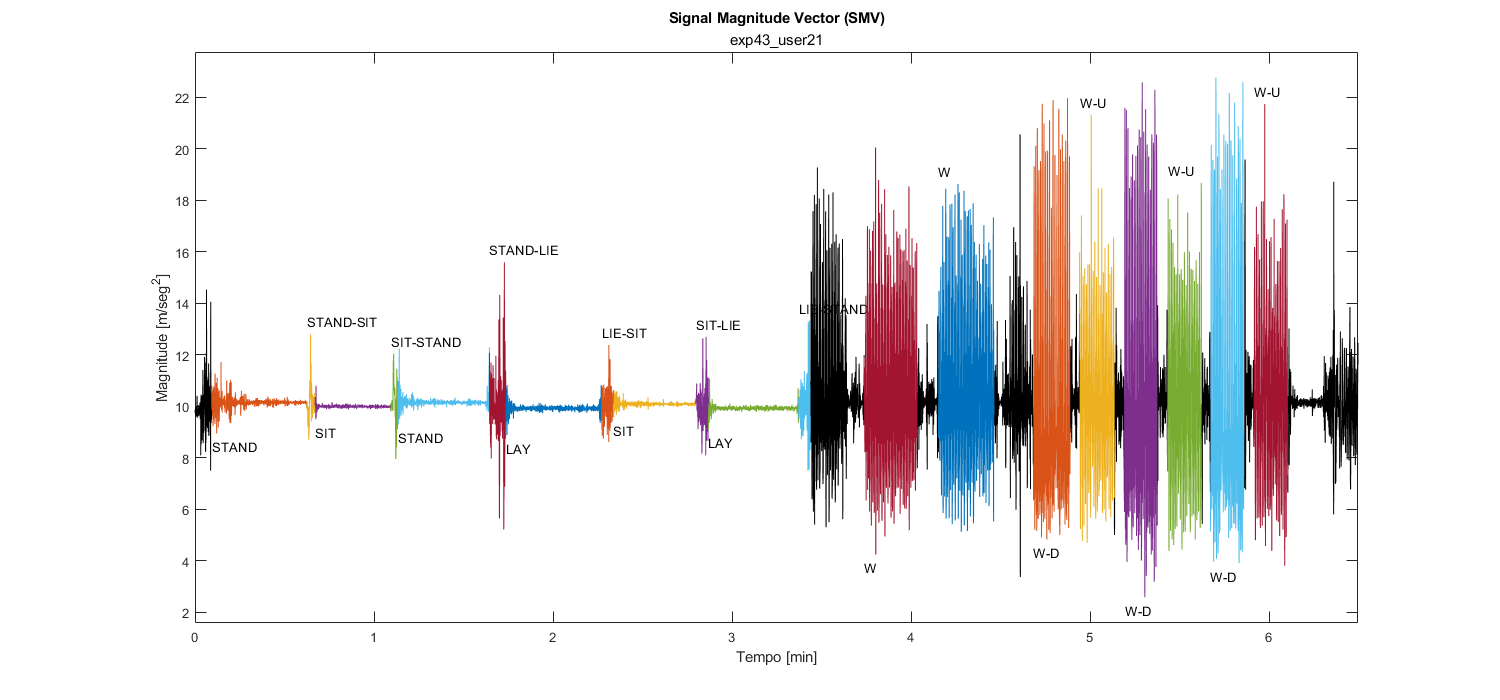

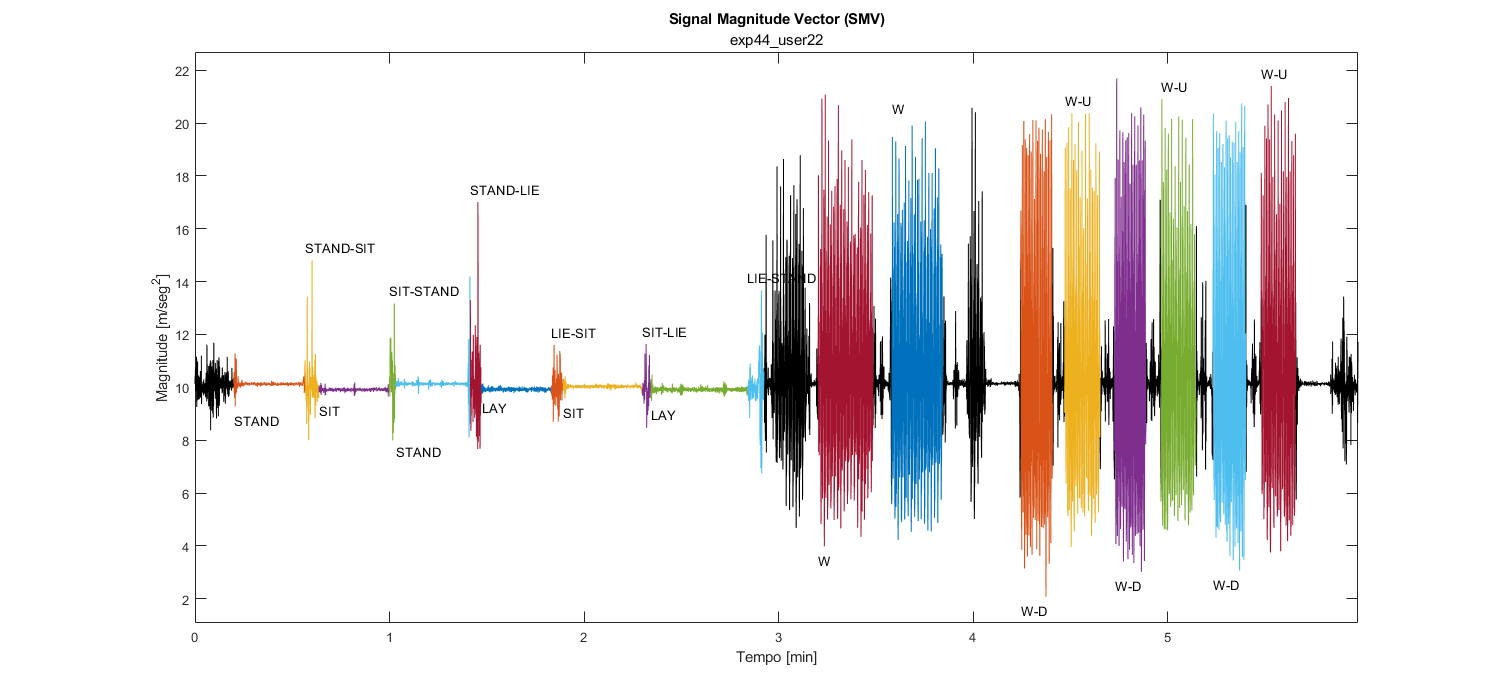

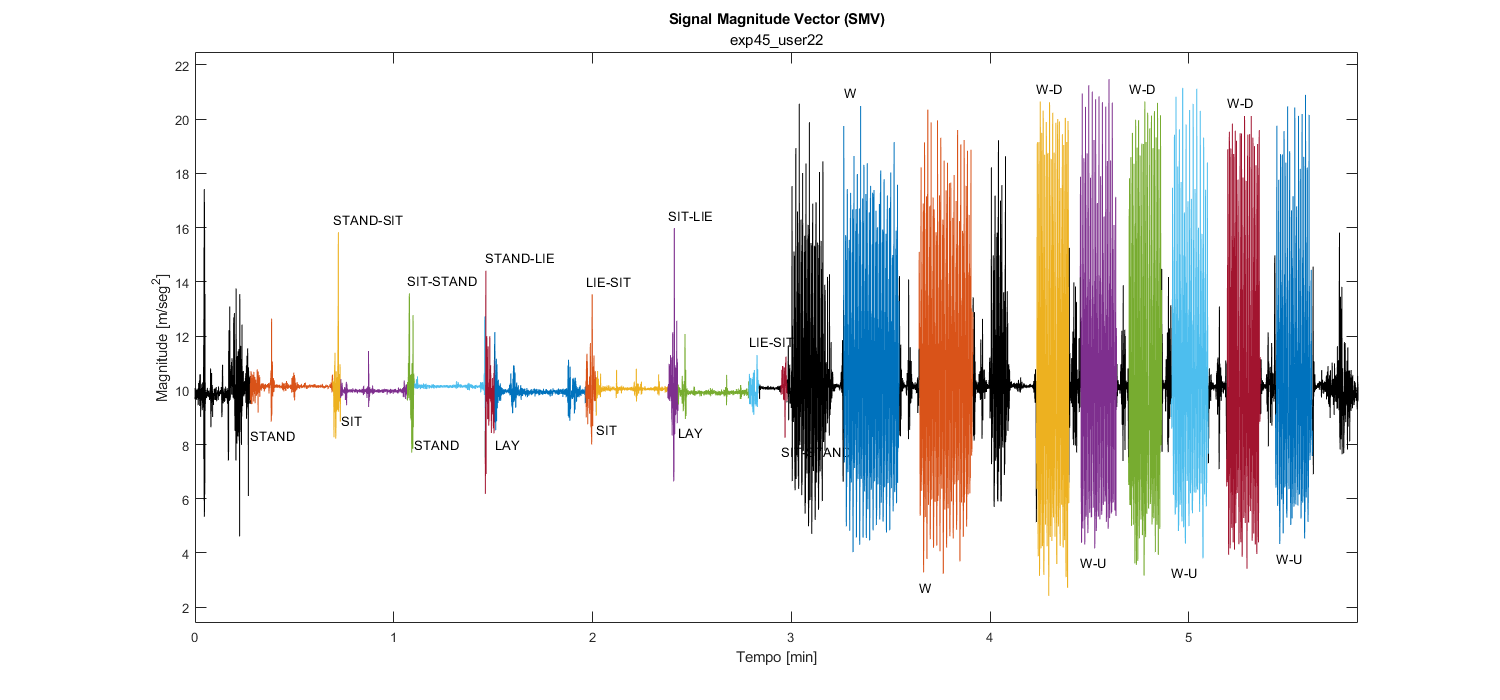

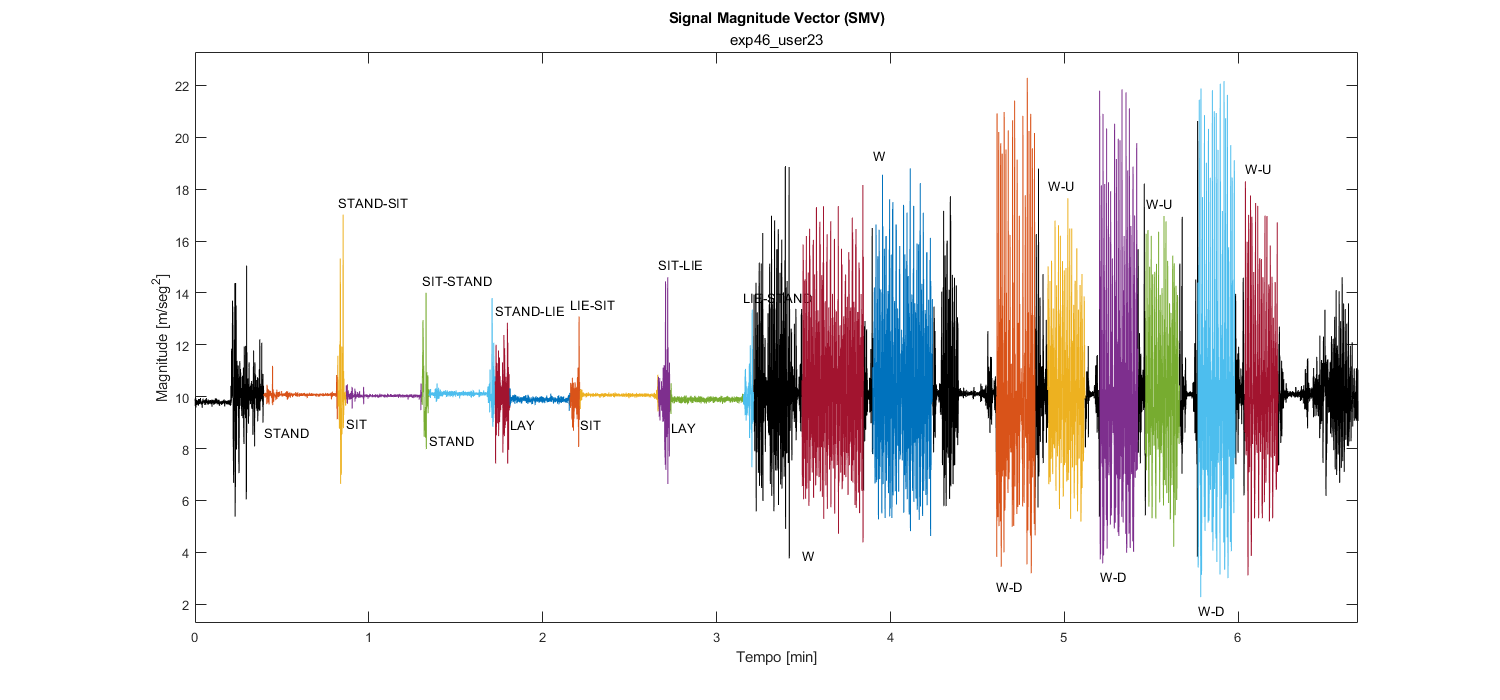

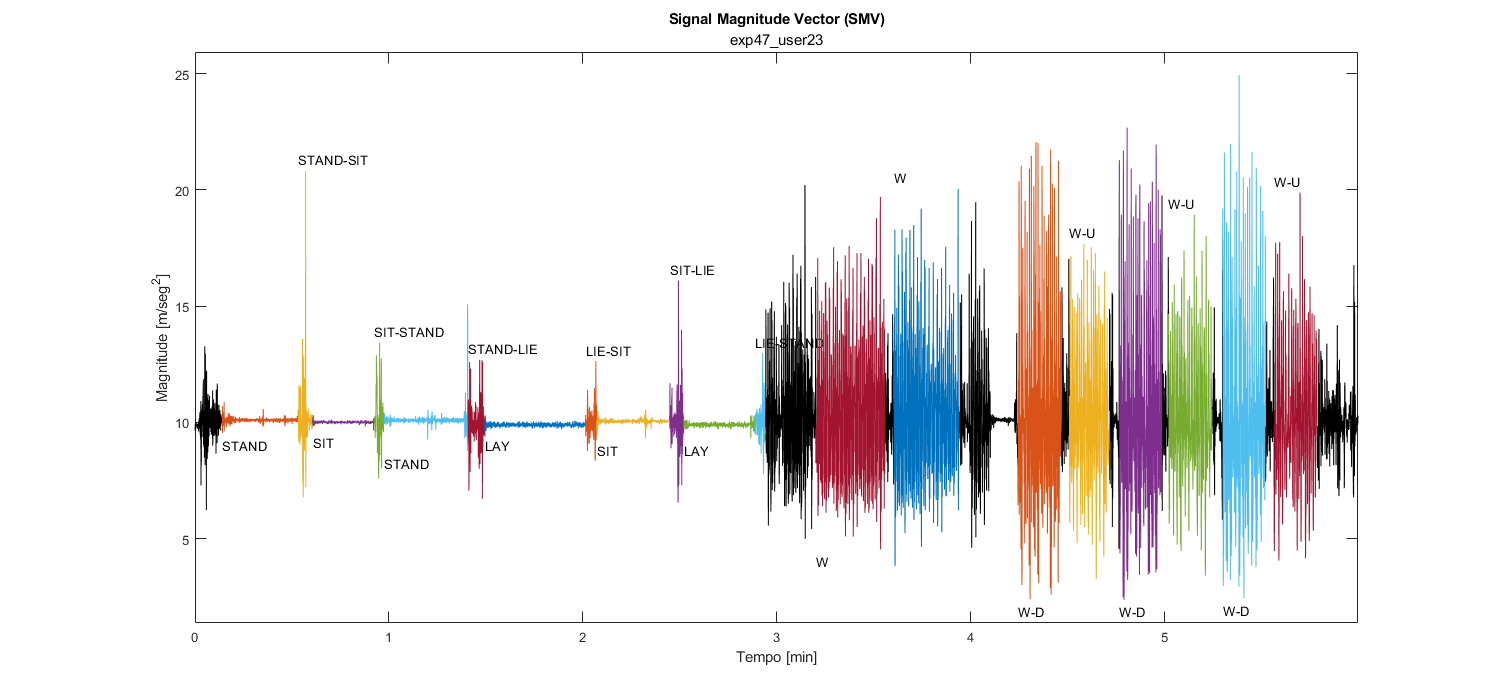

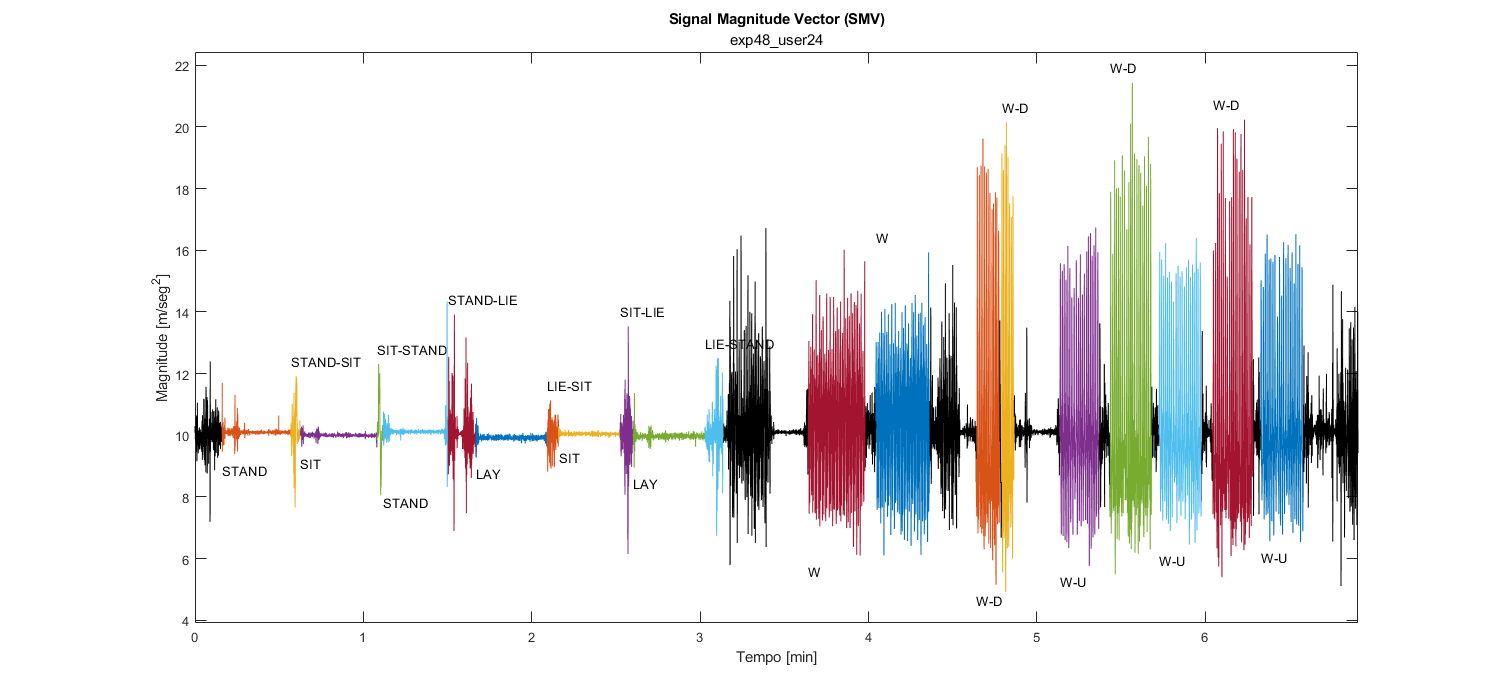

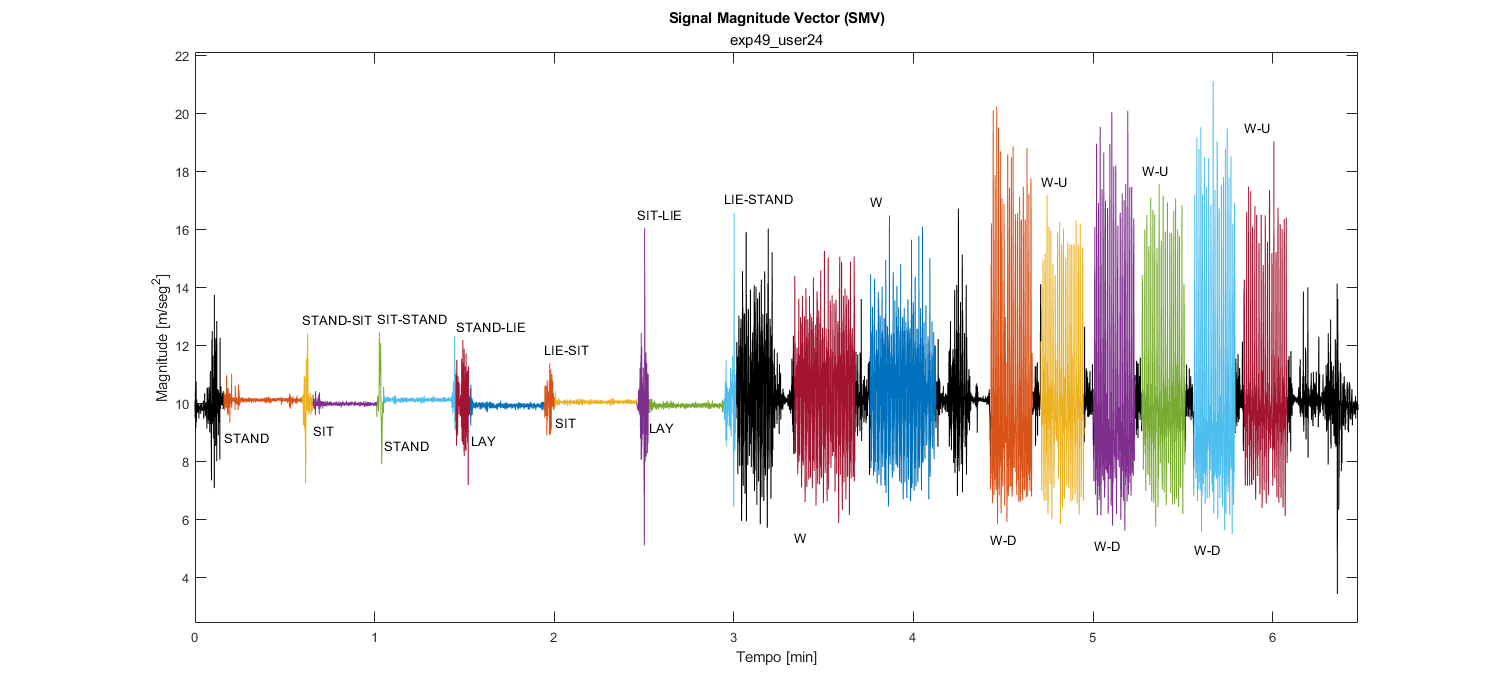

In [10]:
% "Signal Magniture Vector" - Referencia [2]

%plot -s 1500,700

% por cada ficheiro de dados
for iterData = 1 : countFichData
    data = eval(sprintf(formatoVarData, experimentID(iterData), userID(iterData)));
    dataActividades = eval(sprintf(formatoVarDataActividades, experimentID(iterData), userID(iterData)));
    
    % Readme.txt: "The units used for the accelerations (total and body) are 'g's (gravity of earth -> 9.80665 m/seg2)"
    data = data.*gravidade;
    
    % numero de valores amostrados, N
    countValoresData = length(data);

    countDataActividades = length(dataActividades);
    
    signalMagnitureVector = zeros(countValoresData, 1);
    
    % por cada valor de data
    % SMV(i) = sqrt( x(i)^2 + y(i)^2 + z(i)^2 )
    for iterValorData = 1 : countValoresData
        eixoX = data(iterValorData, 1).^2;
        eixoY = data(iterValorData, 2).^2;
        eixoZ = data(iterValorData, 3).^2;
        signalMagnitureVector(iterValorData) = sqrt(eixoX + eixoY + eixoZ);
    end
    
    % valores positivos
    n = 0 : countValoresData-1;

    % t = n * Ts | pra obter em minutos dividir por 60
    tempo = (n.*Ts)./(60);
            
    figure();
    % plot(x, y, black)
    plot(tempo, signalMagnitureVector, "k");

    valorMinAbsoluto = min(signalMagnitureVector) - 1.0;
    valorMaxAbsoluto = max(signalMagnitureVector) + 1.0;
    
    % Retain current plot when adding new plots
    hold on;
    
    % por cada actividade
    for iterActividade = 1 : countDataActividades
        % periodo da actividade
        periodoActividade = dataActividades(iterActividade, 2) : dataActividades(iterActividade, 3);
            
        % plot(x, y)
        plot(tempo(periodoActividade), signalMagnitureVector(periodoActividade));

        valorMinLocal = min(signalMagnitureVector(periodoActividade));
        valorMaxLocal = max(signalMagnitureVector(periodoActividade));

        % trocar posicoes legenda (cima e baixo)
        if mod(iterActividade, 2) == 0
            posicaoLegenda = valorMaxLocal + 0.5;
        else
            posicaoLegenda = valorMinLocal - 0.5;
        end

        % text(x, y, txt)
        text(tempo(dataActividades(iterActividade, 2)), posicaoLegenda, activityShortID(dataActividades(iterActividade, 1)));
            
        % Retain current plot when adding new plots
        hold on;
    end
    % axis([x-min x-max y-min y-max])
    axis([tempo(1) tempo(end) valorMinAbsoluto valorMaxAbsoluto]);
    title("Signal Magnitude Vector (SMV)");
    subtitle(sprintf(formatoVarDataPlot, experimentID(iterData), userID(iterData)));
    xlabel("Tempo [min]");
    ylabel("Magnitude [m/seg^2]");

    % guardar numa var
    nomeVar = sprintf(formatoVarDataSMV, experimentID(iterData), userID(iterData));
    assignin("base", nomeVar, signalMagnitureVector);
end

fprintf("\nVariáveis criadas:  var[SMV]\n");
for iterData = 1 : countFichData
    nomeVar = sprintf(formatoVarDataSMV, experimentID(iterData), userID(iterData));
    fprintf("\t> %s\n", nomeVar);
end

clear nomeVar countDataActividades countValoresData data dataActividades eixoX eixoY eixoZ iterActividade iterData iterValorData n periodoActividade posicaoLegenda signalMagnitureVector tempo valorMaxAbsoluto valorMaxLocal valorMinAbsoluto valorMinLocal;

Seguindo a sugestão em [2], para distinguir as atividades estáticas das atividades dinâmicas e de transição, calcula-se o vetor de magnitude do sinal.

Verifica-se que as atividades estáticas têm os valores mais baixos e constantes. As atividades dinâmicas possuem valores elevados e com muita variação ao longo do tempo. As atividades de transição têm um comportamento intermédio.

### 3.5. Identificar as características, por exemplo espectrais, que permitam distinguir cada tipo de atividade. Apresentar os resultados graficamente. Avaliar os resultados obtidos em termos de sensibilidade e especificidade.


Variáveis criadas:  var[ANGULO]
	> exp42_user21_angulos
	> exp43_user21_angulos
	> exp44_user22_angulos
	> exp45_user22_angulos
	> exp46_user23_angulos
	> exp47_user23_angulos
	> exp48_user24_angulos
	> exp49_user24_angulos



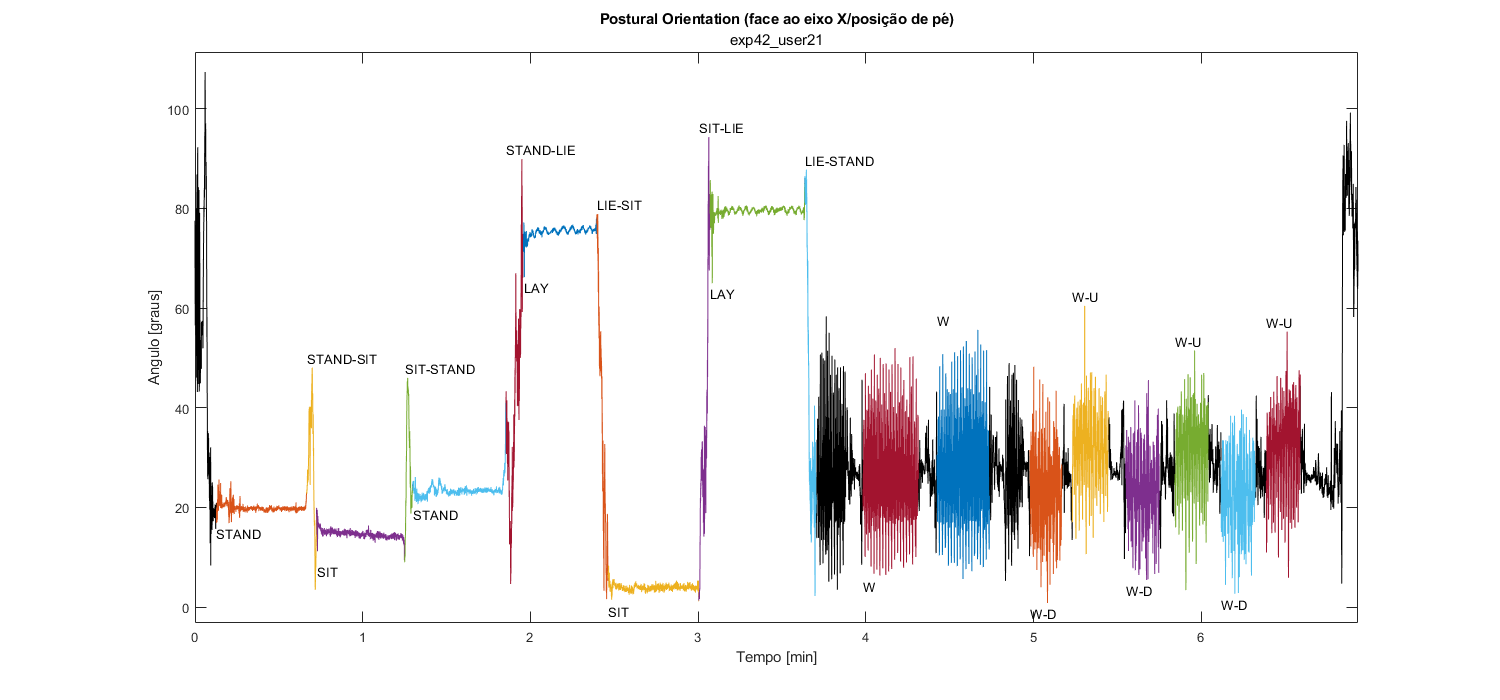

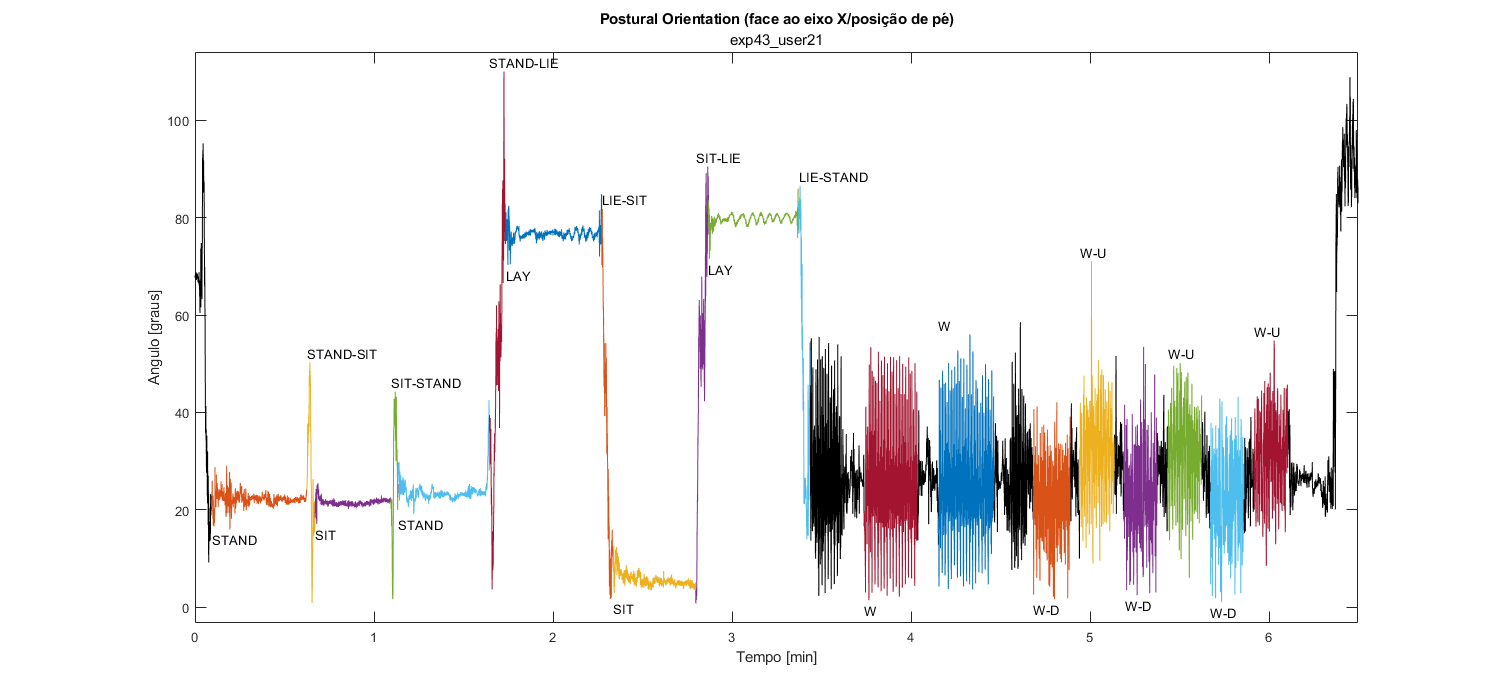

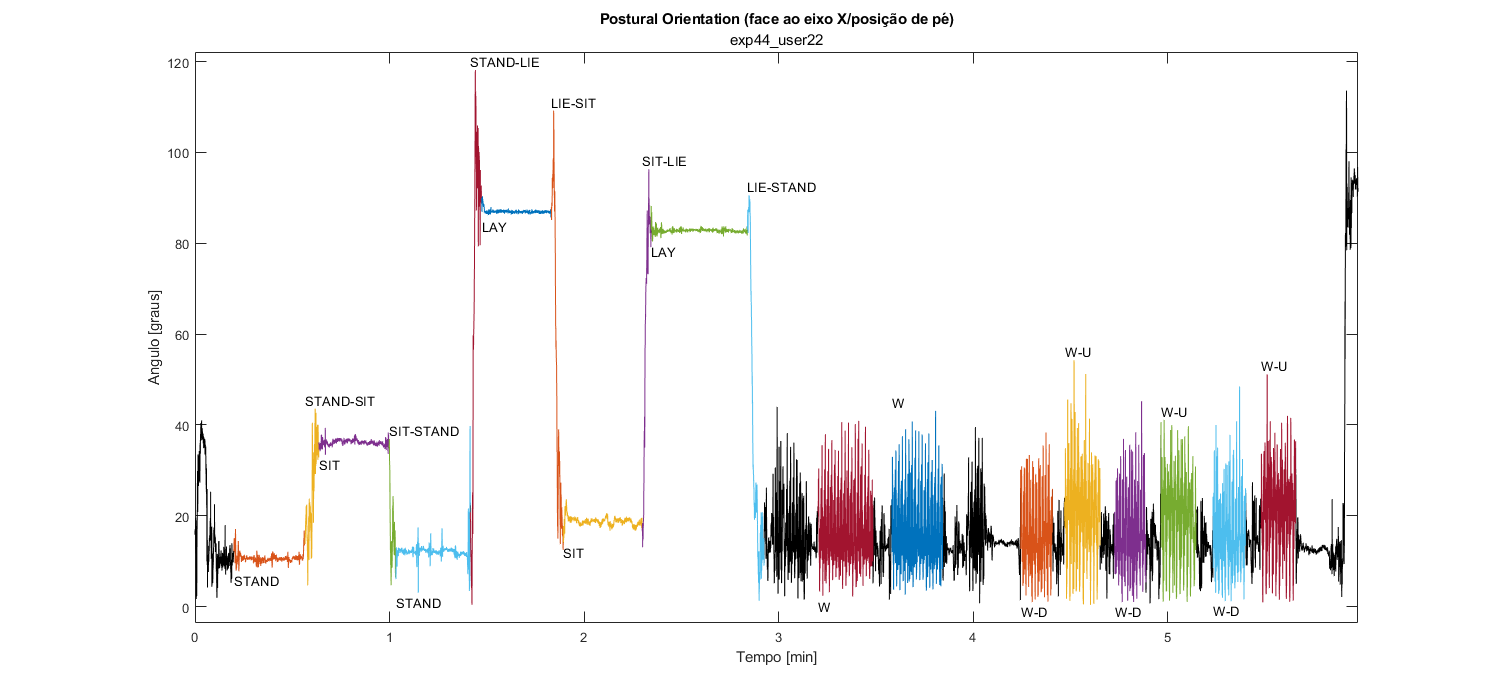

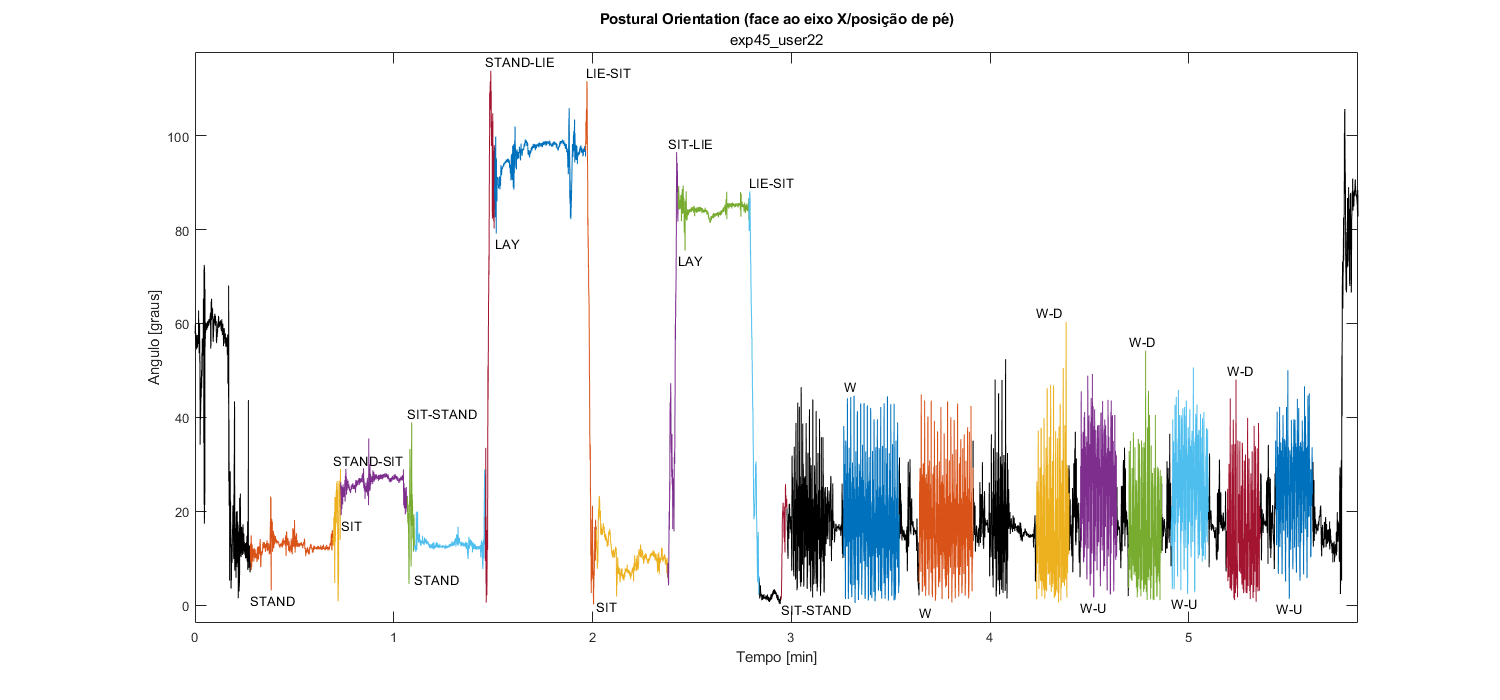

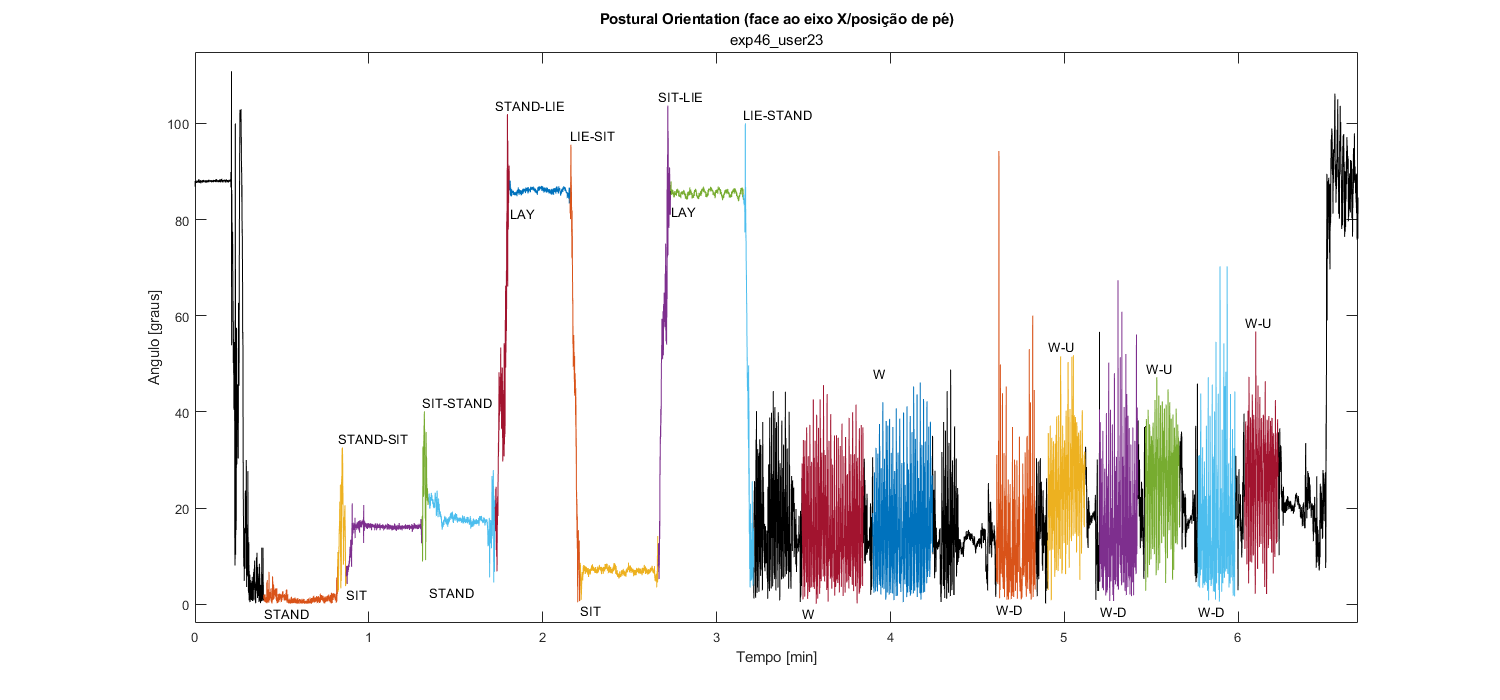

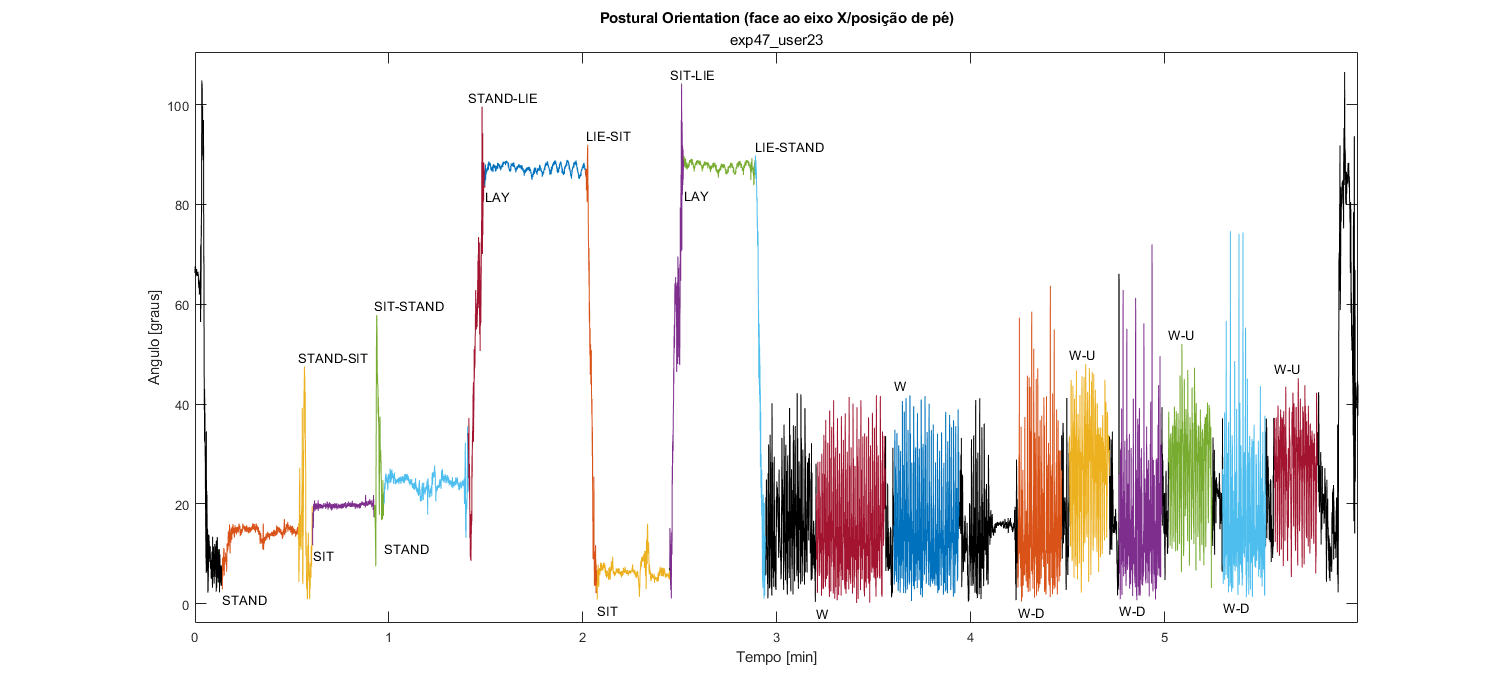

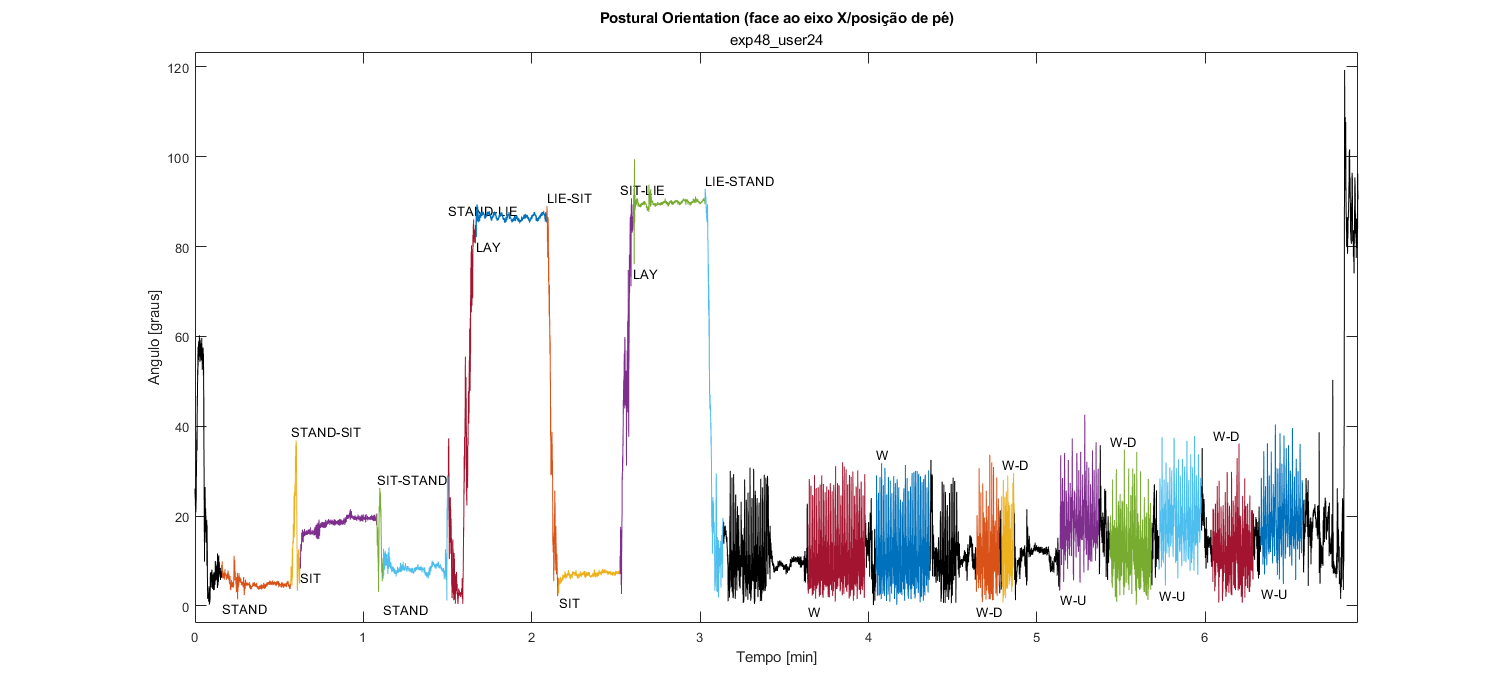

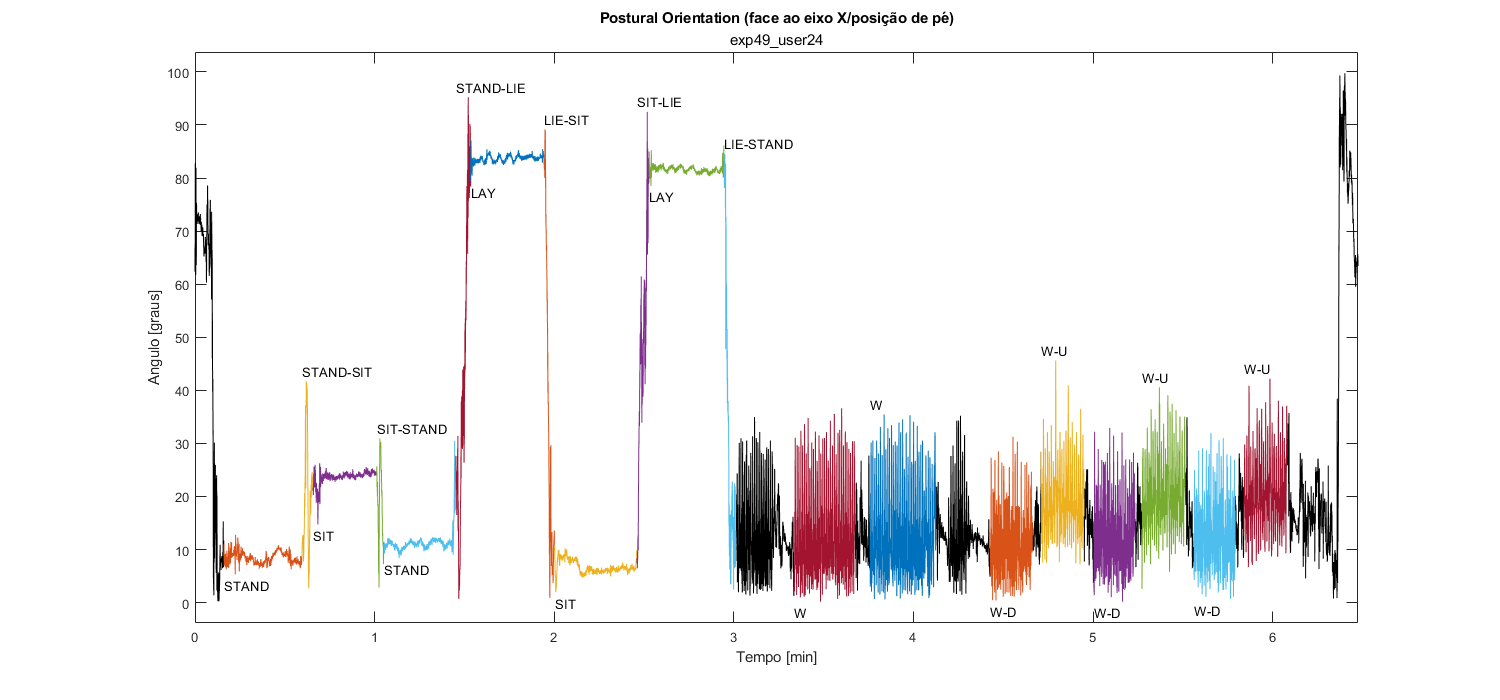

In [11]:
% "Postural Orientation" - Referencia [2]

%plot -s 1500,700

% por cada ficheiro de dados
for iterData = 1 : countFichData
    data = eval(sprintf(formatoVarData, experimentID(iterData), userID(iterData)));
    dataActividades = eval(sprintf(formatoVarDataActividades, experimentID(iterData), userID(iterData)));

    % Readme.txt: "The units used for the accelerations (total and body) are 'g's (gravity of earth -> 9.80665 m/seg2)"
    data = data.*gravidade;

    % numero de valores amostrados, N
    countValoresData = length(data);

    countDataActividades = length(dataActividades);
    
    % "accelerometer signal (x, y, z) when the user is in stand position (vector g = (x_stand, y_stand, z_stand)"
    gVetor = [1, 0, 0];
    
    angulos = zeros(countValoresData, 1);
    
    % por cada valor de data
    for iterValorData = 1 : countValoresData
        eixoX = data(iterValorData, 1);
        eixoY = data(iterValorData, 2);
        eixoZ = data(iterValorData, 3);
        
        % "vector with the accelerometer signal for each instance (vector v = (x, y, z)"
        vVetor = [eixoX, eixoY, eixoZ];
        
        % norm: Vector and matrix norms
        gNorma = norm(gVetor);
        vNorma = norm(vVetor);
        
        % dot: scalar dot product
        % acos: Inverse cosine in radians
        angulos(iterValorData) = acos(dot(vVetor, gVetor) / vNorma*gNorma) * (180/pi); % angulo em graus
    end
    
    % valores positivos
    n = 0 : countValoresData-1;

    % t = n * Ts | pra obter em minutos dividir por 60
    tempo = (n.*Ts)./(60);
            
    figure();
    % plot(x, y, black)
    plot(tempo, angulos, "k");

    valorMinAbsoluto = min(angulos) - 4.0;
    valorMaxAbsoluto = max(angulos) + 4.0;
    
    % Retain current plot when adding new plots
    hold on;

    % por cada actividade
    for iterActividade = 1 : countDataActividades
        % periodo da actividade
        periodoActividade = dataActividades(iterActividade, 2) : dataActividades(iterActividade, 3);
            
        % plot(x, y)
        plot(tempo(periodoActividade), angulos(periodoActividade));

        valorMinLocal = min(angulos(periodoActividade));
        valorMaxLocal = max(angulos(periodoActividade));

        % trocar posicoes legenda (cima e baixo)
        if mod(iterActividade, 2) == 0
            posicaoLegenda = valorMaxLocal + 2.0;
        else
            posicaoLegenda = valorMinLocal - 2.0;
        end

        % text(x, y, txt)
        text(tempo(dataActividades(iterActividade, 2)), posicaoLegenda, activityShortID(dataActividades(iterActividade, 1)));
            
        % Retain current plot when adding new plots
        hold on;
    end
    % axis([x-min x-max y-min y-max])
    axis([tempo(1) tempo(end) valorMinAbsoluto valorMaxAbsoluto]);
    title("Postural Orientation (face ao eixo X/posição de pé)");
    subtitle(sprintf(formatoVarDataPlot, experimentID(iterData), userID(iterData)));
    xlabel("Tempo [min]");
    ylabel("Angulo [graus]");

    % guardar numa var
    nomeVar = sprintf(formatoVarDataAngulos, experimentID(iterData), userID(iterData));
    assignin("base", nomeVar, angulos);
end

fprintf("\nVariáveis criadas:  var[ANGULO]\n");
for iterData = 1 : countFichData
    nomeVar = sprintf(formatoVarDataAngulos, experimentID(iterData), userID(iterData));
    fprintf("\t> %s\n", nomeVar);
end

clear nomeVar countDataActividades countValoresData data dataActividades eixoX eixoY eixoZ iterActividade iterData iterValorData n periodoActividade posicaoLegenda angulos tempo valorMaxAbsoluto valorMaxLocal valorMinAbsoluto valorMinLocal gNorma gVetor vVetor vNorma;

Seguindo a sugestão em [2], para distinguir as diferentes atividades, mede-se o ângulo entre o vetor do eixo `ACC X`, que corresponde a um utilizador a estar de pé (imobilizado), com o vetor que represente uma determinada atividade no tempo.

A partir dos gráficos verifica-se que atividades com ângulos estáveis inferiores a 20 graus são do tipo *stand*, com ângulos estáveis entre os 20 e os 60 graus são do tipo *sit*, e as atividades com ângulos estáveis superiores 60 graus são do tipo *lay*. As atividade de transição identificam-se pela transição entre o ângulo inicial e o ângulo final. Dentro das atividades dinâmicas, todas possuem muita instabilidade, mas, empiricamente, o valor médio do ângulo durante o período da atividade é mais elevado em atividades do tipo *walking upstairs* e mais baixo em atividades do tipo *walking downstairs*.

### 4. Obter computacionalmente as distribuições tempo-frequência para o sinal do acelerómetro no “eixo Z” para um ficheiro de dados à sua escolha. Usar a Short-Time Fourier Transform (STFT).

### 4.1. Escolher, justificadamente, a janela a considerar na aplicação da STFT. Para isso, selecionar uma atividade dinâmica e usar diferentes tipos de janela para segmentar o sinal associado a essa atividade. Calcular a DFT do segmento com as diferentes janelas e comparar os resultados obtidos, procurando evidenciar o efeito das diferentes janelas.

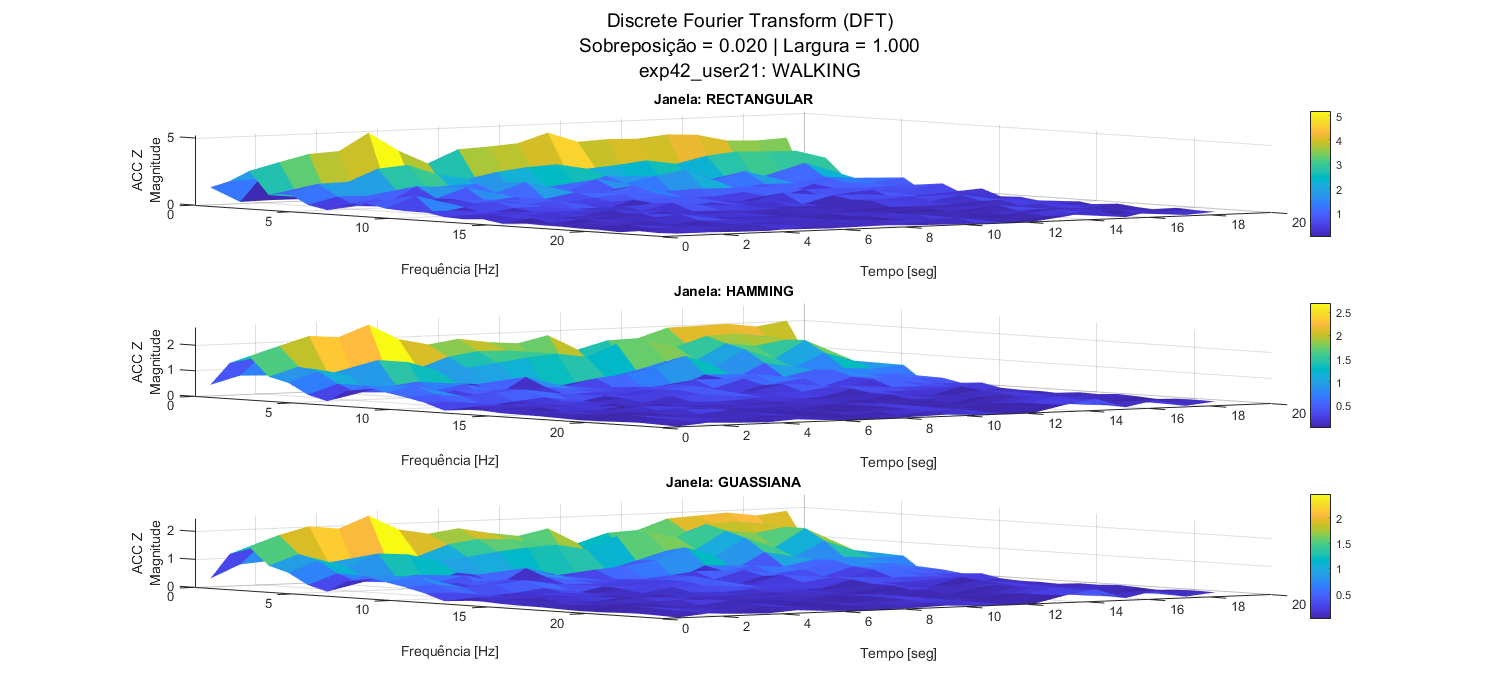

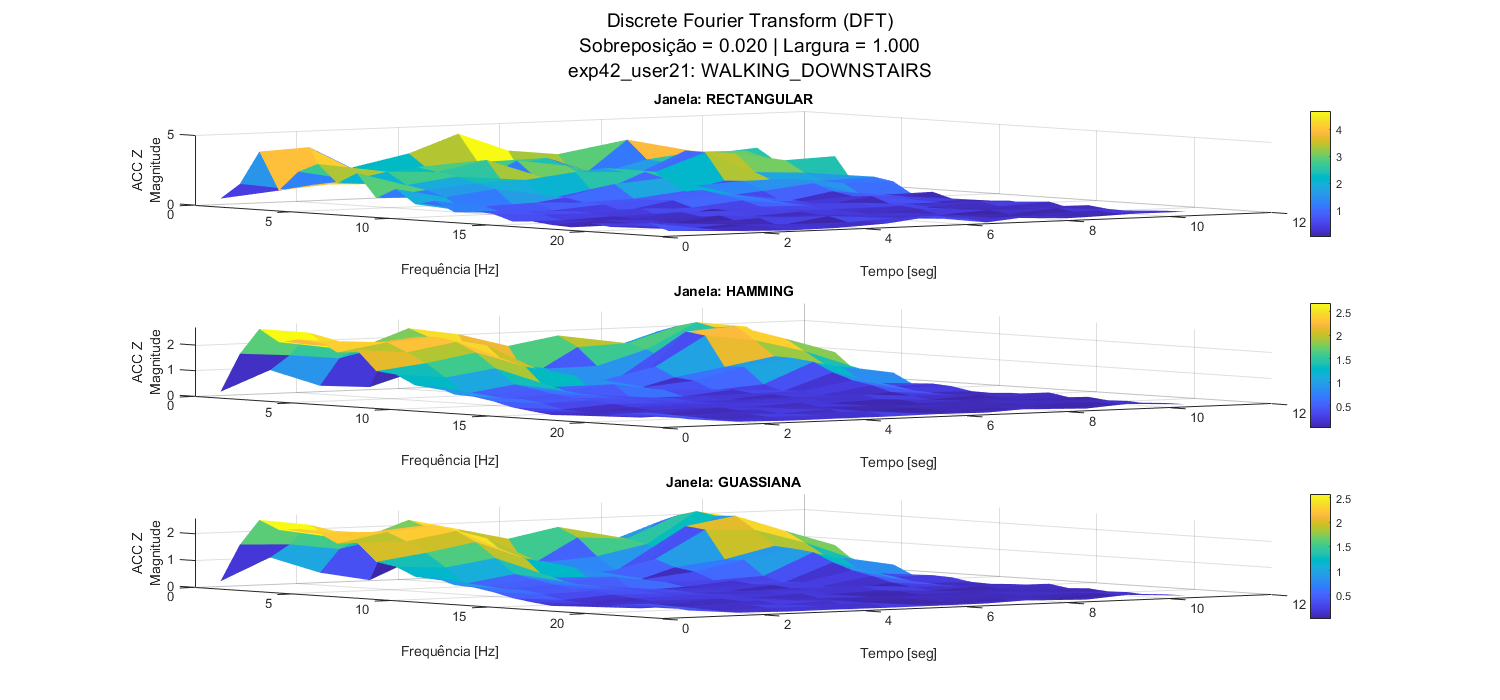

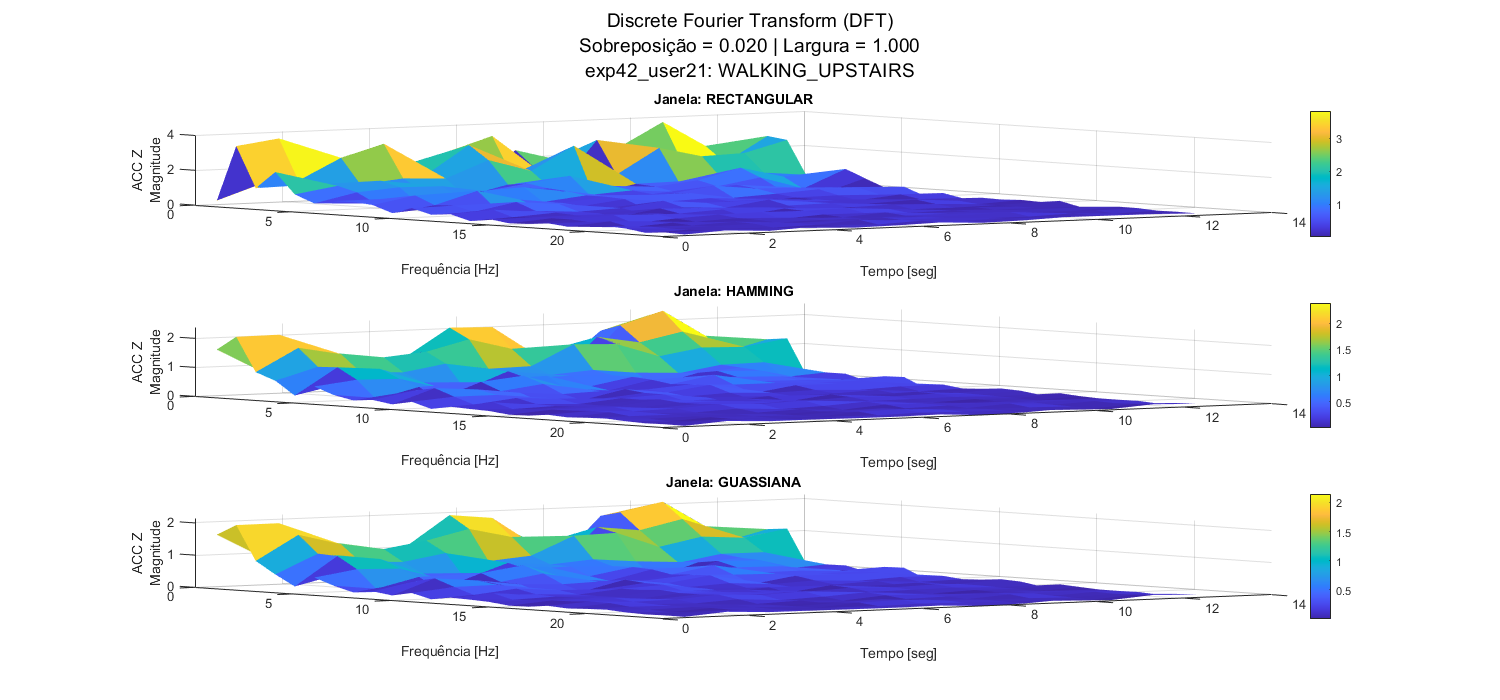

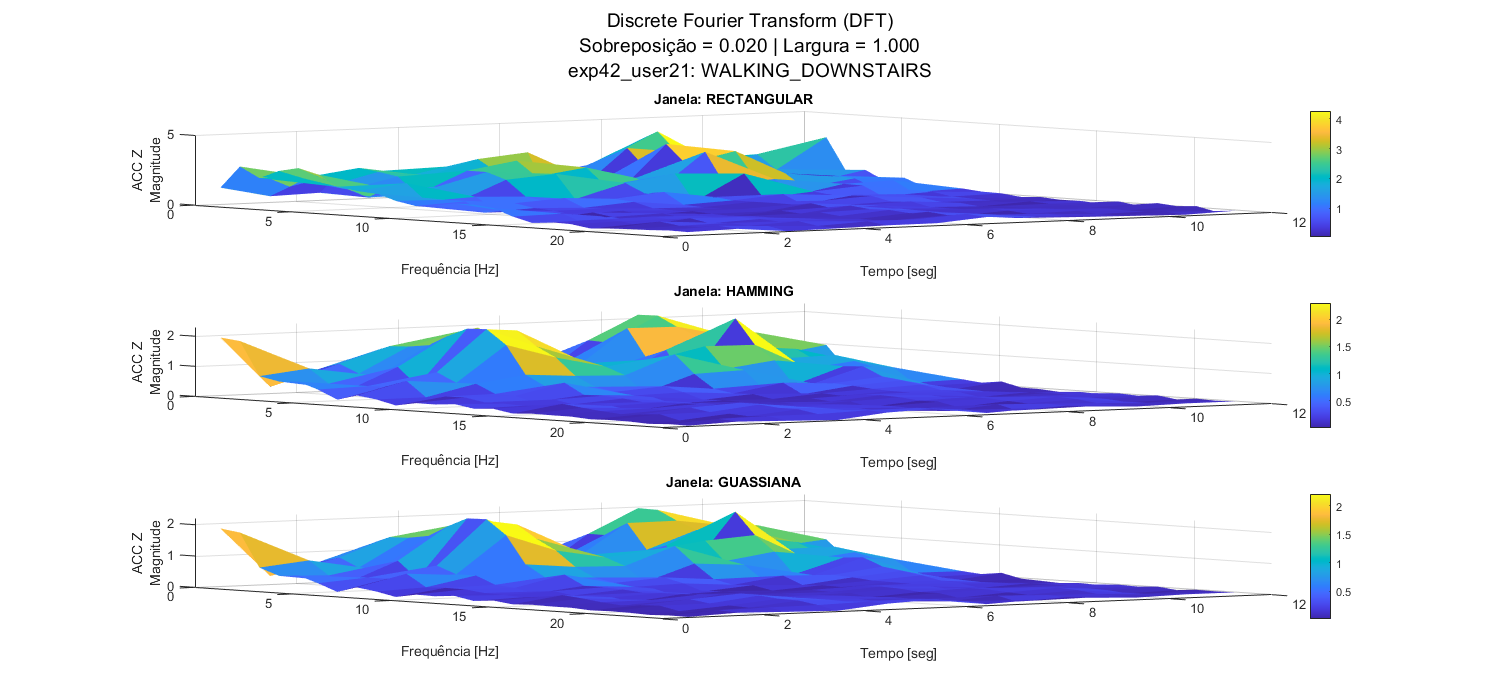

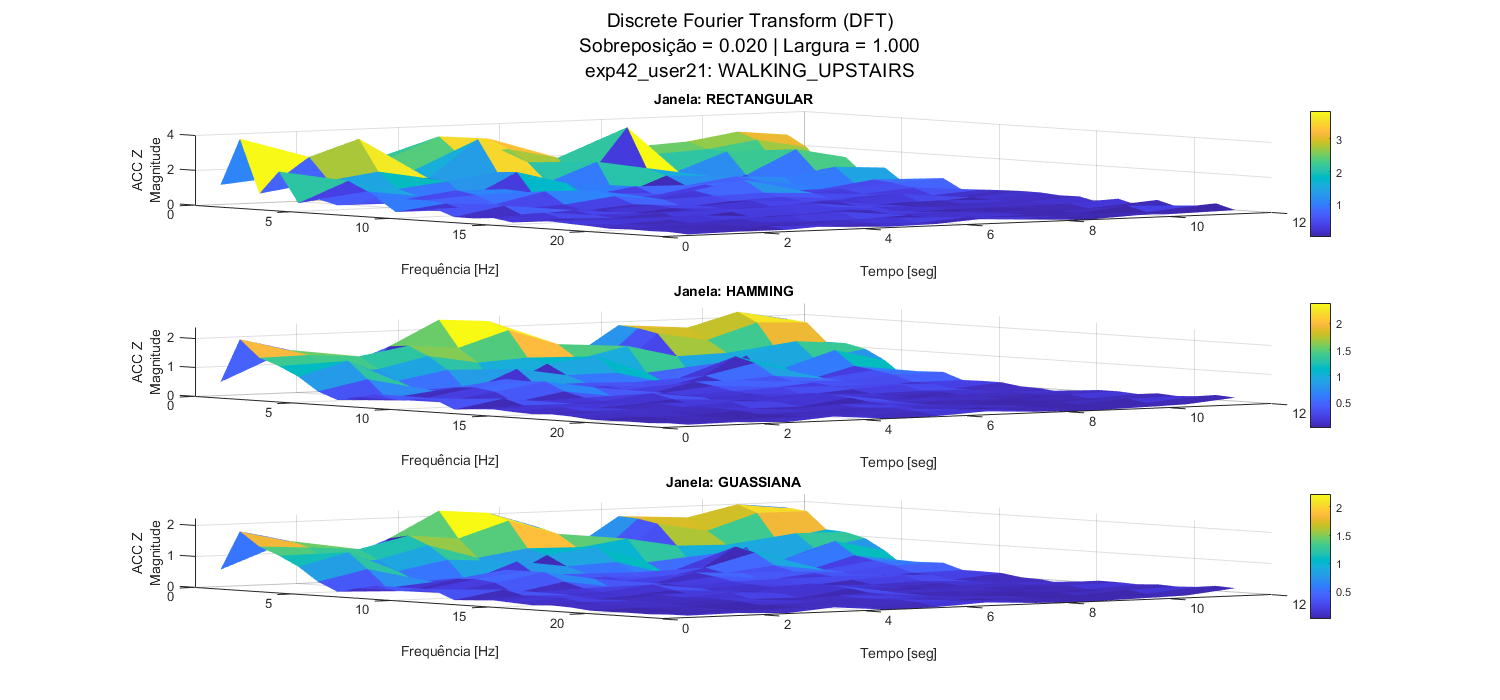

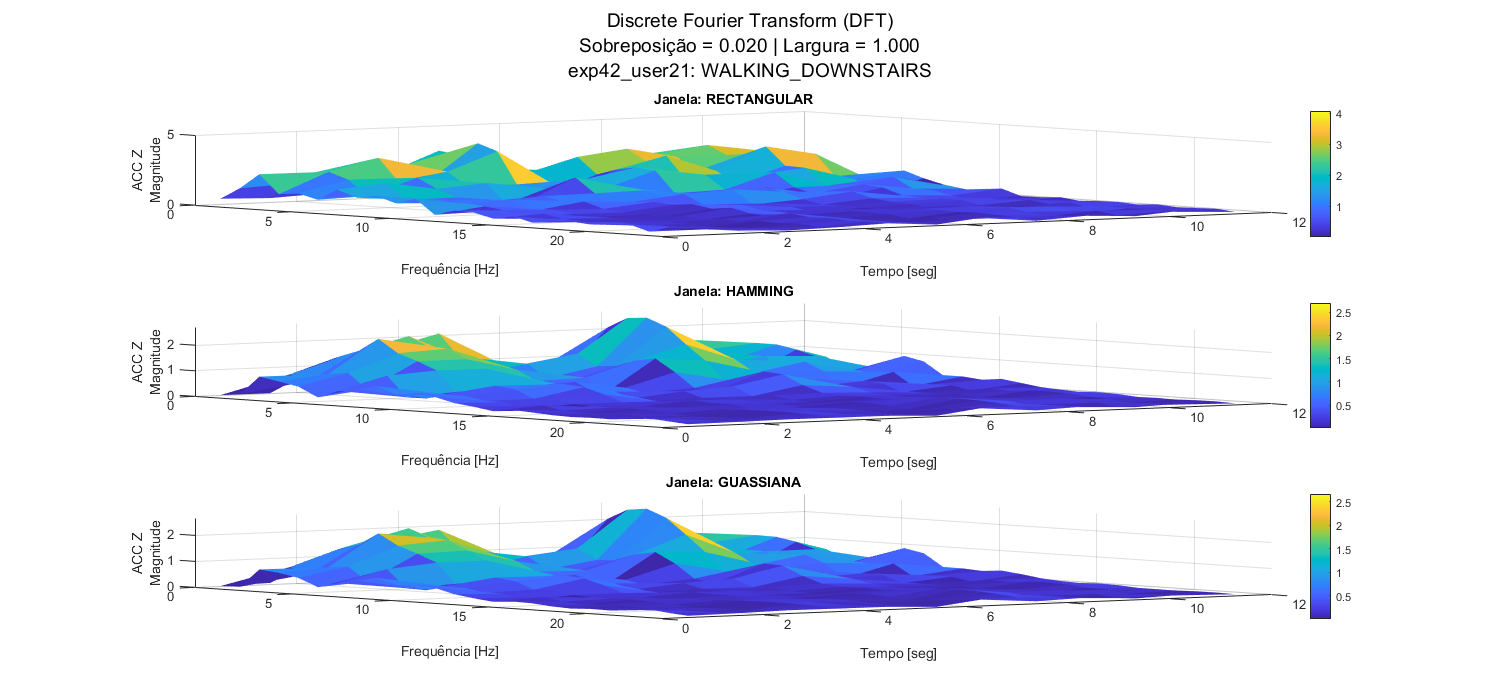

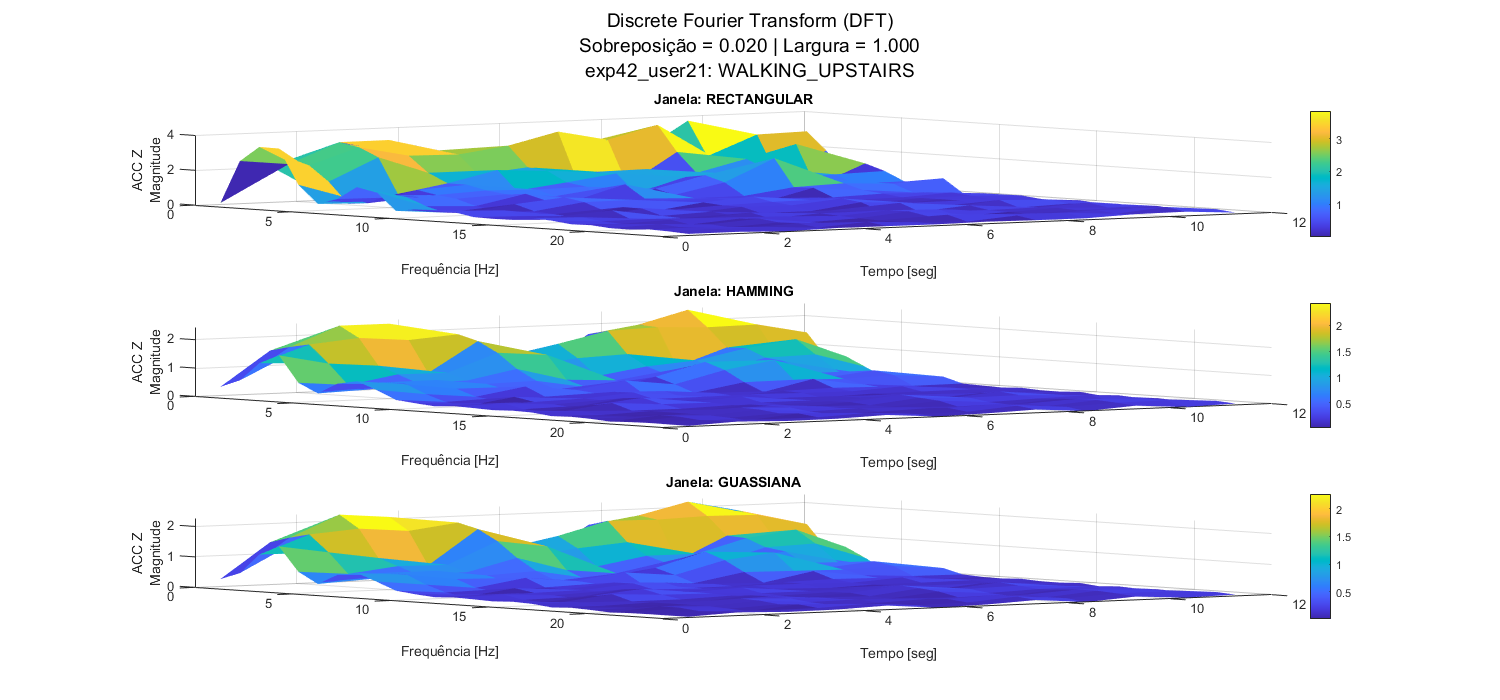

In [19]:
% ########## PARAMETROS: ##########
% > ARRAY COM OS INDICES DOS FICHEIROS DE DADOS A ANALISAR, ex.: [1 3 4 ... n]:
listaData = [1];

% > ARRAY COM OS INDICES DAS ATIVIDADES A ANALISAR, ex.: [4 10 13 ... n]:
listaDataActividades = [14 15 16 17 18 19 20];

% > ESCOLHER SENSOR (1 A 3), ex.: 3, ACC Z
sensor = 3;

% > INTERVALO DE TEMPO, EM SEGUNDOS, DA SOBREPOSIÇÃO ENTRE JANELAS
tempoSobreposicaoJanelas = 0.02;

% > INTERVALO DE TEMPO, EM SEGUNDOS, DA LARGURA DA JANELA
tempoLarguraJanela = 1.0;
% #################################


%plot -s 1500,700

% Nota: Se os arrays estiverem vazios, a analise é feita a todo o dataset
if isempty(listaData)
    listaData = 1 : countFichData;
end

% Nota: 1 a 3, evitar ArrayIndexOutOfBoundsException
if sensor > countSensores || sensor < 1
    fprintf("Aviso: Não existe nenhum sensor com indice %d (limites: 1 a %d). Alterado para 3 (%s).\n", sensor, countSensores, sensorID(3));
    sensor = 3; % ACC Z
end

% numero de amostras = tempo * fs
% Periodo Fundamental, N
countAmostrasLarguraJanela = round(tempoLarguraJanela * fs);
                
% numero de amostras = tempo * fs
countAmostrasSobreposicaoJanelas = round(tempoSobreposicaoJanelas * fs);
                
% dominioFrequencia  ==  ( -N/2 : -N/2 ) * f0  ==  ( -N/2 : -N/2 ) * fs / N  ==  ( -fs/2 : -fs/2 )   (N, Periodo)
if mod(countAmostrasLarguraJanela, 2) == 0
    dominioFrequencia = -fs/2 : fs/countAmostrasLarguraJanela : fs/2 - fs/countAmostrasLarguraJanela;
else
    dominioFrequencia = -fs/2 + fs/(2*countAmostrasLarguraJanela) : fs/countAmostrasLarguraJanela : fs/2 - fs/(2*countAmostrasLarguraJanela);
end

countDominioFrequencia = length(dominioFrequencia);

% por cada ficheiro de dados
for iterData = listaData
    if iterData <= countFichData && iterData > 0
        data = eval(sprintf(formatoVarData, experimentID(iterData), userID(iterData)));
        dataActividades = eval(sprintf(formatoVarDataActividades, experimentID(iterData), userID(iterData)));
    
        countDataActividades = length(dataActividades);
    
        % Nota: Se os arrays estiverem vazios, a analise é feita a todo o dataset
        if isempty(listaDataActividades)
            listaDataActividades = 1 : countDataActividades;
        end
        
        % por cada actividade
        for iterActividade = listaDataActividades
            if iterActividade <= countDataActividades && iterActividade > 0
                figure();
                sgtitle({"Discrete Fourier Transform (DFT)" ; sprintf("Sobreposição = %.3f | Largura = %.3f", tempoSobreposicaoJanelas, tempoLarguraJanela) ; sprintf(formatoVarData, experimentID(iterData), userID(iterData)) + ": " + activityID(dataActividades(iterActividade, 1))}, 'Interpreter', 'none');
                
                % detrend: remove polynomial trend
                dataDetrend = detrend(data(dataActividades(iterActividade, 2) : dataActividades(iterActividade, 3), sensor));

                countAmostrasDataActividade = length(dataDetrend);
                
                % lista de janelas
                listaJanelas =  1 : countAmostrasLarguraJanela - countAmostrasSobreposicaoJanelas : countAmostrasDataActividade - countAmostrasLarguraJanela;
                countJanelas = length(listaJanelas);

                % linspace: Generate linearly spaced vector
                vetorTempo = linspace(0, (countAmostrasDataActividade - 1)/fs, countAmostrasDataActividade);

                % por cada tipo de janela
                for iterTipoJanela = 1 : countTiposJanela
                pontosMedioTempoJanela = zeros(countJanelas, 1);
                    
                    % coefsDFT(x, y)
                    coefsDFT = zeros(countJanelas, countDominioFrequencia);

                    % rectwin(L): returns a rectangular window of length L, https://www.mathworks.com/help/signal/ref/rectwin.html
                    % hamming(L): returns an L-point symmetric Hamming window, https://www.mathworks.com/help/signal/ref/hamming.html
                    % gausswin(L): returns an L-point Gaussian window, https://www.mathworks.com/help/signal/ref/gausswin.html
                    funcaoTipoJanela =  eval("@" + tipoJanelaID(iterTipoJanela));
                    valoresFuncaoTipoJanela = funcaoTipoJanela(countAmostrasLarguraJanela);
                    
                    iterJanela = 1;
                    % por cada janela
                    for iterListaJanelas = listaJanelas
                        % janela = excerto da data * valoresFuncaoTipoJanela
                        janela = dataDetrend(iterListaJanelas : iterListaJanelas + countAmostrasLarguraJanela - 1).*valoresFuncaoTipoJanela;
    
                        % Referencia: https://www.mathworks.com/help/signal/ug/discrete-fourier-transform.html
                        % fft: Fast Fourier transform
                        % fftshift: Shift zero-frequency component to center of spectrum
                        coefsDFT(iterJanela, :) = abs(fftshift(fft(janela)));

                        vetorTempoJanela = vetorTempo(iterListaJanelas : iterListaJanelas + countAmostrasLarguraJanela - 1);

                        % ponto medio valor temporal
                        pontosMedioTempoJanela(iterJanela) = vetorTempoJanela(round(countAmostrasLarguraJanela/2) + 1);

                        iterJanela = iterJanela + 1;
                    end

                    % [X, Y] = meshgrid(X, Y): 2-D and 3-D grids
                    [pontosMedioTempoJanelaMeshgrid, dominioFrequenciaMeshgrid] = meshgrid(pontosMedioTempoJanela, dominioFrequencia);
                    
                    % subplot(m, n, p): m-by-n grid, position p
                    subplot(countTiposJanela, 1, iterTipoJanela);
                    
                    % surf(X, Y, Z): Surface plot
                    grafico = surf(pontosMedioTempoJanelaMeshgrid, dominioFrequenciaMeshgrid, coefsDFT');
                    
                    % Colorbar showing color scale
                    colorbar;

                    % Color of box outline
                    grafico.EdgeColor = 'none';

                    % Inverter eixo Y (Freq.)
                    set(gca,'Ydir','reverse');

                    title("Janela: " + tipoJanelaPlotID(iterTipoJanela));

                    % ylim([y-min y-max])
                    ylim([0 max(dominioFrequencia)]);
                    
                    xlabel("Tempo [seg]");
                    ylabel("Frequência [Hz]");
                    zlabel({sensorID(sensor) ; "Magnitude"});
                end
            else
                % evitar ArrayIndexOutOfBoundsException
                fprintf("Aviso: O ficheiro %s não tem a atividade com indice %d (max: %d)\n", sprintf(formatoVarData, experimentID(iterData), userID(iterData)), iterActividade, countDataActividades);
            end
        end
    else
        % evitar ArrayIndexOutOfBoundsException
        fprintf("Aviso: Não existe nenhum ficheiro com indice %d (max: %d)\n", iterData, countFichData);
    end
end

clear coefsDFT countAmostrasDataActividade countAmostrasLarguraJanela countAmostrasSobreposicaoJanelas countDataActividades countDominioFrequencia countJanelas data dataActividades dataDetrend dominioFrequencia dominioFrequenciaMeshgrid funcaoTipoJanela grafico iterActividade iterData iterJanela iterListaJanelas iterTipoJanela janela listaData listaDataActividades listaJanelas pontosMedioTempoJanelaMeshgrid pontosMedioTempoJanela sensor tempoLarguraJanela tempoSobreposicaoJanelas valoresFuncaoTipoJanela vetorTempoJanela vetorTempo;

Para evitar o efeito *Spectral Leakage*, é aplicada uma função (`hamming` ou `guassiana`) à janela. Nesta fase, com a ajuda dos gráficos, é possível perceber a variação e a suavidade na transição das frequências mais relevantes numa janela ao longo do tempo. Também é possível escolher o intervalo de tempo corrrespondente à largura da janela e à sobreposição de janelas.

De facto, a aplicação das funções (`hamming` ou `guassiana`) à janela, permitem focar nos valores do centro da janela, e consequentemente resultar em menos transições abruptas entre janelas. Além disso, produz uma atenuação dos valores da magnitude das frequências.

Alterar o intervalo de tempo corrrespondente à largura da janela e à sobreposição de janelas tem impacto na resolução espectral e na resolução temporal. São inversamente proporcionais, quando se aumenta uma, a outra parde resolução.

### 4.2. Desenvolver a sua própria função para o cálculo da STFT.

In [20]:
%%file calcSTFT.m
function [outPontosMedioTempo, outSTFT] = calcSTFT(data, fs, valoresFuncaoTipoJanela, countAmostrasSobreposicaoJanelas, countAmostrasLarguraJanela)
    countAmostrasData = length(data);
                
    % dominioFrequencia  ==  ( -N/2 : -N/2 ) * f0  ==  ( -N/2 : -N/2 ) * fs / N  ==  ( -fs/2 : -fs/2 )   (N, Periodo)
    if mod(countAmostrasLarguraJanela, 2) == 0
        dominioFrequencia = -fs/2 : fs/countAmostrasLarguraJanela : fs/2 - fs/countAmostrasLarguraJanela;
    else
        dominioFrequencia = -fs/2 + fs/(2*countAmostrasLarguraJanela) : fs/countAmostrasLarguraJanela : fs/2 - fs/(2*countAmostrasLarguraJanela);
    end
                
    % lista de janelas
    listaJanelas =  1 : countAmostrasLarguraJanela - countAmostrasSobreposicaoJanelas : countAmostrasData - countAmostrasLarguraJanela;
    countJanelas = length(listaJanelas);

    % linspace: Generate linearly spaced vector
    vetorTempo = linspace(0, (countAmostrasData - 1)/fs, countAmostrasData);

    if countAmostrasData / fs > 30
        vetorTempo = vetorTempo./60;
    end

    outSTFT = zeros(countJanelas, 1);
    outPontosMedioTempo = zeros(countJanelas, 1);
                    
    iterJanela = 1;
    % por cada janela
    for iterListaJanelas = listaJanelas
        % janela = excerto da data * valoresFuncaoTipoJanela
        janela = data(iterListaJanelas : iterListaJanelas + countAmostrasLarguraJanela - 1).*valoresFuncaoTipoJanela;

        % Referencia: https://www.mathworks.com/help/signal/ug/discrete-fourier-transform.html
        % fft: Fast Fourier transform
        % fftshift: Shift zero-frequency component to center of spectrum
        janelaCoefsDFT = abs(fftshift(fft(janela)));
        
        % encontrar a frequencia mais relevante
        frequenciaRelevante = dominioFrequencia(janelaCoefsDFT == max(janelaCoefsDFT));

        % guardar valor da frequencia, ignorar valor negativo
        outSTFT(iterJanela) =  frequenciaRelevante(frequenciaRelevante >= 0);

        % valores de tempo desta janela
        vetorTempoJanela = vetorTempo(iterListaJanelas : iterListaJanelas + countAmostrasLarguraJanela - 1);

        % guardar ponto medio valor temporal desta janela
        outPontosMedioTempo(iterJanela) = vetorTempoJanela(round(countAmostrasLarguraJanela/2) + 1);

        iterJanela = iterJanela + 1;
    end

    % plot(x, y)
    plot(outPontosMedioTempo, outSTFT, "bo");
    title("STFT");
    if countAmostrasData / fs > 30
        xlabel("Tempo [min]");
    else
        xlabel("Tempo [seg]");
    end
    ylabel("Frequência [Hz]");
    grid on;
end

Created file 'C:\Users\Asus\OneDrive\Documentos\GitHub\ATD-Projeto-2022\Projeto\jupyterNotebook\calcSTFT.m'.


### 4.3. Aplicar a STFT ao sinal com a janela deslizante selecionada, usando os parâmetros corretos para visualizar de forma conveniente as diferentes atividades, não descorando a visualização apropriada da “assinatura” espectral de cada uma delas. Avaliar os resultados obtidos em termos de sensibilidade e especificidade.

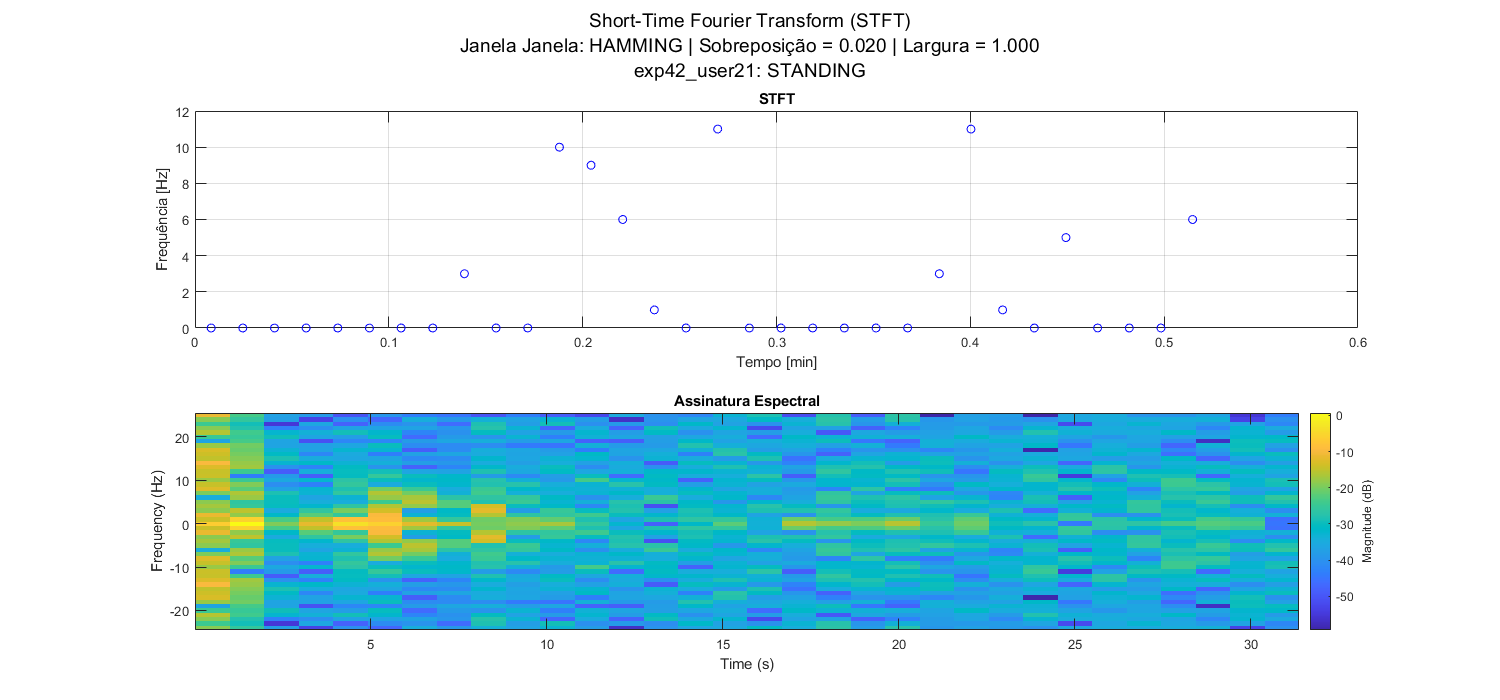

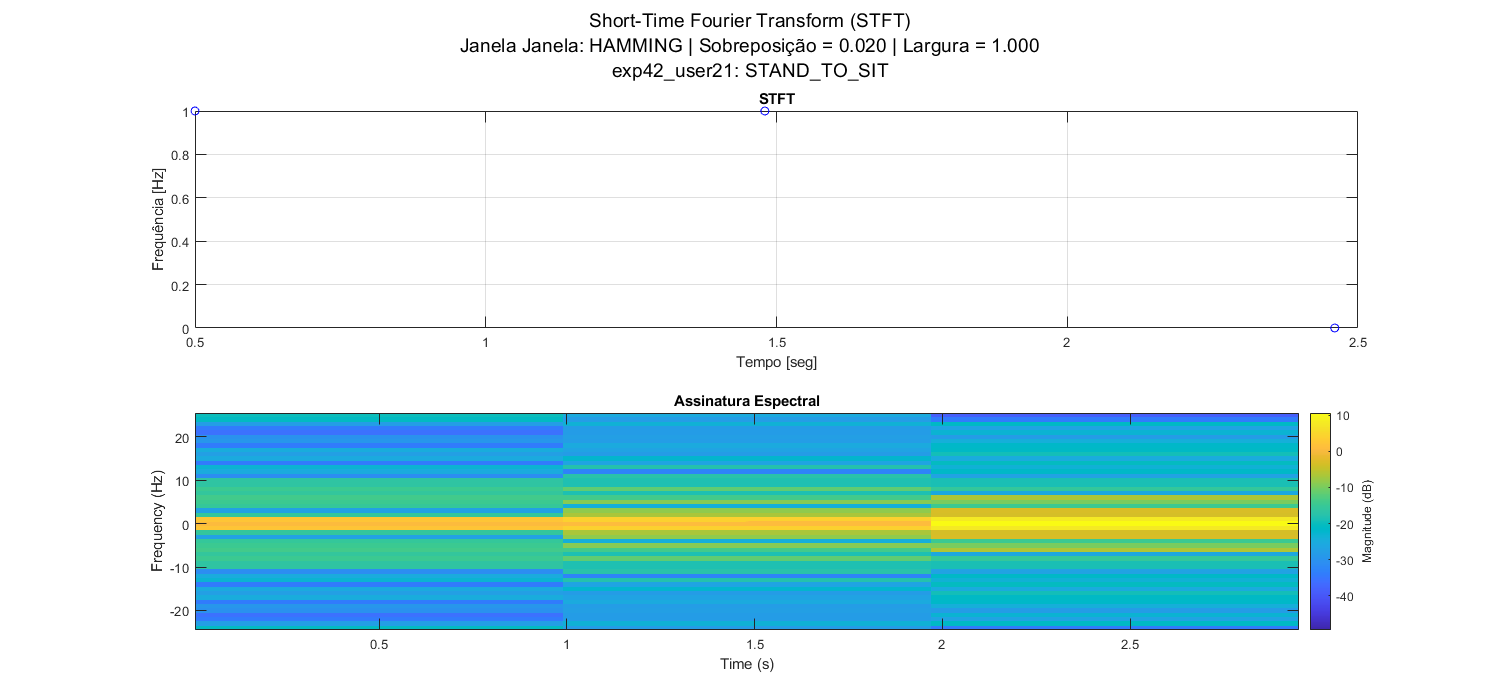

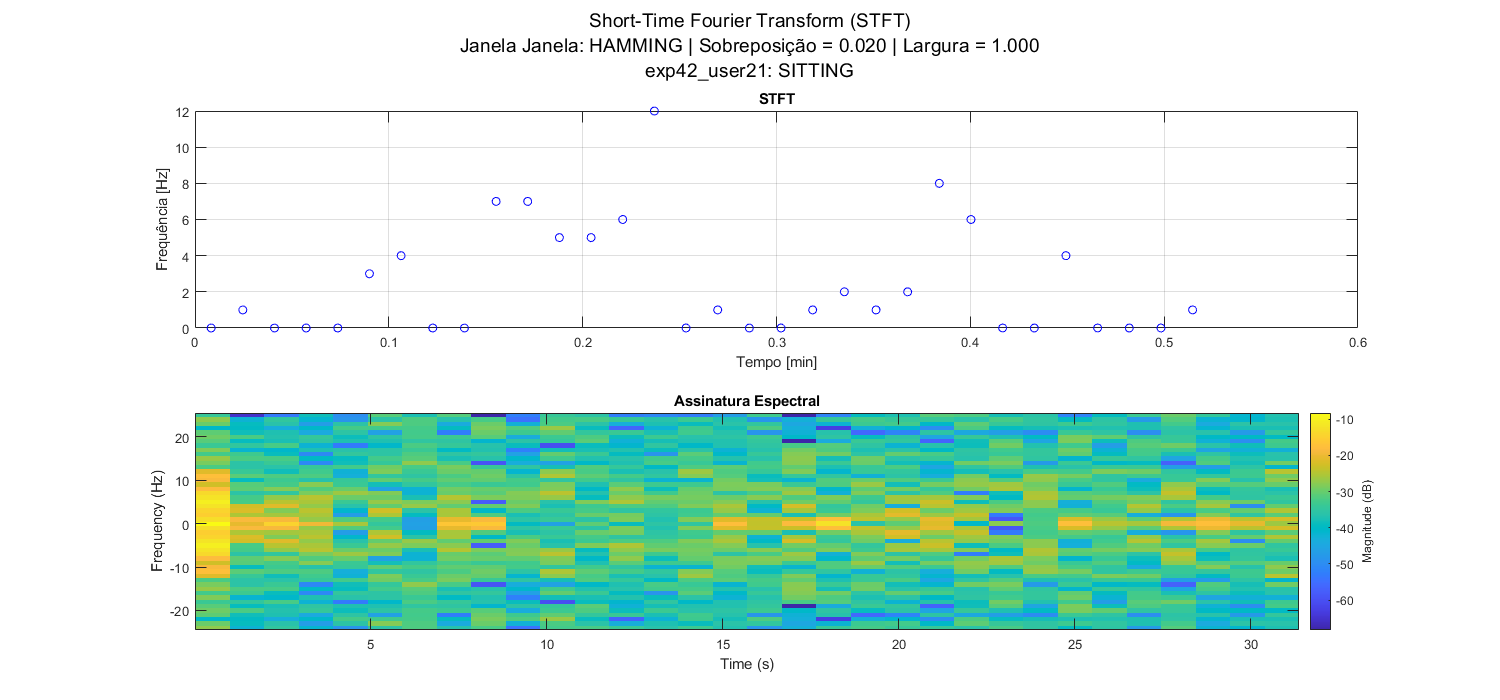

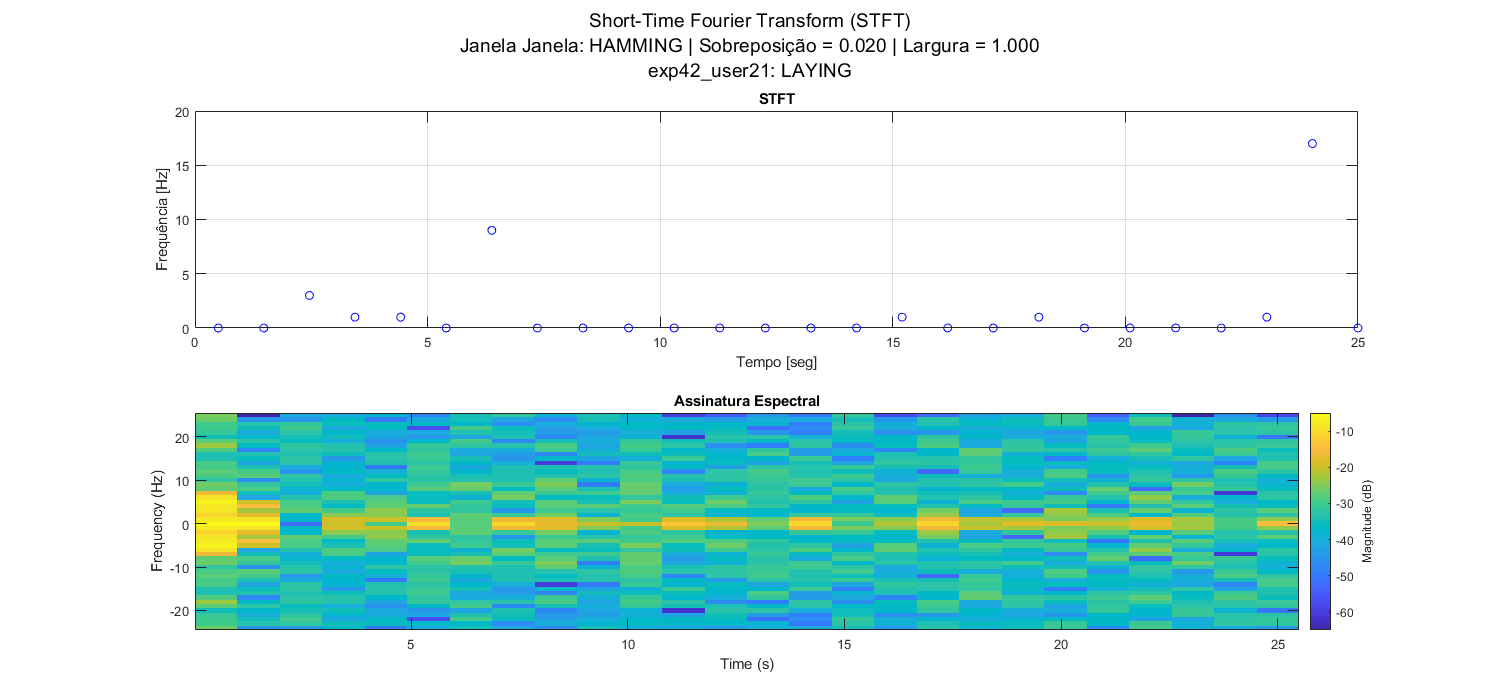

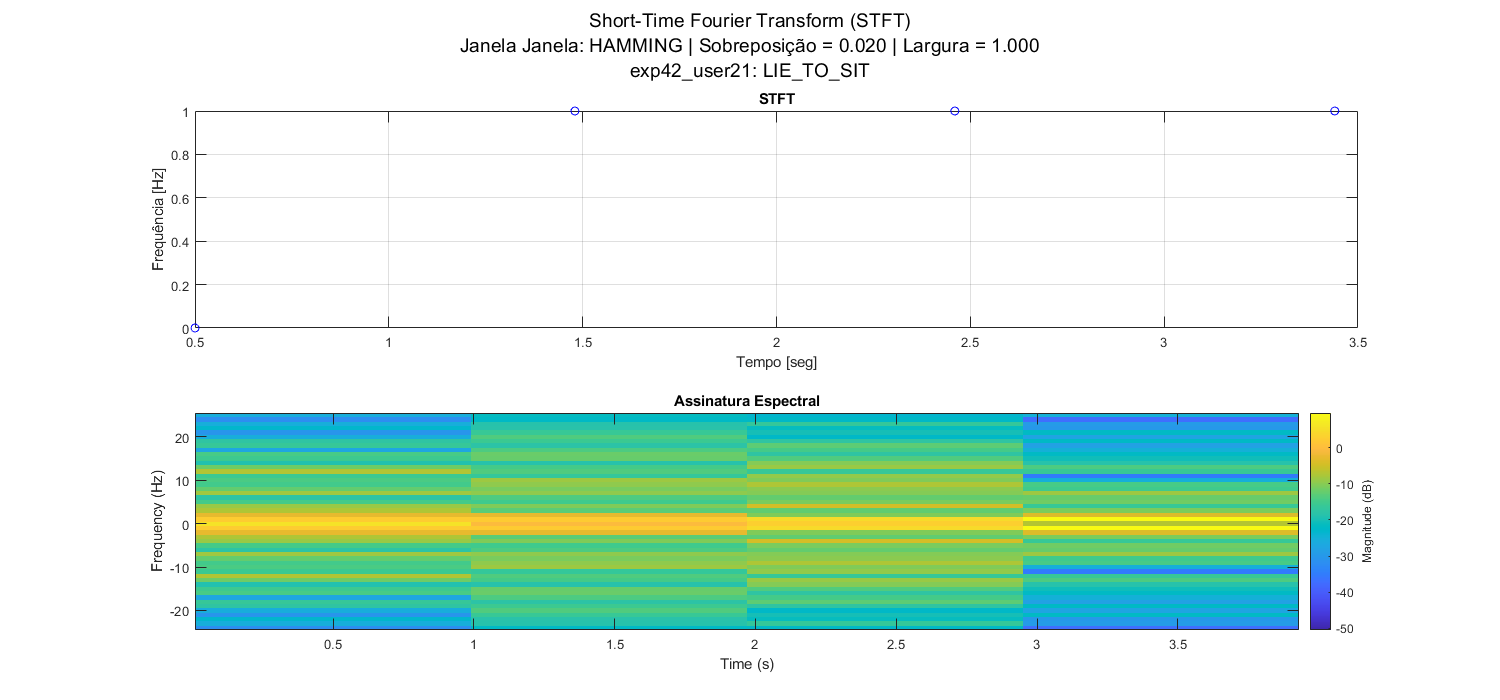

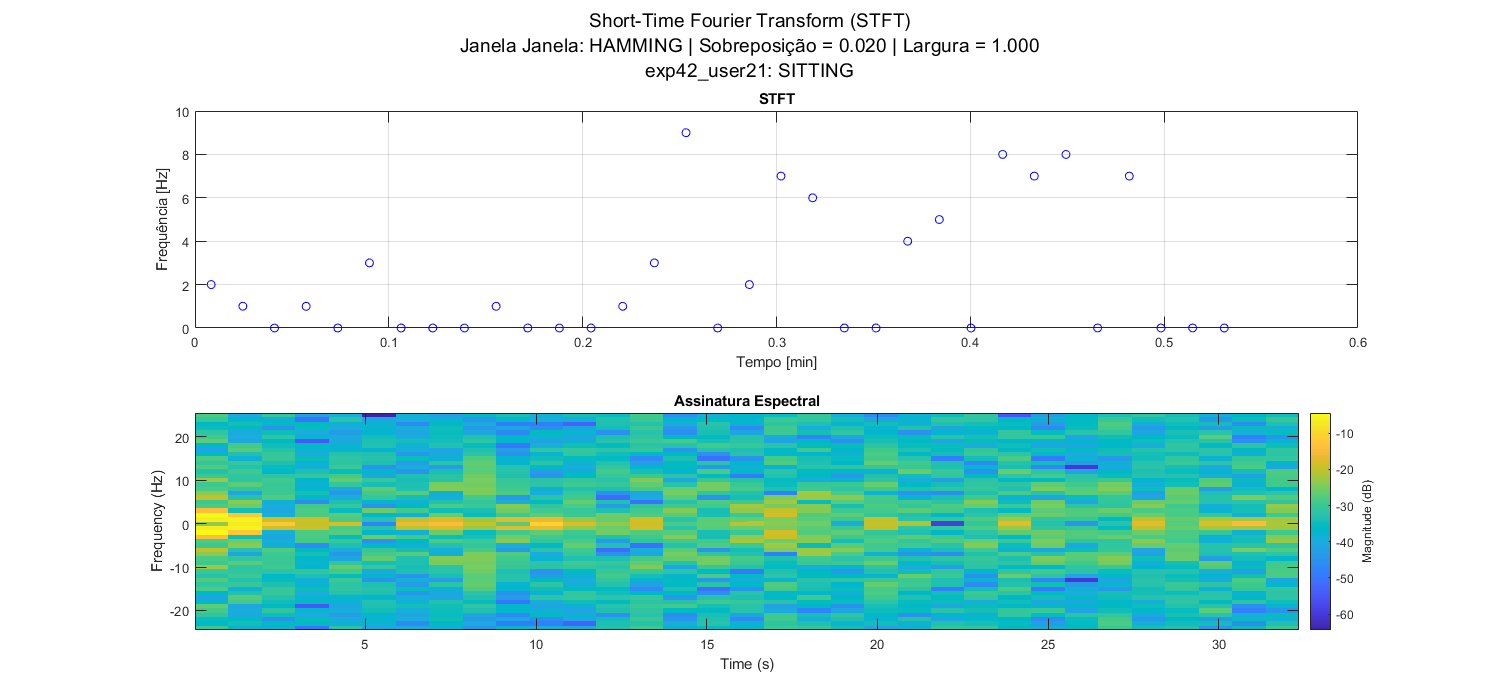

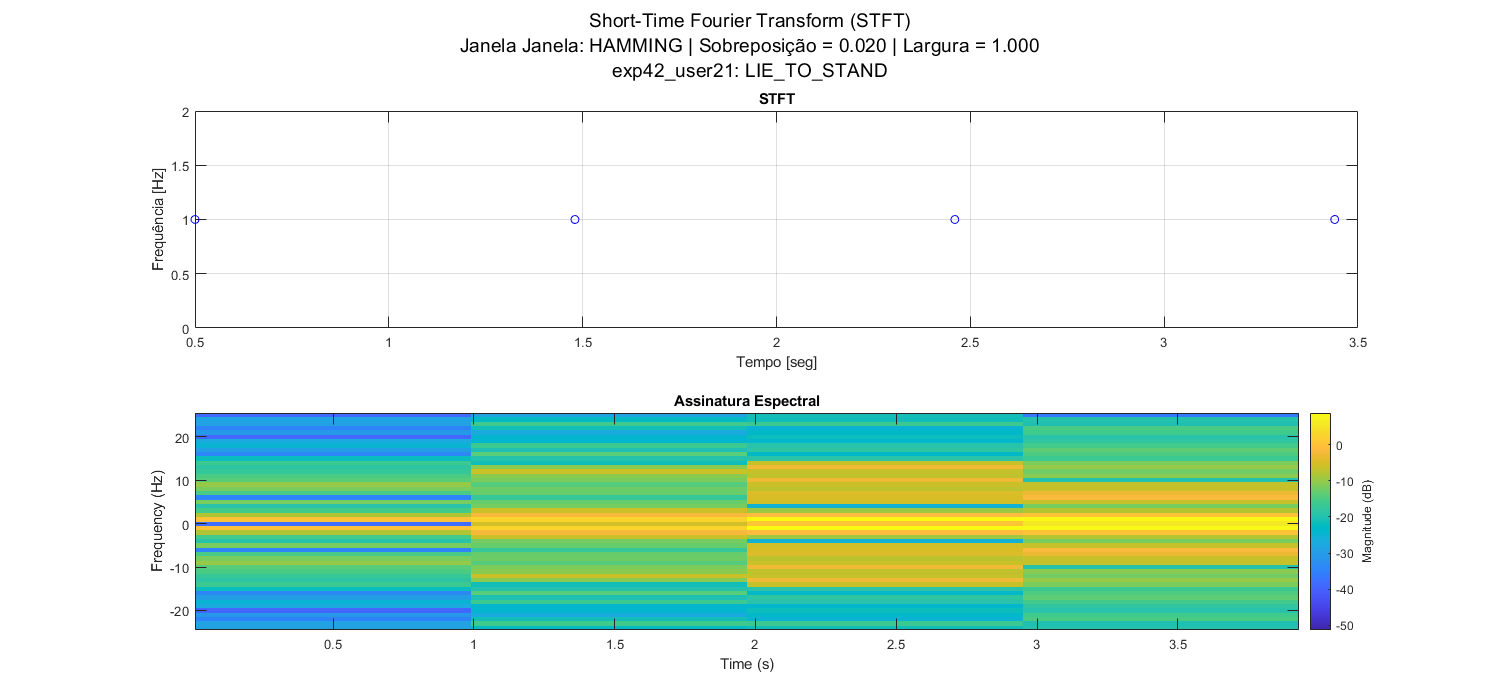

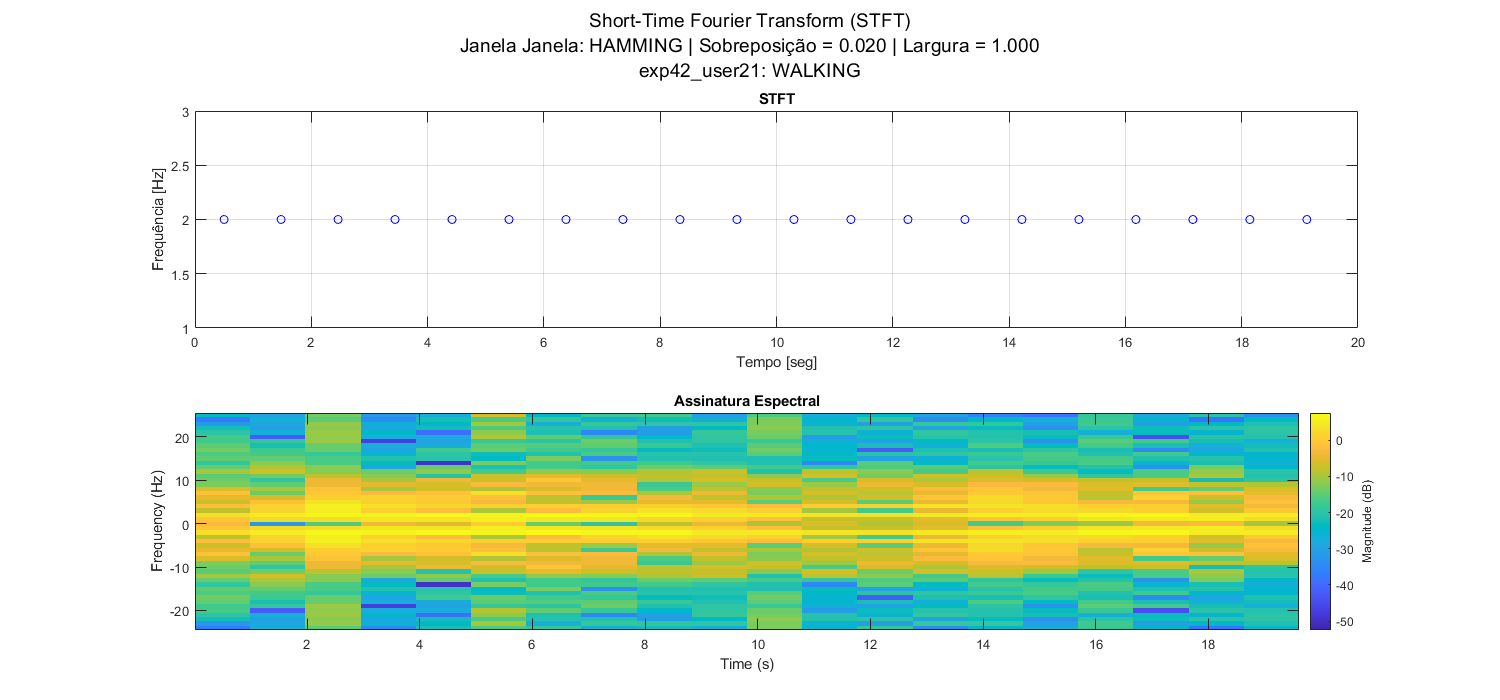

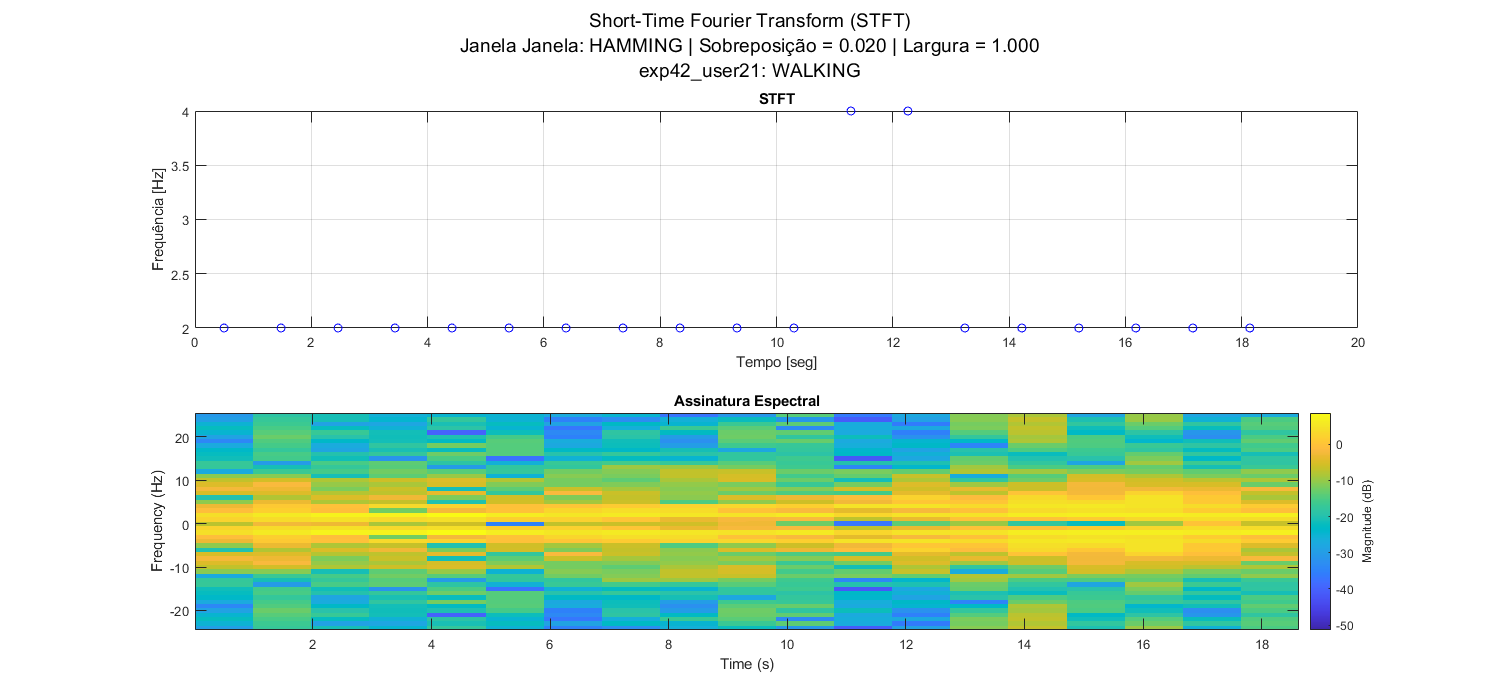

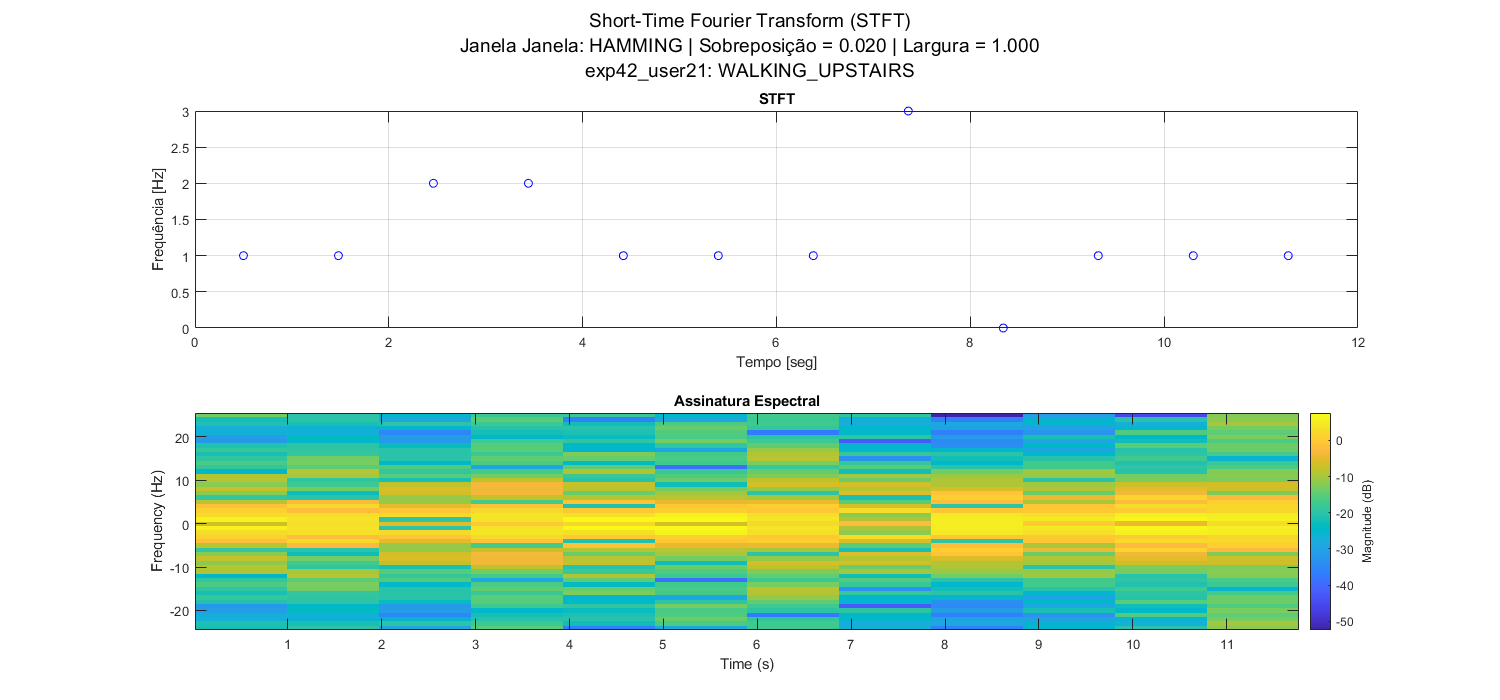

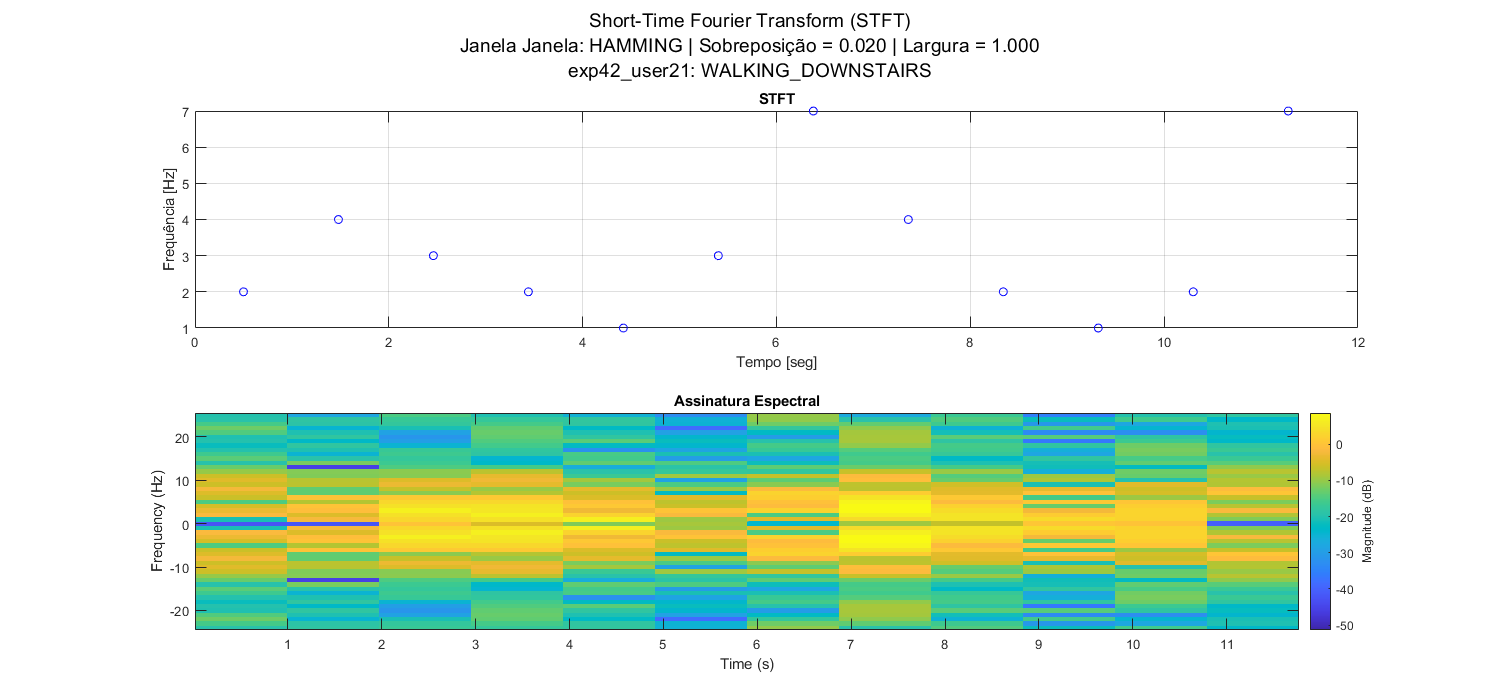

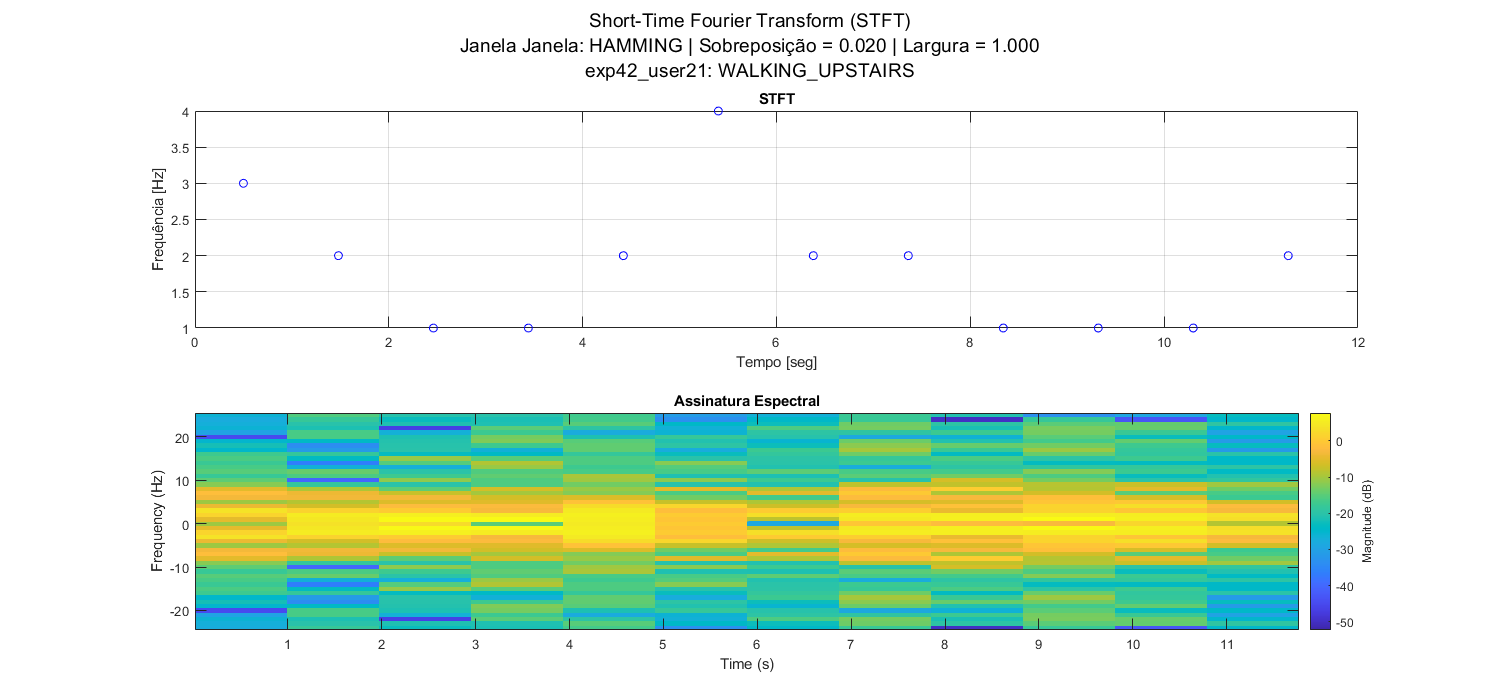

In [24]:
% ########## PARAMETROS: ##########
% > ARRAY COM OS INDICES DOS FICHEIROS DE DADOS A ANALISAR, ex.: [1 3 4 ... n]:
listaData = [1];

% > ARRAY COM OS INDICES DAS ATIVIDADES A ANALISAR, ex.: [4 10 13 ... n]:
listaDataActividades = [1 2 3 7 8 9 12 13 14 18 19 20];

% > INDICE DO TIPO DE JANELA A UTILIZAR, ESCOLHER INDICE DE tipoJanelaID = ["retangular" "hamming" "gausswin"], ex.: 2:
opcaoTipoJanela = 2;

% > ESCOLHER SENSOR, ex.: 3, ACC Z
sensor = 3;

% > INTERVALO DE TEMPO, EM SEGUNDOS, DA SOBREPOSIÇÃO ENTRE JANELAS
tempoSobreposicaoJanelas = 0.02;

% > INTERVALO DE TEMPO, EM SEGUNDOS, DA LARGURA DA JANELA
tempoLarguraJanela = 1.0;

% > É ANALISE AO SINAL TODO OU AS ATIVIDADES EM listaDataActividades? (1 OU 0)
isAnaliseAoSinalTodoFlag = 0;
% #################################


%plot -s 1500,700

% Nota: Se os arrays estiverem vazios, a analise é feita a todo o dataset
if isempty(listaData)
    listaData = 1 : countFichData;
end

% Nota: 1 a 3, evitar ArrayIndexOutOfBoundsException
if sensor > countSensores || sensor < 1
    fprintf("Aviso: Não existe nenhum sensor com indice %d (limites: 1 a %d). Alterado para 3 (%s).\n", sensor, countSensores, sensorID(3));
    sensor = 3; % ACC Z
end

% Nota: 1 a 3, evitar ArrayIndexOutOfBoundsException
if opcaoTipoJanela > countTiposJanela || opcaoTipoJanela < 1
    fprintf("Aviso: Não existe nenhum tipo de janela com indice %d (limites: 1 a %d). Alterado para 2 (%s).\n", opcaoTipoJanela, countTiposJanela, tipoJanelaPlotID(2));
    sensor = 2; % Hamming
end

% numero de amostras = tempo * fs
% Periodo Fundamental, N
countAmostrasLarguraJanela = round(tempoLarguraJanela * fs);

% numero de amostras = tempo * fs
countAmostrasSobreposicaoJanelas = round(tempoSobreposicaoJanelas * fs);

% rectwin(L): returns a rectangular window of length L, https://www.mathworks.com/help/signal/ref/rectwin.html
% hamming(L): returns an L-point symmetric Hamming window, https://www.mathworks.com/help/signal/ref/hamming.html
% gausswin(L): returns an L-point Gaussian window, https://www.mathworks.com/help/signal/ref/gausswin.html
funcaoTipoJanela =  eval("@" + tipoJanelaID(opcaoTipoJanela));
valoresFuncaoTipoJanela = funcaoTipoJanela(countAmostrasLarguraJanela);

% por cada ficheiro de dados
for iterData = listaData
    if iterData <= countFichData && iterData > 0
        data = eval(sprintf(formatoVarData, experimentID(iterData), userID(iterData)));
        
        if isAnaliseAoSinalTodoFlag
            figure();
            sgtitle({"Short-Time Fourier Transform (STFT)" ; sprintf("Janela %s | Sobreposição = %.3f | Largura = %.3f", tipoJanelaPlotID(opcaoTipoJanela), tempoSobreposicaoJanelas, tempoLarguraJanela) ; sprintf(formatoVarData, experimentID(iterData), userID(iterData))}, 'Interpreter', 'none');

            subplot(3, 1, 1);
            % Freq mais relevante
            calcSTFT(detrend(data( : , sensor)), fs, valoresFuncaoTipoJanela, countAmostrasSobreposicaoJanelas, countAmostrasLarguraJanela);
                    
            subplot(3, 1, 2);
            % Estenograma / Assinatura Espectral
            % stft(): Short-time Fourier transform
            stft(detrend(data( : , sensor)), fs, 'Window', valoresFuncaoTipoJanela, 'OverlapLength', countAmostrasSobreposicaoJanelas, 'FFTLength', countAmostrasLarguraJanela);
            title("Assinatura Espectral");
        else
            dataActividades = eval(sprintf(formatoVarDataActividades, experimentID(iterData), userID(iterData)));
        
            countDataActividades = length(dataActividades);
            
            % Nota: Se os arrays estiverem vazios, a analise é feita a todo o dataset
            if isempty(listaDataActividades)
                listaDataActividades = 1 : countDataActividades;
            end
            
            % por cada actividade
            for iterActividade = listaDataActividades
                if iterActividade <= countDataActividades && iterActividade > 0
                    figure();
                    sgtitle({"Short-Time Fourier Transform (STFT)" ; sprintf("Janela %s | Sobreposição = %.3f | Largura = %.3f", "Janela: " + tipoJanelaPlotID(opcaoTipoJanela), tempoSobreposicaoJanelas, tempoLarguraJanela) ; sprintf(formatoVarData, experimentID(iterData), userID(iterData)) + ": " + activityID(dataActividades(iterActividade, 1))}, 'Interpreter', 'none');
                    
                    subplot(2, 1, 1);
                    % Freq mais relevante
                    calcSTFT(detrend(data(dataActividades(iterActividade, 2) : dataActividades(iterActividade, 3), sensor)), fs, valoresFuncaoTipoJanela, countAmostrasSobreposicaoJanelas, countAmostrasLarguraJanela);
                    
                    subplot(2, 1, 2);
                    % Estenograma / Assinatura Espectral
                    % stft(): Short-time Fourier transform
                    stft(detrend(data(dataActividades(iterActividade, 2) : dataActividades(iterActividade, 3), sensor)), fs, 'Window', valoresFuncaoTipoJanela, 'OverlapLength', countAmostrasSobreposicaoJanelas, 'FFTLength', countAmostrasLarguraJanela);
                    title("Assinatura Espectral");
                else
                    % evitar ArrayIndexOutOfBoundsException
                    fprintf("Aviso: O ficheiro %s não tem a atividade com indice %d (max: %d)\n", sprintf(formatoVarData, experimentID(iterData), userID(iterData)), iterActividade, countDataActividades);
                end
            end
        end
    else
        % evitar ArrayIndexOutOfBoundsException
        fprintf("Aviso: Não existe nenhum ficheiro com indice %d (max: %d)\n", iterData, countFichData);
    end
end

clear data dataActividades countAmostrasLarguraJanela countAmostrasSobreposicaoJanelas funcaoTipoJanela isAnaliseAoSinalTodoFlag iterData listaData listaDataActividades opcaoTipoJanela sensor tempoLarguraJanela tempoSobreposicaoJanelas valoresFuncaoTipoJanela countDataActividades iterActividade;

Ao contrário das atividades estáticas, as atividades dinâmicas apresentam várias frequências relevantes (com magnitude alta).

Numa análise ao sinal como um todo, é possível verificar na assinatura espectral a diferenciação entre actividade.

## Referências


[1] Material de apoio da disciplina; <br />
[2] Faculdade de Engenharia da Universidade do Porto, sobre "Smartphone Based Human Activity Prediction", pág. 28, consultado em maio de 2022, disponivel em https://repositorio-aberto.up.pt/bitstream/10216/72620/1/000157899.pdf.